# Waste Classifier from Scratch

Using this dataset from Kaggle https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification

I know I could have imported VGG16 or VGG19 or other Hugging Face models for image classification but I wanted to train the deep learning model myself to see how high my score can be.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Rescaling, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow import cast
from tensorflow import float32
from tensorflow import argmax
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD

In [7]:
!nvidia-smi

Mon Aug 12 15:20:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  |   00000000:02:00.0 Off |                  N/A |
| 71%   26C    P8             14W /  120W |     153MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Importing data and building train, validation and test sets

Downscaling the 256x256 pixel images for faster computation, also tested previously and yielded better results with 128x128

In [8]:
# Create the dataset
dataset = image_dataset_from_directory(
    "./raw_data/images/images/",
    labels='inferred',  # Automatically infer labels
    validation_split=0.2,
    subset="training",
    label_mode='categorical',  # Labels are returned as one-hot encoded vectors
    batch_size=64,  # Number of images in each batch
    image_size=(128, 128),  # Resize images to 256x256
    shuffle=True,  # Shuffle the data
    seed=42  # Set seed for reproducibility
)

# Create the dataset
validation_dataset = image_dataset_from_directory(
    "./raw_data/images/images/",
    labels='inferred',  # Automatically infer labels
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',  # Labels are returned as one-hot encoded vectors
    batch_size=64,  # Number of images in each batch
    image_size=(128, 128),  # Resize images to 256x256
    shuffle=True,  # Shuffle the data
    seed=42  # Set seed for reproducibility
)

Found 15000 files belonging to 30 classes.
Using 12000 files for training.


I0000 00:00:1723476014.579770     492 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723476014.583776     492 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723476014.583884     492 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723476014.584532     492 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 15000 files belonging to 30 classes.
Using 3000 files for validation.


In [9]:
# Calculate the number of batches
val_batches = cardinality(validation_dataset)
test_batches = val_batches // 2
val_batches = val_batches - test_batches

# Split the validation dataset into validation and test sets
test_dataset = validation_dataset.take(test_batches)
validation_dataset = validation_dataset.skip(test_batches)

In [10]:
print(f'Training set size: {cardinality(dataset).numpy()} batches')
print(f'Validation set size: {cardinality(validation_dataset).numpy()} batches')
print(f'Test set size: {cardinality(test_dataset).numpy()} batches')

Training set size: 188 batches
Validation set size: 24 batches
Test set size: 23 batches


In [11]:
dataset.class_names

['aerosol_cans',
 'aluminum_food_cans',
 'aluminum_soda_cans',
 'cardboard_boxes',
 'cardboard_packaging',
 'clothing',
 'coffee_grounds',
 'disposable_plastic_cutlery',
 'eggshells',
 'food_waste',
 'glass_beverage_bottles',
 'glass_cosmetic_containers',
 'glass_food_jars',
 'magazines',
 'newspaper',
 'office_paper',
 'paper_cups',
 'plastic_cup_lids',
 'plastic_detergent_bottles',
 'plastic_food_containers',
 'plastic_shopping_bags',
 'plastic_soda_bottles',
 'plastic_straws',
 'plastic_trash_bags',
 'plastic_water_bottles',
 'shoes',
 'steel_food_cans',
 'styrofoam_cups',
 'styrofoam_food_containers',
 'tea_bags']

In [12]:
class_names = dataset.class_names

# Taking a look at some of the images

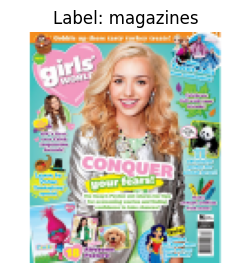

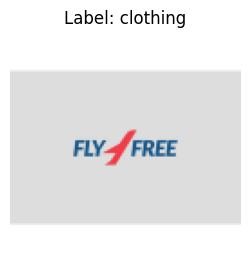

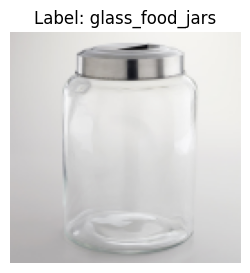

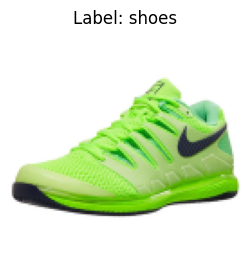

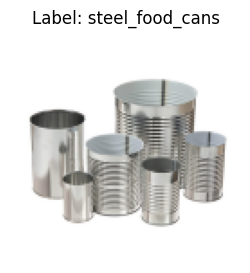

2024-08-12 15:20:18.277591: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# Display example images with labels
for images, labels in dataset.take(1):
    # Convert the first 5 images to numpy arrays and display them
    for i in range(5):
        plt.figure(figsize=(3, 3))
        plt.imshow(images[i].numpy().astype("uint8"))
        # Extract label index from one-hot encoded vector
        label_index = argmax(labels[i]).numpy()
        plt.title(f"Label: {class_names[label_index]}")
        plt.axis("off")
        plt.show()

Normalizing images for training

In [14]:
def normalize(image, label):
    image = cast(image, float32) / 255.0
    return image, label

In [15]:
dataset = dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Starting to build baseline model

In [23]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 10, verbose = 2, restore_best_weights=True)

# Starting out with 1 VGG Block

In [66]:
def initialize_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [67]:
model = initialize_model()

# Train the model with EarlyStopping
onevgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.0351 - loss: 3.5619 - val_accuracy: 0.0327 - val_loss: 3.3676
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.0590 - loss: 3.3374 - val_accuracy: 0.0916 - val_loss: 3.2451
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.1112 - loss: 3.2032 - val_accuracy: 0.1361 - val_loss: 3.1071
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.1532 - loss: 3.0493 - val_accuracy: 0.1512 - val_loss: 2.9495
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.1838 - loss: 2.8968 - val_accuracy: 0.2127 - val_loss: 2.8151
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.2386 - loss: 2.7171 - val_accuracy: 0.2461 - val_loss: 2.6759
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.2980 - loss: 2.5123 - val_accuracy: 0.3135 - val_loss: 2.4906
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.3728 - l

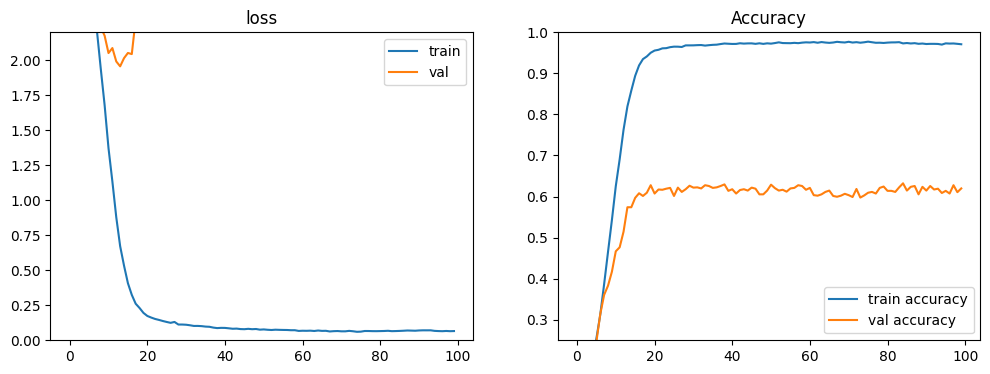

In [68]:
plot_history(onevgghistory)
plt.show()

In [69]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 63.6% compared to a chance level of 1.5625%


# Going to 2 VGG Blocks

In [70]:
def initialize_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = initialize_model()

# Train the model with EarlyStopping
twovgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.0415 - loss: 3.4652 - val_accuracy: 0.0916 - val_loss: 3.3343
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.1005 - loss: 3.2765 - val_accuracy: 0.1590 - val_loss: 3.0074
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.2123 - loss: 2.8929 - val_accuracy: 0.2140 - val_loss: 2.7410
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.2759 - loss: 2.5919 - val_accuracy: 0.3220 - val_loss: 2.4799
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.3499 - loss: 2.3101 - val_accuracy: 0.3586 - val_loss: 2.3360
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.4410 - loss: 2.0125 - val_accuracy: 0.4090 - val_loss: 2.1866
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.5251 - loss: 1.7068 - val_accuracy: 0.4463 - val_loss: 2.1240
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.6015 -

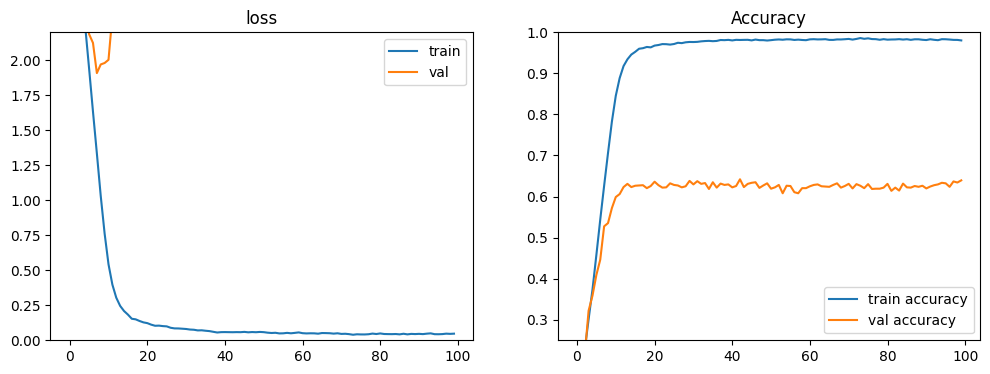

In [71]:
plot_history(twovgghistory)
plt.show()

In [72]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 64.0% compared to a chance level of 1.5625%


# 3 VGG Blocks

In [73]:
# define cnn model
def define_baseline_model():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
     model.add(Dense(30, activation='softmax'))
     # compile model
     opt = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

model = define_baseline_model()

# Train the model with EarlyStopping
threevgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - accuracy: 0.0480 - loss: 3.4109 - val_accuracy: 0.1217 - val_loss: 3.1046
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.1685 - loss: 3.0003 - val_accuracy: 0.2062 - val_loss: 2.8359
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.2509 - loss: 2.6935 - val_accuracy: 0.2801 - val_loss: 2.6044
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.3327 - loss: 2.4027 - val_accuracy: 0.3246 - val_loss: 2.4032
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.4146 - loss: 2.0930 - val_accuracy: 0.4208 - val_loss: 2.1406
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.5209 - loss: 1.7414 - val_accuracy: 0.4843 - val_loss: 1.9806
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.6057 - loss: 1.4044 - val_accuracy: 0.5183 - val_loss: 1.9697
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.6949 -

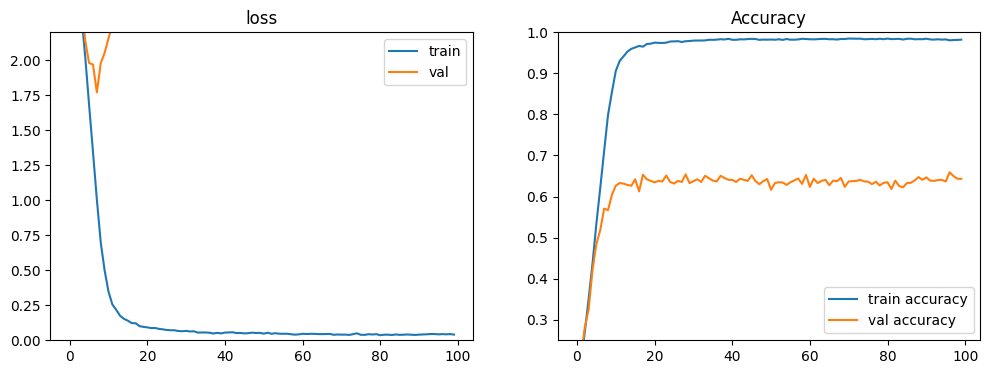

In [74]:
plot_history(threevgghistory)
plt.show()

In [75]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 64.6% compared to a chance level of 1.5625%


# 4 VGG Blocks

In [76]:
# define cnn model
def define_baseline_model():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
     model.add(Dense(30, activation='softmax'))
     # compile model
     opt = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

model = define_baseline_model()

# Train the model with EarlyStopping
fourvgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - accuracy: 0.0444 - loss: 3.4226 - val_accuracy: 0.1145 - val_loss: 3.2677
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.1221 - loss: 3.2088 - val_accuracy: 0.1832 - val_loss: 2.9288
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.2011 - loss: 2.8590 - val_accuracy: 0.2428 - val_loss: 2.6993
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.2748 - loss: 2.5663 - val_accuracy: 0.3148 - val_loss: 2.4878
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.3538 - loss: 2.3105 - val_accuracy: 0.3946 - val_loss: 2.2273
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.4217 - loss: 2.0492 - val_accuracy: 0.3959 - val_loss: 2.1682
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.4975 - loss: 1.7642 - val_accuracy: 0.4490 - val_loss: 2.0662
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.5756 -

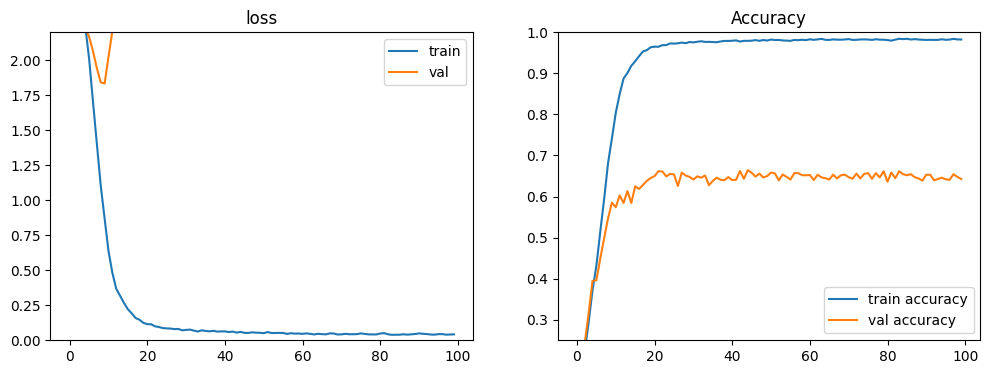

In [77]:
plot_history(fourvgghistory)
plt.show()

In [78]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 65.6% compared to a chance level of 1.5625%


# 5 VGG Blocks

In [ ]:
# define cnn model
def define_baseline_model():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
     model.add(Dense(30, activation='softmax'))
     # compile model
     opt = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

model = define_baseline_model()

# Train the model with EarlyStopping
fivevgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

In [ ]:
plot_history(fivevgghistory)
plt.show()

In [81]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 66.8% compared to a chance level of 1.5625%


# Finished evaluation of baseline model, chosen baseline is: 5 VGG Blocks

--------------------------------

# Now going to test regularization techniques, such as dropout, weight decay and data augmentation

In [113]:
from tensorflow.keras.regularizers import l2

# define cnn model
def define_model_weightdecay():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
     model.add(MaxPooling2D((2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
     model.add(Dense(30, activation='softmax'))
     # compile model
     opt = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

In [114]:
model_weight_decay = define_model_weightdecay()

In [115]:
# Train the model with EarlyStopping
history_weight_decay = model_weight_decay.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=200,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - accuracy: 0.0483 - loss: 42.7559 - val_accuracy: 0.1132 - val_loss: 40.3996
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.1325 - loss: 39.6698 - val_accuracy: 0.1852 - val_loss: 37.4730
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.2018 - loss: 36.7934 - val_accuracy: 0.2454 - val_loss: 34.7864
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.2523 - loss: 34.1948 - val_accuracy: 0.2834 - val_loss: 32.4292
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.2989 - loss: 31.7993 - val_accuracy: 0.3174 - val_loss: 30.1650
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.3448 - loss: 29.5552 - val_accuracy: 0.3573 - val_loss: 28.1245
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.3918 - loss: 27.4597 - val_accuracy: 0.3514 - val_loss: 26.3097
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accu

KeyboardInterrupt: 

In [ ]:
plot_history(history_weight_decay)
plt.show()

In [ ]:
res = model_weight_decay.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

## Creating augmented data

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import AUTOTUNE

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Convert train_dataset to NumPy array and fit the datagen
train_images = []
train_labels = []
for images, labels in dataset:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

train_flow = datagen.flow(train_images, train_labels, batch_size = 64)

2024-08-12 15:26:20.232858: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
data_aug_model = define_baseline_model()
# fit model
steps = int(train_images.shape[0] / 64)
history = data_aug_model.fit(train_flow, steps_per_epoch=steps, epochs=200, validation_data=validation_dataset)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - accuracy: 0.0367 - loss: 3.4988 - val_accuracy: 0.0478 - val_loss: 3.3778
Epoch 2/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.0938 - loss: 3.3409

2024-06-28 17:53:43.708333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:53:43.708436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:53:43.708501: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0938 - loss: 3.3409 - val_accuracy: 0.0478 - val_loss: 3.3814
Epoch 3/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.0442 - loss: 3.3675 - val_accuracy: 0.0497 - val_loss: 3.3578
Epoch 4/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0312 - loss: 3.3382

2024-06-28 17:54:35.082111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:54:35.082214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:54:35.082256: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 17:54:35.082300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0312 - loss: 3.3382 - val_accuracy: 0.0458 - val_loss: 3.3595
Epoch 5/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.0600 - loss: 3.3223 - val_accuracy: 0.0661 - val_loss: 3.2845
Epoch 6/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.0625 - loss: 3.2030

2024-06-28 17:55:25.966281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:55:25.966333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:55:25.966361: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 17:55:25.966390: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0625 - loss: 3.2030 - val_accuracy: 0.0550 - val_loss: 3.2962
Epoch 7/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.0841 - loss: 3.2394 - val_accuracy: 0.0916 - val_loss: 3.1776
Epoch 8/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.1094 - loss: 3.0409

2024-06-28 17:56:16.054977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:56:16.055038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:56:16.055086: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1094 - loss: 3.0409 - val_accuracy: 0.0831 - val_loss: 3.1791
Epoch 9/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.1091 - loss: 3.1368 - val_accuracy: 0.1459 - val_loss: 3.0519
Epoch 10/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.1094 - loss: 2.9412

2024-06-28 17:57:07.696464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:57:07.696529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:57:07.696586: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1094 - loss: 2.9412 - val_accuracy: 0.1486 - val_loss: 3.0289
Epoch 11/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - accuracy: 0.1552 - loss: 2.9985 - val_accuracy: 0.1813 - val_loss: 2.8643
Epoch 12/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.1719 - loss: 3.0755

2024-06-28 17:58:29.973398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:58:29.973472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:58:29.973527: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 17:58:29.973563: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1719 - loss: 3.0755 - val_accuracy: 0.1597 - val_loss: 2.8906
Epoch 13/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 258ms/step - accuracy: 0.1744 - loss: 2.9222 - val_accuracy: 0.2048 - val_loss: 2.7489
Epoch 14/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2188 - loss: 2.8017

2024-06-28 17:59:22.478674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 17:59:22.478747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 17:59:22.478815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2188 - loss: 2.8017 - val_accuracy: 0.2035 - val_loss: 2.7965
Epoch 15/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - accuracy: 0.1960 - loss: 2.8166 - val_accuracy: 0.2264 - val_loss: 2.7734
Epoch 16/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2031 - loss: 2.5633

2024-06-28 18:00:14.428121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:00:14.428232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:00:14.428327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2031 - loss: 2.5633 - val_accuracy: 0.2192 - val_loss: 2.7808
Epoch 17/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.2236 - loss: 2.7166 - val_accuracy: 0.2448 - val_loss: 2.6056
Epoch 18/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.2188 - loss: 2.6714

2024-06-28 18:01:05.627414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:01:05.627487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:01:05.627541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:01:05.627574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2188 - loss: 2.6714 - val_accuracy: 0.2467 - val_loss: 2.6310
Epoch 19/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.2281 - loss: 2.6704 - val_accuracy: 0.2435 - val_loss: 2.6811
Epoch 20/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2344 - loss: 2.6854

2024-06-28 18:01:56.321053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:01:56.321134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:01:56.321201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2344 - loss: 2.6854 - val_accuracy: 0.2683 - val_loss: 2.5582
Epoch 21/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - accuracy: 0.2611 - loss: 2.5503 - val_accuracy: 0.3141 - val_loss: 2.4335
Epoch 22/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3281 - loss: 2.5201

2024-06-28 18:03:19.204957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:03:19.205075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:03:19.205156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3281 - loss: 2.5201 - val_accuracy: 0.3161 - val_loss: 2.4223
Epoch 23/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.2936 - loss: 2.4539 - val_accuracy: 0.3161 - val_loss: 2.3999
Epoch 24/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2344 - loss: 2.4180

2024-06-28 18:04:10.298382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:04:10.298455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:04:10.298524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2344 - loss: 2.4180 - val_accuracy: 0.3069 - val_loss: 2.4310
Epoch 25/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.2921 - loss: 2.4676 - val_accuracy: 0.3403 - val_loss: 2.2734
Epoch 26/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2656 - loss: 2.3955

2024-06-28 18:05:00.964341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:05:00.964412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:05:00.964470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:05:00.964508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2656 - loss: 2.3955 - val_accuracy: 0.3475 - val_loss: 2.2565
Epoch 27/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.3191 - loss: 2.3291 - val_accuracy: 0.3606 - val_loss: 2.2422
Epoch 28/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.3906 - loss: 2.4190

2024-06-28 18:05:51.804729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:05:51.805569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3906 - loss: 2.4190 - val_accuracy: 0.3593 - val_loss: 2.2584
Epoch 29/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.3454 - loss: 2.2590 - val_accuracy: 0.3397 - val_loss: 2.3524
Epoch 30/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3281 - loss: 2.2462

2024-06-28 18:06:42.279788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:06:42.279854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:06:42.279896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:06:42.279934: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3281 - loss: 2.2462 - val_accuracy: 0.3279 - val_loss: 2.3968
Epoch 31/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.3563 - loss: 2.2127 - val_accuracy: 0.3658 - val_loss: 2.1674
Epoch 32/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3438 - loss: 2.2931

2024-06-28 18:07:33.106067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:07:33.106147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:07:33.106196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:07:33.106231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3438 - loss: 2.2931 - val_accuracy: 0.3802 - val_loss: 2.1400
Epoch 33/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.3749 - loss: 2.1354 - val_accuracy: 0.3986 - val_loss: 2.1491
Epoch 34/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3594 - loss: 2.4709

2024-06-28 18:08:24.853057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:08:24.853118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:08:24.853170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3594 - loss: 2.4709 - val_accuracy: 0.3645 - val_loss: 2.2602
Epoch 35/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.3929 - loss: 2.0629 - val_accuracy: 0.3822 - val_loss: 2.2116
Epoch 36/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4062 - loss: 2.1062

2024-06-28 18:09:16.235590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:09:16.235693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:09:16.235822: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4062 - loss: 2.1062 - val_accuracy: 0.4038 - val_loss: 2.1402
Epoch 37/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.4178 - loss: 2.0197 - val_accuracy: 0.4077 - val_loss: 2.1046
Epoch 38/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3281 - loss: 2.1586

2024-06-28 18:10:06.395763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:10:06.395823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:10:06.395850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:10:06.395871: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3281 - loss: 2.1586 - val_accuracy: 0.4025 - val_loss: 2.0896
Epoch 39/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.4354 - loss: 1.9640 - val_accuracy: 0.4548 - val_loss: 1.9366
Epoch 40/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3906 - loss: 1.9170

2024-06-28 18:10:57.213998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:10:57.214068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:10:57.214126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3906 - loss: 1.9170 - val_accuracy: 0.4444 - val_loss: 1.9556
Epoch 41/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 255ms/step - accuracy: 0.4508 - loss: 1.8660 - val_accuracy: 0.4516 - val_loss: 1.9121
Epoch 42/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.4219 - loss: 1.9979

2024-06-28 18:11:48.691078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:11:48.691157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:11:48.691226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4219 - loss: 1.9979 - val_accuracy: 0.4490 - val_loss: 1.9222
Epoch 43/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.4701 - loss: 1.7982 - val_accuracy: 0.4666 - val_loss: 1.9361
Epoch 44/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4844 - loss: 1.8102

2024-06-28 18:12:40.175474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:12:40.175539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:12:40.175600: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4844 - loss: 1.8102 - val_accuracy: 0.4509 - val_loss: 1.9627
Epoch 45/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.4881 - loss: 1.7319 - val_accuracy: 0.5026 - val_loss: 1.7286
Epoch 46/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4688 - loss: 1.9330

2024-06-28 18:13:29.114955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:13:29.115039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:13:29.115103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4688 - loss: 1.9330 - val_accuracy: 0.5033 - val_loss: 1.7461
Epoch 47/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.5148 - loss: 1.6427 - val_accuracy: 0.5085 - val_loss: 1.7485
Epoch 48/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5000 - loss: 1.5302

2024-06-28 18:14:19.904255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:14:19.904337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:14:19.904402: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5000 - loss: 1.5302 - val_accuracy: 0.5052 - val_loss: 1.7463
Epoch 49/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.5402 - loss: 1.5575 - val_accuracy: 0.5157 - val_loss: 1.7467
Epoch 50/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5312 - loss: 1.5764

2024-06-28 18:15:10.954499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:15:10.954564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:15:10.954604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:15:10.954631: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5312 - loss: 1.5764 - val_accuracy: 0.5131 - val_loss: 1.7349
Epoch 51/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.5441 - loss: 1.5329 - val_accuracy: 0.5438 - val_loss: 1.6535
Epoch 52/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5000 - loss: 1.5761

2024-06-28 18:16:01.777553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:16:01.777598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:16:01.777640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5000 - loss: 1.5761 - val_accuracy: 0.5373 - val_loss: 1.6437
Epoch 53/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 255ms/step - accuracy: 0.5703 - loss: 1.4590 - val_accuracy: 0.5268 - val_loss: 1.7514
Epoch 54/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5000 - loss: 1.3449

2024-06-28 18:16:53.382598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:16:53.382638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:16:53.382665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:16:53.382684: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5000 - loss: 1.3449 - val_accuracy: 0.5295 - val_loss: 1.6996
Epoch 55/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.6066 - loss: 1.3452 - val_accuracy: 0.5550 - val_loss: 1.6307
Epoch 56/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3594 - loss: 1.8438

2024-06-28 18:17:44.975116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:17:44.975202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:17:44.975256: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:17:44.975297: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3594 - loss: 1.8438 - val_accuracy: 0.5471 - val_loss: 1.6505
Epoch 57/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.6207 - loss: 1.2522 - val_accuracy: 0.5373 - val_loss: 1.7204
Epoch 58/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5312 - loss: 1.4716

2024-06-28 18:18:35.761701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:18:35.761783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:18:35.761850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:18:35.761895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5312 - loss: 1.4716 - val_accuracy: 0.5438 - val_loss: 1.6288
Epoch 59/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.6405 - loss: 1.2017 - val_accuracy: 0.5844 - val_loss: 1.5418
Epoch 60/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6562 - loss: 1.1037

2024-06-28 18:19:26.599739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:19:26.599819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:19:26.599873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6562 - loss: 1.1037 - val_accuracy: 0.5674 - val_loss: 1.5472
Epoch 61/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 255ms/step - accuracy: 0.6416 - loss: 1.1829 - val_accuracy: 0.5838 - val_loss: 1.6232
Epoch 62/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6406 - loss: 1.3026

2024-06-28 18:20:18.185112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:20:18.185167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:20:18.185201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:20:18.185236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6406 - loss: 1.3026 - val_accuracy: 0.5759 - val_loss: 1.5704
Epoch 63/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.6612 - loss: 1.1133 - val_accuracy: 0.5438 - val_loss: 1.7462
Epoch 64/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6250 - loss: 1.1124

2024-06-28 18:21:10.202208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:21:10.202291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:21:10.202348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:21:10.202392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6250 - loss: 1.1124 - val_accuracy: 0.5733 - val_loss: 1.6506
Epoch 65/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.6776 - loss: 1.0373 - val_accuracy: 0.5825 - val_loss: 1.5867
Epoch 66/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.6875 - loss: 1.2140

2024-06-28 18:22:01.988564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:22:01.988643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:22:01.988717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:22:01.988754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6875 - loss: 1.2140 - val_accuracy: 0.6021 - val_loss: 1.5419
Epoch 67/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.6948 - loss: 1.0043 - val_accuracy: 0.6126 - val_loss: 1.4998
Epoch 68/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7031 - loss: 0.9504

2024-06-28 18:22:53.074110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:22:53.074207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:22:53.074261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:22:53.074390: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7031 - loss: 0.9504 - val_accuracy: 0.6014 - val_loss: 1.5512
Epoch 69/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.7069 - loss: 0.9349 - val_accuracy: 0.6093 - val_loss: 1.5536
Epoch 70/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7500 - loss: 0.7714

2024-06-28 18:23:43.765903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:23:43.765956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-28 18:23:43.765993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7500 - loss: 0.7714 - val_accuracy: 0.6080 - val_loss: 1.5579
Epoch 71/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.7288 - loss: 0.8567 - val_accuracy: 0.6204 - val_loss: 1.5307
Epoch 72/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7188 - loss: 0.7013

2024-06-28 18:24:34.583324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:24:34.583407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:24:34.583469: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:24:34.583593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7188 - loss: 0.7013 - val_accuracy: 0.6185 - val_loss: 1.5891
Epoch 73/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.7353 - loss: 0.8186 - val_accuracy: 0.6492 - val_loss: 1.3600
Epoch 74/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8125 - loss: 0.6592

2024-06-28 18:25:25.719187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:25:25.719258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:25:25.719338: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8125 - loss: 0.6592 - val_accuracy: 0.6466 - val_loss: 1.4170
Epoch 75/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.7609 - loss: 0.7505 - val_accuracy: 0.6414 - val_loss: 1.5044
Epoch 76/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7812 - loss: 0.5930

2024-06-28 18:26:16.170750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:26:16.170796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7812 - loss: 0.5930 - val_accuracy: 0.6440 - val_loss: 1.4749
Epoch 77/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.7738 - loss: 0.7288 - val_accuracy: 0.6270 - val_loss: 1.6412
Epoch 78/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.6875 - loss: 0.8342

2024-06-28 18:27:07.695148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:27:07.695218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:27:07.695311: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6875 - loss: 0.8342 - val_accuracy: 0.6368 - val_loss: 1.5887
Epoch 79/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.7636 - loss: 0.7341 - val_accuracy: 0.6473 - val_loss: 1.4905
Epoch 80/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7656 - loss: 0.8016

2024-06-28 18:27:58.921548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:27:58.921624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:27:58.921689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7656 - loss: 0.8016 - val_accuracy: 0.6538 - val_loss: 1.4690
Epoch 81/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 255ms/step - accuracy: 0.8001 - loss: 0.6153 - val_accuracy: 0.6518 - val_loss: 1.5464
Epoch 82/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.6562 - loss: 1.0785

2024-06-28 18:28:50.361362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:28:50.361427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:28:50.361471: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:28:50.361512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6562 - loss: 1.0785 - val_accuracy: 0.6558 - val_loss: 1.5141
Epoch 83/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 260ms/step - accuracy: 0.8046 - loss: 0.6044 - val_accuracy: 0.6302 - val_loss: 1.6952
Epoch 84/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6875 - loss: 0.8000

2024-06-28 18:29:42.878703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:29:42.878780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:29:42.878836: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:29:42.878872: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6875 - loss: 0.8000 - val_accuracy: 0.6538 - val_loss: 1.5322
Epoch 85/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8236 - loss: 0.5512 - val_accuracy: 0.6558 - val_loss: 1.6019
Epoch 86/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7969 - loss: 0.6409

2024-06-28 18:30:34.213122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:30:34.213197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:30:34.213258: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7969 - loss: 0.6409 - val_accuracy: 0.6387 - val_loss: 1.6334
Epoch 87/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.8164 - loss: 0.5551 - val_accuracy: 0.6662 - val_loss: 1.6022
Epoch 88/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.7812 - loss: 0.7740

2024-06-28 18:31:25.401115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:31:25.401197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:31:25.401247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:31:25.401282: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7812 - loss: 0.7740 - val_accuracy: 0.6715 - val_loss: 1.5944
Epoch 89/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.8356 - loss: 0.5179 - val_accuracy: 0.6623 - val_loss: 1.5991
Epoch 90/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8281 - loss: 0.5431

2024-06-28 18:32:15.984378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:32:15.984518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8281 - loss: 0.5431 - val_accuracy: 0.6407 - val_loss: 1.6424
Epoch 91/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8343 - loss: 0.4975 - val_accuracy: 0.6545 - val_loss: 1.6155
Epoch 92/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8594 - loss: 0.4742

2024-06-28 18:33:07.082565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:33:07.082635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:33:07.082680: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:33:07.082718: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8594 - loss: 0.4742 - val_accuracy: 0.6669 - val_loss: 1.5620
Epoch 93/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.8457 - loss: 0.4628 - val_accuracy: 0.6361 - val_loss: 1.7969
Epoch 94/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7500 - loss: 0.9247

2024-06-28 18:33:58.757000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:33:58.757073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:33:58.757136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:33:58.757181: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7500 - loss: 0.9247 - val_accuracy: 0.6296 - val_loss: 1.8054
Epoch 95/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.8545 - loss: 0.4500 - val_accuracy: 0.6806 - val_loss: 1.5964
Epoch 96/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8438 - loss: 0.4078

2024-06-28 18:34:47.861842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:34:47.861900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:34:47.861939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:34:47.861972: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8438 - loss: 0.4078 - val_accuracy: 0.6774 - val_loss: 1.5709
Epoch 97/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8474 - loss: 0.4500 - val_accuracy: 0.6675 - val_loss: 1.7000
Epoch 98/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8750 - loss: 0.4869

2024-06-28 18:35:38.810765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:35:38.810845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:35:38.810896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:35:38.810940: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8750 - loss: 0.4869 - val_accuracy: 0.6891 - val_loss: 1.6082
Epoch 99/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.8630 - loss: 0.4218 - val_accuracy: 0.6414 - val_loss: 1.7844
Epoch 100/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7344 - loss: 0.8857

2024-06-28 18:36:29.363309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:36:29.363374: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289
2024-06-28 18:36:29.363426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7344 - loss: 0.8857 - val_accuracy: 0.6486 - val_loss: 1.7442
Epoch 101/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8720 - loss: 0.3877 - val_accuracy: 0.6747 - val_loss: 1.6147
Epoch 102/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8750 - loss: 0.3049

2024-06-28 18:37:20.058461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:37:20.058549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:37:20.058610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:37:20.058700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8750 - loss: 0.3049 - val_accuracy: 0.6859 - val_loss: 1.5929
Epoch 103/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8790 - loss: 0.3804 - val_accuracy: 0.6878 - val_loss: 1.6076
Epoch 104/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9375 - loss: 0.2004

2024-06-28 18:38:11.528758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:38:11.528833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:38:11.528883: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:38:11.528917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9375 - loss: 0.2004 - val_accuracy: 0.6891 - val_loss: 1.6365
Epoch 105/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.8855 - loss: 0.3448 - val_accuracy: 0.6616 - val_loss: 1.7420
Epoch 106/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9062 - loss: 0.3569

2024-06-28 18:39:01.236620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:39:01.236717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:39:01.236773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:39:01.236808: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9062 - loss: 0.3569 - val_accuracy: 0.6656 - val_loss: 1.7701
Epoch 107/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.8850 - loss: 0.3391 - val_accuracy: 0.6996 - val_loss: 1.6176
Epoch 108/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9531 - loss: 0.1914

2024-06-28 18:39:51.624574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:39:51.624651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:39:51.624759: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9531 - loss: 0.1914 - val_accuracy: 0.6957 - val_loss: 1.6271
Epoch 109/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 256ms/step - accuracy: 0.8911 - loss: 0.3140 - val_accuracy: 0.7029 - val_loss: 1.6356
Epoch 110/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9062 - loss: 0.3213

2024-06-28 18:40:43.298137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:40:43.298228: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289
2024-06-28 18:40:43.298451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9062 - loss: 0.3213 - val_accuracy: 0.6891 - val_loss: 1.6868
Epoch 111/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 249ms/step - accuracy: 0.8993 - loss: 0.2880 - val_accuracy: 0.6996 - val_loss: 1.7040
Epoch 112/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9375 - loss: 0.1739

2024-06-28 18:42:04.093367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:42:04.093445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0.1739 - val_accuracy: 0.7081 - val_loss: 1.6384
Epoch 113/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.9000 - loss: 0.2927 - val_accuracy: 0.7088 - val_loss: 1.7294
Epoch 114/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8594 - loss: 0.5773

2024-06-28 18:42:55.685415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:42:55.685499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:42:55.685557: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:42:55.685594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8594 - loss: 0.5773 - val_accuracy: 0.7068 - val_loss: 1.6916
Epoch 115/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.9040 - loss: 0.2843 - val_accuracy: 0.6970 - val_loss: 1.6369
Epoch 116/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8906 - loss: 0.2971

2024-06-28 18:43:46.468207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:43:46.468299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:43:46.468356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:43:46.468434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8906 - loss: 0.2971 - val_accuracy: 0.7016 - val_loss: 1.6833
Epoch 117/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.9113 - loss: 0.2595 - val_accuracy: 0.6852 - val_loss: 1.8728
Epoch 118/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9062 - loss: 0.2440

2024-06-28 18:44:36.488933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:44:36.488987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:44:36.489053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9062 - loss: 0.2440 - val_accuracy: 0.6747 - val_loss: 1.8884
Epoch 119/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.9090 - loss: 0.2766 - val_accuracy: 0.6957 - val_loss: 1.7414
Epoch 120/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9219 - loss: 0.3062

2024-06-28 18:45:27.153112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:45:27.153196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:45:27.153238: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:45:27.153275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9219 - loss: 0.3062 - val_accuracy: 0.6760 - val_loss: 1.8203
Epoch 121/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.9079 - loss: 0.2627 - val_accuracy: 0.6931 - val_loss: 1.7345
Epoch 122/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9219 - loss: 0.2035

2024-06-28 18:46:17.063595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:46:17.063652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:46:17.063691: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:46:17.063717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9219 - loss: 0.2035 - val_accuracy: 0.7009 - val_loss: 1.7438
Epoch 123/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.9165 - loss: 0.2503 - val_accuracy: 0.6957 - val_loss: 1.8610
Epoch 124/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9062 - loss: 0.2123

2024-06-28 18:47:07.488804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:47:07.488879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:47:07.488942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:47:07.488983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9062 - loss: 0.2123 - val_accuracy: 0.6944 - val_loss: 1.8314
Epoch 125/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.9185 - loss: 0.2345 - val_accuracy: 0.7081 - val_loss: 1.7996
Epoch 126/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8594 - loss: 0.4033

2024-06-28 18:47:57.331395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:47:57.331472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:47:57.331537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8594 - loss: 0.4033 - val_accuracy: 0.7081 - val_loss: 1.7598
Epoch 127/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.9194 - loss: 0.2336 - val_accuracy: 0.7042 - val_loss: 1.7045
Epoch 128/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9375 - loss: 0.1728

2024-06-28 18:48:47.393097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:48:47.393142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9375 - loss: 0.1728 - val_accuracy: 0.6957 - val_loss: 1.7717
Epoch 129/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.9263 - loss: 0.2197 - val_accuracy: 0.7088 - val_loss: 1.7059
Epoch 130/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9062 - loss: 0.2625

2024-06-28 18:49:38.090257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:49:38.090330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:49:38.090384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:49:38.090421: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9062 - loss: 0.2625 - val_accuracy: 0.7068 - val_loss: 1.7034
Epoch 131/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.9269 - loss: 0.2201 - val_accuracy: 0.7042 - val_loss: 1.6519
Epoch 132/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8906 - loss: 0.3074

2024-06-28 18:50:29.958581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-28 18:50:29.958641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8906 - loss: 0.3074 - val_accuracy: 0.6957 - val_loss: 1.7584
Epoch 133/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.9299 - loss: 0.2017 - val_accuracy: 0.7029 - val_loss: 1.7700
Epoch 134/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9531 - loss: 0.1812

2024-06-28 18:51:20.380174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:51:20.380255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289
2024-06-28 18:51:20.380295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9531 - loss: 0.1812 - val_accuracy: 0.7094 - val_loss: 1.7875
Epoch 135/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.9326 - loss: 0.1966 - val_accuracy: 0.7160 - val_loss: 1.7028
Epoch 136/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9531 - loss: 0.0897

2024-06-28 18:52:11.765274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:52:11.765329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:52:11.765366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:52:11.765387: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9531 - loss: 0.0897 - val_accuracy: 0.7147 - val_loss: 1.7317
Epoch 137/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.9306 - loss: 0.1961 - val_accuracy: 0.7166 - val_loss: 1.6772
Epoch 138/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9688 - loss: 0.0800

2024-06-28 18:53:01.107837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:53:01.107942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:53:01.108322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9688 - loss: 0.0800 - val_accuracy: 0.7232 - val_loss: 1.6854
Epoch 139/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.9432 - loss: 0.1664 - val_accuracy: 0.7094 - val_loss: 1.6913
Epoch 140/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9219 - loss: 0.1686

2024-06-28 18:53:50.711807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:53:50.711901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:53:50.711975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9219 - loss: 0.1686 - val_accuracy: 0.7186 - val_loss: 1.6361
Epoch 141/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.9315 - loss: 0.1948 - val_accuracy: 0.7068 - val_loss: 1.7444
Epoch 142/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8906 - loss: 0.2800

2024-06-28 18:54:40.483582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:54:40.483670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:54:40.483737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:54:40.483773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8906 - loss: 0.2800 - val_accuracy: 0.7101 - val_loss: 1.7827
Epoch 143/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.9396 - loss: 0.1731 - val_accuracy: 0.7055 - val_loss: 1.8537
Epoch 144/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9844 - loss: 0.1230

2024-06-28 18:55:31.113478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:55:31.113581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:55:31.113676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9844 - loss: 0.1230 - val_accuracy: 0.7042 - val_loss: 1.8154
Epoch 145/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.9441 - loss: 0.1598 - val_accuracy: 0.7094 - val_loss: 1.9953
Epoch 146/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9219 - loss: 0.2401

2024-06-28 18:56:22.368070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:56:22.368156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:56:22.368277: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9219 - loss: 0.2401 - val_accuracy: 0.7081 - val_loss: 1.9854
Epoch 147/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.9394 - loss: 0.1774 - val_accuracy: 0.6957 - val_loss: 1.8736
Epoch 148/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9375 - loss: 0.1573

2024-06-28 18:57:44.281729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:57:44.281821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:57:44.281910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0.1573 - val_accuracy: 0.7081 - val_loss: 1.7734
Epoch 149/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.9457 - loss: 0.1489 - val_accuracy: 0.6970 - val_loss: 1.9797
Epoch 150/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9375 - loss: 0.2172

2024-06-28 18:58:33.959072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:58:33.959140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:58:33.959197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 18:58:33.959234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0.2172 - val_accuracy: 0.6813 - val_loss: 2.0631
Epoch 151/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.9391 - loss: 0.1624 - val_accuracy: 0.7107 - val_loss: 1.9676
Epoch 152/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9375 - loss: 0.1188

2024-06-28 18:59:23.829583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 18:59:23.829666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 18:59:23.829736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9375 - loss: 0.1188 - val_accuracy: 0.7120 - val_loss: 1.9305
Epoch 153/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.9445 - loss: 0.1611 - val_accuracy: 0.6990 - val_loss: 1.7890
Epoch 154/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9219 - loss: 0.2042

2024-06-28 19:00:14.886142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:00:14.886211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:00:14.886273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:00:14.886309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9219 - loss: 0.2042 - val_accuracy: 0.7029 - val_loss: 1.7974
Epoch 155/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.9403 - loss: 0.1549 - val_accuracy: 0.7022 - val_loss: 1.7990
Epoch 156/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9688 - loss: 0.0827

2024-06-28 19:01:06.074681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:01:06.074757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:01:06.074820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9688 - loss: 0.0827 - val_accuracy: 0.7048 - val_loss: 1.8193
Epoch 157/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.9459 - loss: 0.1584 - val_accuracy: 0.7120 - val_loss: 2.0656
Epoch 158/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9531 - loss: 0.1580

2024-06-28 19:01:56.716755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:01:56.716831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:01:56.716897: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9531 - loss: 0.1580 - val_accuracy: 0.7173 - val_loss: 2.0284
Epoch 159/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.9456 - loss: 0.1534 - val_accuracy: 0.7199 - val_loss: 1.8205
Epoch 160/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9531 - loss: 0.0747

2024-06-28 19:02:46.632758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:02:46.632825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-28 19:02:46.632888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9531 - loss: 0.0747 - val_accuracy: 0.7160 - val_loss: 1.8205
Epoch 161/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 239ms/step - accuracy: 0.9478 - loss: 0.1477 - val_accuracy: 0.7094 - val_loss: 1.8202
Epoch 162/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8906 - loss: 0.2036

2024-06-28 19:03:35.671850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:03:35.671931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:03:35.672004: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8906 - loss: 0.2036 - val_accuracy: 0.7199 - val_loss: 1.7768
Epoch 163/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.9520 - loss: 0.1431 - val_accuracy: 0.7035 - val_loss: 1.8200
Epoch 164/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9375 - loss: 0.2292

2024-06-28 19:04:25.680043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:04:25.680114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:04:25.680188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9375 - loss: 0.2292 - val_accuracy: 0.7068 - val_loss: 1.8353
Epoch 165/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.9482 - loss: 0.1409 - val_accuracy: 0.7225 - val_loss: 1.7404
Epoch 166/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9219 - loss: 0.1721

2024-06-28 19:05:15.659699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:05:15.659778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:05:15.659930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9219 - loss: 0.1721 - val_accuracy: 0.7042 - val_loss: 1.8445
Epoch 167/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.9525 - loss: 0.1318 - val_accuracy: 0.7114 - val_loss: 1.9425
Epoch 168/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9531 - loss: 0.1235

2024-06-28 19:06:06.452874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:06:06.452994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:06:06.453081: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:06:06.453137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9531 - loss: 0.1235 - val_accuracy: 0.6990 - val_loss: 1.9945
Epoch 169/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 250ms/step - accuracy: 0.9521 - loss: 0.1256 - val_accuracy: 0.7101 - val_loss: 1.7950
Epoch 170/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9219 - loss: 0.2487

2024-06-28 19:07:28.666185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:07:28.666275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9219 - loss: 0.2487 - val_accuracy: 0.7212 - val_loss: 1.7184
Epoch 171/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.9534 - loss: 0.1231 - val_accuracy: 0.7068 - val_loss: 1.8568
Epoch 172/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9688 - loss: 0.0717

2024-06-28 19:08:18.672977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:08:18.673064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:08:18.673234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9688 - loss: 0.0717 - val_accuracy: 0.7062 - val_loss: 1.9063
Epoch 173/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.9539 - loss: 0.1202 - val_accuracy: 0.7101 - val_loss: 1.9020
Epoch 174/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9375 - loss: 0.2906

2024-06-28 19:09:10.176702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:09:10.176795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:09:10.176856: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:09:10.176902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9375 - loss: 0.2906 - val_accuracy: 0.7003 - val_loss: 1.9113
Epoch 175/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.9497 - loss: 0.1232 - val_accuracy: 0.7120 - val_loss: 1.9432
Epoch 176/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8906 - loss: 0.2372

2024-06-28 19:10:00.502926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:10:00.503006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:10:00.503077: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8906 - loss: 0.2372 - val_accuracy: 0.7042 - val_loss: 2.0151
Epoch 177/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 256ms/step - accuracy: 0.9547 - loss: 0.1219 - val_accuracy: 0.7147 - val_loss: 2.0057
Epoch 178/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9531 - loss: 0.1423

2024-06-28 19:10:52.470726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:10:52.470799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:10:52.470849: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:10:52.470890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9531 - loss: 0.1423 - val_accuracy: 0.7186 - val_loss: 1.9781
Epoch 179/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.9571 - loss: 0.1213 - val_accuracy: 0.7147 - val_loss: 1.9758
Epoch 180/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9688 - loss: 0.0415

2024-06-28 19:11:43.574447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:11:43.574532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:11:43.574602: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9688 - loss: 0.0415 - val_accuracy: 0.7081 - val_loss: 1.9690
Epoch 181/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.9583 - loss: 0.1136 - val_accuracy: 0.7114 - val_loss: 1.9259
Epoch 182/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9531 - loss: 0.0993

2024-06-28 19:12:34.709580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:12:34.709664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:12:34.709719: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:12:34.709755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9531 - loss: 0.0993 - val_accuracy: 0.7153 - val_loss: 1.9590
Epoch 183/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.9601 - loss: 0.1110 - val_accuracy: 0.7140 - val_loss: 1.8820
Epoch 184/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8594 - loss: 0.2764

2024-06-28 19:13:26.469894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:13:26.469969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:13:26.470016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:13:26.470054: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8594 - loss: 0.2764 - val_accuracy: 0.7062 - val_loss: 1.9895
Epoch 185/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 238ms/step - accuracy: 0.9587 - loss: 0.1071 - val_accuracy: 0.7219 - val_loss: 1.9286
Epoch 186/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9531 - loss: 0.1042

2024-06-28 19:14:15.324269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:14:15.324353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:14:15.324428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9531 - loss: 0.1042 - val_accuracy: 0.7140 - val_loss: 1.9386
Epoch 187/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.9595 - loss: 0.1068 - val_accuracy: 0.7258 - val_loss: 1.8235
Epoch 188/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9375 - loss: 0.1560

2024-06-28 19:15:05.093220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:15:05.093304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9375 - loss: 0.1560 - val_accuracy: 0.7134 - val_loss: 1.8971
Epoch 189/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.9613 - loss: 0.1064 - val_accuracy: 0.7153 - val_loss: 1.8203
Epoch 190/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9375 - loss: 0.2082

2024-06-28 19:15:56.134879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:15:56.134956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:15:56.135011: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:15:56.135052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0.2082 - val_accuracy: 0.7219 - val_loss: 1.8177
Epoch 191/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.9587 - loss: 0.1050 - val_accuracy: 0.7081 - val_loss: 1.9949
Epoch 192/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9531 - loss: 0.0772

2024-06-28 19:16:46.156761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:16:46.156840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:16:46.156907: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9531 - loss: 0.0772 - val_accuracy: 0.7107 - val_loss: 1.9973
Epoch 193/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.9604 - loss: 0.1064 - val_accuracy: 0.7199 - val_loss: 1.9335
Epoch 194/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9844 - loss: 0.0816

2024-06-28 19:17:36.980502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:17:36.980581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:17:36.980656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9844 - loss: 0.0816 - val_accuracy: 0.7186 - val_loss: 1.9559
Epoch 195/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.9567 - loss: 0.1111 - val_accuracy: 0.7094 - val_loss: 1.9946
Epoch 196/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9844 - loss: 0.0876

2024-06-28 19:18:27.956154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:18:27.956226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:18:27.956282: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:18:27.956317: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9844 - loss: 0.0876 - val_accuracy: 0.7147 - val_loss: 1.9590
Epoch 197/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.9614 - loss: 0.1135 - val_accuracy: 0.7062 - val_loss: 2.0282
Epoch 198/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 1.0000 - loss: 0.0480

2024-06-28 19:19:19.283238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:19:19.283320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:19:19.283369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:19:19.283406: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0480 - val_accuracy: 0.7147 - val_loss: 2.0260
Epoch 199/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.9591 - loss: 0.1081 - val_accuracy: 0.7186 - val_loss: 1.9307
Epoch 200/200
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9688 - loss: 0.1115

2024-06-28 19:20:09.482577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 19:20:09.482677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 19:20:09.482748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 19:20:09.482795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9688 - loss: 0.1115 - val_accuracy: 0.7199 - val_loss: 1.9141


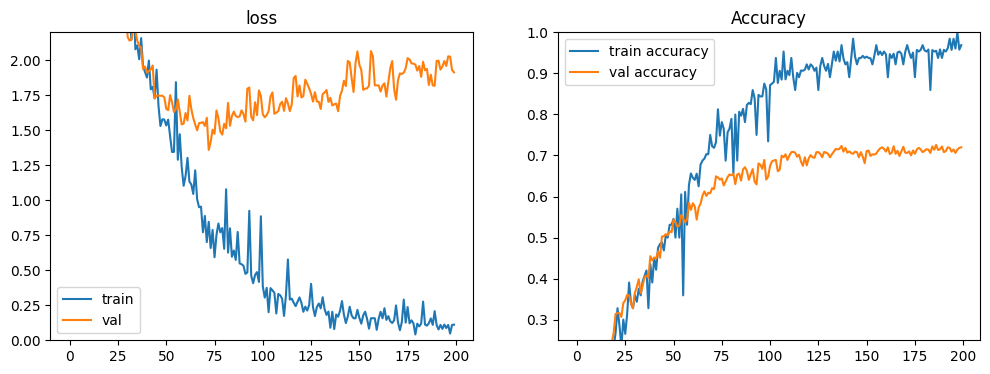

In [42]:
plot_history(history)
plt.show()

In [43]:
res = data_aug_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 73.4% compared to a chance level of 3.125%


In [102]:
#trying out cascading dropout rates

def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [103]:
dropout_model = dropout_model()

# Train the model with EarlyStopping
history_dropout_model = dropout_model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 164ms/step - accuracy: 0.0373 - loss: 3.8622 - val_accuracy: 0.0419 - val_loss: 3.3971
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.0356 - loss: 3.3934 - val_accuracy: 0.0569 - val_loss: 3.3863
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0459 - loss: 3.3745 - val_accuracy: 0.0923 - val_loss: 3.3632
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.0706 - loss: 3.3375 - val_accuracy: 0.0916 - val_loss: 3.2746
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.0949 - loss: 3.2451 - val_accuracy: 0.1348 - val_loss: 3.1566
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.1130 - loss: 3.1464 - val_accuracy: 0.1479 - val_loss: 3.0847
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.1441 - loss: 3.0525 - val_accuracy: 0.1741 - val_loss: 2.9971
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.1547 -

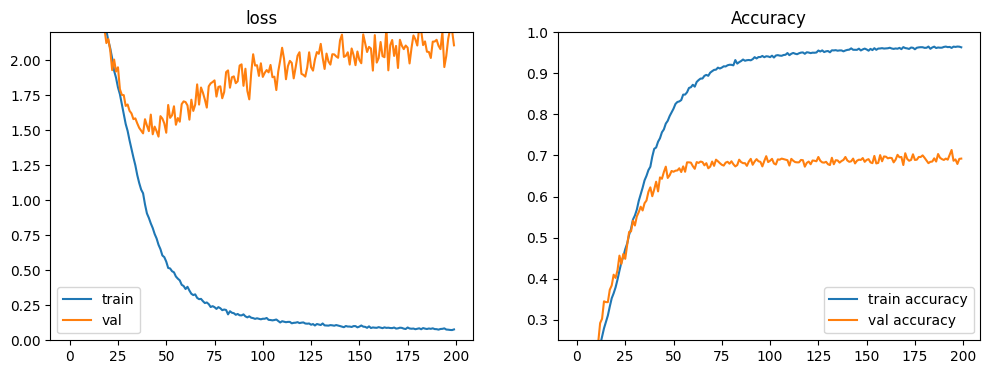

In [104]:
plot_history(history_dropout_model)
plt.show()

In [105]:
res = dropout_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 70.8% compared to a chance level of 3.125%


In [109]:
def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [110]:
dropout_model = dropout_model()

# Train the model with EarlyStopping
history_dropout_model = dropout_model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=200,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 168ms/step - accuracy: 0.0344 - loss: 4.3484 - val_accuracy: 0.0478 - val_loss: 3.3992
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.0372 - loss: 3.3915 - val_accuracy: 0.0844 - val_loss: 3.3901
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.0468 - loss: 3.3770 - val_accuracy: 0.0785 - val_loss: 3.3795
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.0535 - loss: 3.3589 - val_accuracy: 0.0792 - val_loss: 3.3692
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.0659 - loss: 3.3432 - val_accuracy: 0.0831 - val_loss: 3.3631
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.0689 - loss: 3.3213 - val_accuracy: 0.0949 - val_loss: 3.3501
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.0748 - loss: 3.3044 - val_accuracy: 0.0884 - val_loss: 3.3158
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.0818 -

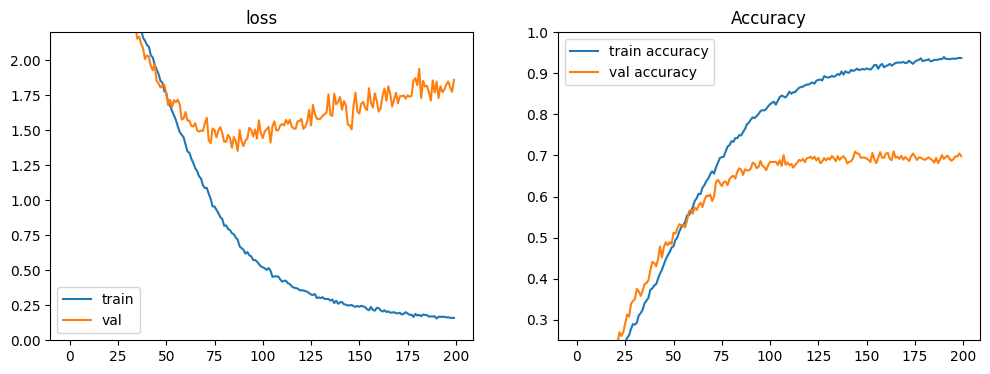

In [111]:
plot_history(history_dropout_model)
plt.show()

In [112]:
res = dropout_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 71.3% compared to a chance level of 3.125%


In [38]:
#BEST MODEL CURRENTLY

def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

dropout_model = dropout_model()

# Train the model with EarlyStopping
history_dropout_model = dropout_model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=200,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.0326 - loss: 4.5608 - val_accuracy: 0.0517 - val_loss: 3.4006
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.0385 - loss: 3.3994 - val_accuracy: 0.0471 - val_loss: 3.4001
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.0367 - loss: 3.3977 - val_accuracy: 0.0497 - val_loss: 3.3991
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.0365 - loss: 3.3936 - val_accuracy: 0.0569 - val_loss: 3.3963
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.0449 - loss: 3.3862 - val_accuracy: 0.0740 - val_loss: 3.3929
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.0476 - loss: 3.3739 - val_accuracy: 0.0772 - val_loss: 3.3873
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.0577 - loss: 3.3579 - val_accuracy: 0.0825 - val_loss: 3.3779
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.0556 - loss: 

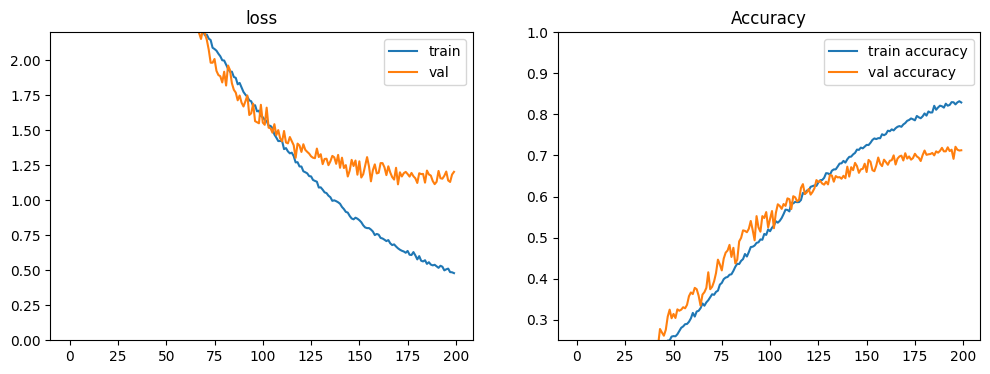

The accuracy is 71.8% compared to a chance level of 1.5625%


In [39]:
plot_history(history_dropout_model)
plt.show()

res = dropout_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

# Mixing models

### Dropout Model that performed best (40% after each layer) plus Data Augmentation combined

In [48]:
def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

data_aug_plus_droput_model = dropout_model()
# fit model
steps = int(train_images.shape[0] / 64)
history = data_aug_plus_droput_model.fit(train_flow, steps_per_epoch=steps, epochs=400, validation_data=validation_dataset)

Epoch 1/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 314ms/step - accuracy: 0.0296 - loss: 4.1673 - val_accuracy: 0.0301 - val_loss: 3.4002
Epoch 2/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.0312 - loss: 3.4112

2024-06-28 22:50:40.503381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:50:40.503507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:50:40.503562: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:50:40.503601: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0312 - loss: 3.4112 - val_accuracy: 0.0327 - val_loss: 3.4000
Epoch 3/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.0330 - loss: 3.3963 - val_accuracy: 0.0419 - val_loss: 3.3956
Epoch 4/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.0000e+00 - loss: 3.4105

2024-06-28 22:51:31.651476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:51:31.651574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:51:31.651637: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:51:31.651673: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0000e+00 - loss: 3.4105 - val_accuracy: 0.0380 - val_loss: 3.3958
Epoch 5/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.0376 - loss: 3.3811 - val_accuracy: 0.0445 - val_loss: 3.3865
Epoch 6/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0000e+00 - loss: 3.3631

2024-06-28 22:52:23.062941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:52:23.063025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:52:23.063072: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:52:23.063101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0000e+00 - loss: 3.3631 - val_accuracy: 0.0517 - val_loss: 3.3857
Epoch 7/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.0482 - loss: 3.3593 - val_accuracy: 0.0491 - val_loss: 3.3839
Epoch 8/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0938 - loss: 3.3106

2024-06-28 22:53:13.840117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:53:13.840215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:53:13.840278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:53:13.840313: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0938 - loss: 3.3106 - val_accuracy: 0.0504 - val_loss: 3.3848
Epoch 9/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.0552 - loss: 3.3488 - val_accuracy: 0.0465 - val_loss: 3.3880
Epoch 10/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.0312 - loss: 3.3009

2024-06-28 22:54:04.654576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:54:04.654646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:54:04.654689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:54:04.654715: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0312 - loss: 3.3009 - val_accuracy: 0.0465 - val_loss: 3.3857
Epoch 11/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.0565 - loss: 3.3456 - val_accuracy: 0.0510 - val_loss: 3.3792
Epoch 12/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.0781 - loss: 3.3754

2024-06-28 22:54:55.393240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:54:55.393316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:54:55.393386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:54:55.393422: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0781 - loss: 3.3754 - val_accuracy: 0.0458 - val_loss: 3.3801
Epoch 13/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.0600 - loss: 3.3327 - val_accuracy: 0.0596 - val_loss: 3.3781
Epoch 14/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0781 - loss: 3.3487

2024-06-28 22:55:46.768532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:55:46.768605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0781 - loss: 3.3487 - val_accuracy: 0.0563 - val_loss: 3.3776
Epoch 15/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.0652 - loss: 3.3316 - val_accuracy: 0.0504 - val_loss: 3.3791
Epoch 16/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.0781 - loss: 3.3177

2024-06-28 22:56:38.358886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:56:38.358995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:56:38.359040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:56:38.359072: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0781 - loss: 3.3177 - val_accuracy: 0.0530 - val_loss: 3.3786
Epoch 17/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.0647 - loss: 3.3111 - val_accuracy: 0.0471 - val_loss: 3.3818
Epoch 18/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0156 - loss: 3.3289

2024-06-28 22:57:28.316799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:57:28.316899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:57:28.316976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:57:28.317020: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0156 - loss: 3.3289 - val_accuracy: 0.0491 - val_loss: 3.3828
Epoch 19/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.0688 - loss: 3.3067 - val_accuracy: 0.0491 - val_loss: 3.3844
Epoch 20/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0469 - loss: 3.2415

2024-06-28 22:58:18.327860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:58:18.327959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 22:58:18.328043: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 22:58:18.328093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0469 - loss: 3.2415 - val_accuracy: 0.0471 - val_loss: 3.3812
Epoch 21/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 257ms/step - accuracy: 0.0671 - loss: 3.3033 - val_accuracy: 0.0576 - val_loss: 3.3682
Epoch 22/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0938 - loss: 3.2961

2024-06-28 22:59:09.936359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 22:59:09.936439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0938 - loss: 3.2961 - val_accuracy: 0.0596 - val_loss: 3.3646
Epoch 23/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.0690 - loss: 3.2878 - val_accuracy: 0.0465 - val_loss: 3.3715
Epoch 24/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0938 - loss: 3.2268

2024-06-28 23:00:01.367113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:00:01.367185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:00:01.367229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:00:01.367265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0938 - loss: 3.2268 - val_accuracy: 0.0491 - val_loss: 3.3702
Epoch 25/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.0712 - loss: 3.2826 - val_accuracy: 0.0373 - val_loss: 3.3821
Epoch 26/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.1250 - loss: 3.2406

2024-06-28 23:00:51.862044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:00:51.862145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:00:51.862193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:00:51.862231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1250 - loss: 3.2406 - val_accuracy: 0.0399 - val_loss: 3.3796
Epoch 27/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.0731 - loss: 3.2666 - val_accuracy: 0.0412 - val_loss: 3.3921
Epoch 28/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0469 - loss: 3.2571

2024-06-28 23:01:42.630043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:01:42.630129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:01:42.630202: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0469 - loss: 3.2571 - val_accuracy: 0.0366 - val_loss: 3.3920
Epoch 29/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.0787 - loss: 3.2522 - val_accuracy: 0.0465 - val_loss: 3.3905
Epoch 30/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0781 - loss: 3.2097

2024-06-28 23:02:33.723516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:02:33.723608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:02:33.723661: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:02:33.723710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0781 - loss: 3.2097 - val_accuracy: 0.0478 - val_loss: 3.3846
Epoch 31/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.0793 - loss: 3.2425 - val_accuracy: 0.0412 - val_loss: 3.3838
Epoch 32/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0469 - loss: 3.2183

2024-06-28 23:03:23.634861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:03:23.634958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:03:23.635023: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:03:23.635066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0469 - loss: 3.2183 - val_accuracy: 0.0432 - val_loss: 3.3786
Epoch 33/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.0815 - loss: 3.2412 - val_accuracy: 0.0412 - val_loss: 3.4041
Epoch 34/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1094 - loss: 3.1430

2024-06-28 23:04:14.477242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:04:14.477358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:04:14.477439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:04:14.477488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1094 - loss: 3.1430 - val_accuracy: 0.0452 - val_loss: 3.3850
Epoch 35/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.0872 - loss: 3.2113 - val_accuracy: 0.0321 - val_loss: 3.4290
Epoch 36/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1719 - loss: 3.0296

2024-06-28 23:05:04.832739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:05:04.832830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:05:04.832957: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:05:04.833001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1719 - loss: 3.0296 - val_accuracy: 0.0399 - val_loss: 3.4107
Epoch 37/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.0886 - loss: 3.2160 - val_accuracy: 0.0406 - val_loss: 3.4151
Epoch 38/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0312 - loss: 3.2634

2024-06-28 23:05:55.123085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:05:55.123196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:05:55.123276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:05:55.123333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0312 - loss: 3.2634 - val_accuracy: 0.0471 - val_loss: 3.4007
Epoch 39/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.0871 - loss: 3.2085 - val_accuracy: 0.0308 - val_loss: 3.4533
Epoch 40/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.1250 - loss: 3.1632

2024-06-28 23:06:45.092814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:06:45.092912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:06:45.092960: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:06:45.092998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1250 - loss: 3.1632 - val_accuracy: 0.0321 - val_loss: 3.4523
Epoch 41/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.0925 - loss: 3.1914 - val_accuracy: 0.0314 - val_loss: 3.4850
Epoch 42/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1406 - loss: 3.2225

2024-06-28 23:07:35.025960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:07:35.026045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:07:35.026098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:07:35.026139: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1406 - loss: 3.2225 - val_accuracy: 0.0334 - val_loss: 3.4851
Epoch 43/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.0965 - loss: 3.1873 - val_accuracy: 0.0360 - val_loss: 3.5002
Epoch 44/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.0781 - loss: 3.2562

2024-06-28 23:08:25.151028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:08:25.151122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:08:25.151181: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:08:25.151225: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0781 - loss: 3.2562 - val_accuracy: 0.0353 - val_loss: 3.4965
Epoch 45/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.0902 - loss: 3.1778 - val_accuracy: 0.0275 - val_loss: 3.4948
Epoch 46/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.0469 - loss: 3.1286

2024-06-28 23:09:16.123694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:09:16.123774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:09:16.123837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:09:16.123874: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0469 - loss: 3.1286 - val_accuracy: 0.0340 - val_loss: 3.4900
Epoch 47/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.0983 - loss: 3.1743 - val_accuracy: 0.0366 - val_loss: 3.5072
Epoch 48/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.0781 - loss: 3.2846

2024-06-28 23:10:07.236637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-28 23:10:07.236678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0781 - loss: 3.2846 - val_accuracy: 0.0412 - val_loss: 3.5098
Epoch 49/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.1086 - loss: 3.1530 - val_accuracy: 0.0386 - val_loss: 3.4910
Epoch 50/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1250 - loss: 3.0863

2024-06-28 23:10:58.533869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:10:58.533953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:10:58.534006: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:10:58.534049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1250 - loss: 3.0863 - val_accuracy: 0.0393 - val_loss: 3.4929
Epoch 51/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.1043 - loss: 3.1551 - val_accuracy: 0.0360 - val_loss: 3.4680
Epoch 52/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.0938 - loss: 3.0978

2024-06-28 23:11:48.957468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:11:48.957557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:11:48.957631: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:11:48.957679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0938 - loss: 3.0978 - val_accuracy: 0.0406 - val_loss: 3.4662
Epoch 53/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.1086 - loss: 3.1443 - val_accuracy: 0.0393 - val_loss: 3.5416
Epoch 54/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1562 - loss: 2.9830

2024-06-28 23:12:39.331283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:12:39.331365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:12:39.331420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:12:39.331456: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1562 - loss: 2.9830 - val_accuracy: 0.0386 - val_loss: 3.5393
Epoch 55/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.1168 - loss: 3.1388 - val_accuracy: 0.0452 - val_loss: 3.4976
Epoch 56/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2031 - loss: 3.0638

2024-06-28 23:13:29.552356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:13:29.552431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:13:29.552476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:13:29.552508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2031 - loss: 3.0638 - val_accuracy: 0.0524 - val_loss: 3.4802
Epoch 57/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.1221 - loss: 3.1187 - val_accuracy: 0.0576 - val_loss: 3.5165
Epoch 58/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1562 - loss: 3.0286

2024-06-28 23:14:19.252868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:14:19.252959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:14:19.253017: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:14:19.253058: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1562 - loss: 3.0286 - val_accuracy: 0.0537 - val_loss: 3.5461
Epoch 59/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.1249 - loss: 3.0998 - val_accuracy: 0.0628 - val_loss: 3.4567
Epoch 60/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1250 - loss: 3.1417

2024-06-28 23:15:09.250571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:15:09.250666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:15:09.250722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:15:09.250765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1250 - loss: 3.1417 - val_accuracy: 0.0654 - val_loss: 3.4409
Epoch 61/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.1314 - loss: 3.0876 - val_accuracy: 0.0582 - val_loss: 3.4939
Epoch 62/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.1562 - loss: 2.8602

2024-06-28 23:15:59.194115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:15:59.194164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1562 - loss: 2.8602 - val_accuracy: 0.0556 - val_loss: 3.5212
Epoch 63/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.1414 - loss: 3.0534 - val_accuracy: 0.0452 - val_loss: 3.6029
Epoch 64/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.1406 - loss: 2.9755

2024-06-28 23:16:49.335665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:16:49.335759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1406 - loss: 2.9755 - val_accuracy: 0.0491 - val_loss: 3.5850
Epoch 65/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.1443 - loss: 3.0423 - val_accuracy: 0.0569 - val_loss: 3.5581
Epoch 66/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0469 - loss: 3.2686

2024-06-28 23:17:39.236697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:17:39.236794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:17:39.236862: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:17:39.236908: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0469 - loss: 3.2686 - val_accuracy: 0.0556 - val_loss: 3.5729
Epoch 67/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.1382 - loss: 3.0569 - val_accuracy: 0.0844 - val_loss: 3.3902
Epoch 68/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1562 - loss: 3.1184

2024-06-28 23:18:29.436867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:18:29.436952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:18:29.437010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:18:29.437057: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1562 - loss: 3.1184 - val_accuracy: 0.0890 - val_loss: 3.3876
Epoch 69/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.1451 - loss: 3.0225 - val_accuracy: 0.0641 - val_loss: 3.5065
Epoch 70/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1250 - loss: 3.1695

2024-06-28 23:19:19.103957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:19:19.104048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:19:19.104118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:19:19.104165: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1250 - loss: 3.1695 - val_accuracy: 0.0740 - val_loss: 3.4763
Epoch 71/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.1575 - loss: 3.0099 - val_accuracy: 0.0798 - val_loss: 3.4048
Epoch 72/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.1562 - loss: 2.9091

2024-06-28 23:20:09.551980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:20:09.552186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1562 - loss: 2.9091 - val_accuracy: 0.0870 - val_loss: 3.3891
Epoch 73/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.1647 - loss: 2.9655 - val_accuracy: 0.1021 - val_loss: 3.3271
Epoch 74/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1719 - loss: 2.8559

2024-06-28 23:21:00.036361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:21:00.036468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:21:00.036521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:21:00.036560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1719 - loss: 2.8559 - val_accuracy: 0.1060 - val_loss: 3.3277
Epoch 75/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.1588 - loss: 2.9613 - val_accuracy: 0.1132 - val_loss: 3.2955
Epoch 76/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1562 - loss: 3.0673

2024-06-28 23:21:50.621923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:21:50.622000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:21:50.622053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:21:50.622089: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1562 - loss: 3.0673 - val_accuracy: 0.1093 - val_loss: 3.2725
Epoch 77/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.1706 - loss: 2.9526 - val_accuracy: 0.1414 - val_loss: 3.1428
Epoch 78/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1719 - loss: 3.1392

2024-06-28 23:22:40.561288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:22:40.561358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289
2024-06-28 23:22:40.561411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1719 - loss: 3.1392 - val_accuracy: 0.1381 - val_loss: 3.1560
Epoch 79/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.1706 - loss: 2.9500 - val_accuracy: 0.1211 - val_loss: 3.2680
Epoch 80/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.0938 - loss: 2.8882

2024-06-28 23:23:30.671036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:23:30.671086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:23:30.671117: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:23:30.671135: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0938 - loss: 2.8882 - val_accuracy: 0.1027 - val_loss: 3.3322
Epoch 81/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.1805 - loss: 2.8937 - val_accuracy: 0.1558 - val_loss: 3.0632
Epoch 82/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1875 - loss: 2.8418

2024-06-28 23:24:20.571729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:24:20.571825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1875 - loss: 2.8418 - val_accuracy: 0.1603 - val_loss: 3.0651
Epoch 83/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.1834 - loss: 2.8954 - val_accuracy: 0.1080 - val_loss: 3.3346
Epoch 84/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1562 - loss: 2.9230

2024-06-28 23:25:11.503154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:25:11.503227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1562 - loss: 2.9230 - val_accuracy: 0.0962 - val_loss: 3.3289
Epoch 85/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.1915 - loss: 2.8633 - val_accuracy: 0.1289 - val_loss: 3.1408
Epoch 86/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2344 - loss: 2.7086

2024-06-28 23:26:01.923959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:26:01.924049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:26:01.924107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:26:01.924220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2344 - loss: 2.7086 - val_accuracy: 0.1309 - val_loss: 3.2081
Epoch 87/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.1983 - loss: 2.8355 - val_accuracy: 0.1741 - val_loss: 3.0004
Epoch 88/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2812 - loss: 2.7814

2024-06-28 23:26:52.129373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:26:52.129459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:26:52.129620: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2812 - loss: 2.7814 - val_accuracy: 0.1728 - val_loss: 3.0118
Epoch 89/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.1989 - loss: 2.8319 - val_accuracy: 0.1270 - val_loss: 3.0853
Epoch 90/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.1562 - loss: 2.7729

2024-06-28 23:27:42.464787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:27:42.464844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:27:42.464882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:27:42.464906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1562 - loss: 2.7729 - val_accuracy: 0.1407 - val_loss: 3.0307
Epoch 91/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.2066 - loss: 2.7922 - val_accuracy: 0.1577 - val_loss: 3.0621
Epoch 92/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2969 - loss: 2.7494

2024-06-28 23:28:32.717411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:28:32.717487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:28:32.717561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:28:32.717604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2969 - loss: 2.7494 - val_accuracy: 0.1518 - val_loss: 3.0717
Epoch 93/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.2138 - loss: 2.7949 - val_accuracy: 0.1813 - val_loss: 2.9898
Epoch 94/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.1250 - loss: 3.0886

2024-06-28 23:29:23.162760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:29:23.162820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:29:23.162863: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:29:23.162888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1250 - loss: 3.0886 - val_accuracy: 0.1715 - val_loss: 3.0315
Epoch 95/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.2216 - loss: 2.7432 - val_accuracy: 0.1741 - val_loss: 3.0003
Epoch 96/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.1719 - loss: 2.8633

2024-06-28 23:30:13.354375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:30:13.354462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:30:13.354512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:30:13.354532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1719 - loss: 2.8633 - val_accuracy: 0.1774 - val_loss: 2.9772
Epoch 97/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.2211 - loss: 2.7553 - val_accuracy: 0.2009 - val_loss: 2.9467
Epoch 98/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1719 - loss: 2.9606

2024-06-28 23:31:04.722517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:31:04.722592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:31:04.722644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:31:04.722681: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1719 - loss: 2.9606 - val_accuracy: 0.1898 - val_loss: 2.9495
Epoch 99/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.2238 - loss: 2.7170 - val_accuracy: 0.1505 - val_loss: 3.1386
Epoch 100/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2188 - loss: 2.7418

2024-06-28 23:31:54.895219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:31:54.895301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:31:54.895373: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2188 - loss: 2.7418 - val_accuracy: 0.1479 - val_loss: 3.1653
Epoch 101/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.2305 - loss: 2.6922 - val_accuracy: 0.1787 - val_loss: 3.0047
Epoch 102/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1719 - loss: 2.9859

2024-06-28 23:32:45.934054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:32:45.934136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:32:45.934195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:32:45.934231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1719 - loss: 2.9859 - val_accuracy: 0.1806 - val_loss: 2.9827
Epoch 103/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.2357 - loss: 2.6880 - val_accuracy: 0.1616 - val_loss: 3.2384
Epoch 104/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.2656 - loss: 2.8492

2024-06-28 23:33:36.862531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:33:36.862607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:33:36.862661: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:33:36.862697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2656 - loss: 2.8492 - val_accuracy: 0.1754 - val_loss: 3.1932
Epoch 105/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.2385 - loss: 2.6816 - val_accuracy: 0.1715 - val_loss: 3.0275
Epoch 106/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.1719 - loss: 2.8983

2024-06-28 23:34:26.756589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:34:26.756662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:34:26.756715: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:34:26.756745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1719 - loss: 2.8983 - val_accuracy: 0.1741 - val_loss: 3.0096
Epoch 107/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.2506 - loss: 2.6503 - val_accuracy: 0.1865 - val_loss: 3.0614
Epoch 108/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.2500 - loss: 2.8086

2024-06-28 23:35:15.689346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:35:15.689438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:35:15.689514: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:35:15.689556: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2500 - loss: 2.8086 - val_accuracy: 0.1800 - val_loss: 3.0897
Epoch 109/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.2464 - loss: 2.6484 - val_accuracy: 0.2075 - val_loss: 2.8844
Epoch 110/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2812 - loss: 2.5113

2024-06-28 23:36:05.189004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:36:05.189163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2812 - loss: 2.5113 - val_accuracy: 0.2114 - val_loss: 2.9250
Epoch 111/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.2480 - loss: 2.6309 - val_accuracy: 0.2016 - val_loss: 2.9766
Epoch 112/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.3125 - loss: 2.3644

2024-06-28 23:36:56.020962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-28 23:36:56.021032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3125 - loss: 2.3644 - val_accuracy: 0.2075 - val_loss: 2.9855
Epoch 113/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.2505 - loss: 2.6090 - val_accuracy: 0.2075 - val_loss: 2.8695
Epoch 114/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3125 - loss: 2.7007

2024-06-28 23:37:46.207858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:37:46.207948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:37:46.208015: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:37:46.208052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3125 - loss: 2.7007 - val_accuracy: 0.2062 - val_loss: 2.9243
Epoch 115/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.2573 - loss: 2.6017 - val_accuracy: 0.2068 - val_loss: 2.9614
Epoch 116/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2969 - loss: 2.4214

2024-06-28 23:38:35.853416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:38:35.853512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2969 - loss: 2.4214 - val_accuracy: 0.2219 - val_loss: 2.9086
Epoch 117/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.2600 - loss: 2.5992 - val_accuracy: 0.1937 - val_loss: 2.9721
Epoch 118/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2188 - loss: 2.6192

2024-06-28 23:39:25.979381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:39:25.979438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:39:25.979511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2188 - loss: 2.6192 - val_accuracy: 0.1937 - val_loss: 2.9605
Epoch 119/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.2674 - loss: 2.5601 - val_accuracy: 0.1859 - val_loss: 3.0224
Epoch 120/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.1406 - loss: 2.7308

2024-06-28 23:40:17.189435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:40:17.189484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1406 - loss: 2.7308 - val_accuracy: 0.2075 - val_loss: 2.9520
Epoch 121/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.2659 - loss: 2.5635 - val_accuracy: 0.2349 - val_loss: 2.7446
Epoch 122/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2500 - loss: 2.5874

2024-06-28 23:41:08.170065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-28 23:41:08.170106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2500 - loss: 2.5874 - val_accuracy: 0.2395 - val_loss: 2.7180
Epoch 123/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 250ms/step - accuracy: 0.2717 - loss: 2.5630 - val_accuracy: 0.2369 - val_loss: 2.7346
Epoch 124/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.1719 - loss: 2.7128

2024-06-28 23:41:58.425167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:41:58.425253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1719 - loss: 2.7128 - val_accuracy: 0.2402 - val_loss: 2.7120
Epoch 125/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.2863 - loss: 2.5174 - val_accuracy: 0.2277 - val_loss: 2.7791
Epoch 126/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3125 - loss: 2.6544

2024-06-28 23:42:48.758290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:42:48.758370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:42:48.758432: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:42:48.758475: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3125 - loss: 2.6544 - val_accuracy: 0.2219 - val_loss: 2.8134
Epoch 127/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 249ms/step - accuracy: 0.2826 - loss: 2.5437 - val_accuracy: 0.2035 - val_loss: 2.8403
Epoch 128/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2812 - loss: 2.5865

2024-06-28 23:44:10.911845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:44:10.911922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:44:10.911982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:44:10.912018: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2812 - loss: 2.5865 - val_accuracy: 0.2153 - val_loss: 2.8613
Epoch 129/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.2813 - loss: 2.5073 - val_accuracy: 0.2487 - val_loss: 2.6768
Epoch 130/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2969 - loss: 2.4693

2024-06-28 23:45:00.923343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:45:00.923425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:45:00.923481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:45:00.923518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2969 - loss: 2.4693 - val_accuracy: 0.2565 - val_loss: 2.6592
Epoch 131/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.2846 - loss: 2.4883 - val_accuracy: 0.2291 - val_loss: 2.8337
Epoch 132/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2812 - loss: 2.4940

2024-06-28 23:45:51.128177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:45:51.128256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:45:51.128307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:45:51.128343: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2812 - loss: 2.4940 - val_accuracy: 0.2238 - val_loss: 2.8840
Epoch 133/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.2978 - loss: 2.4784 - val_accuracy: 0.2984 - val_loss: 2.5149
Epoch 134/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2344 - loss: 2.4687

2024-06-28 23:46:41.331261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:46:41.331355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2344 - loss: 2.4687 - val_accuracy: 0.2827 - val_loss: 2.5437
Epoch 135/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.2897 - loss: 2.4669 - val_accuracy: 0.2762 - val_loss: 2.5513
Epoch 136/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3438 - loss: 2.3752

2024-06-28 23:47:31.366294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:47:31.366394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3438 - loss: 2.3752 - val_accuracy: 0.2709 - val_loss: 2.5737
Epoch 137/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.3034 - loss: 2.4498 - val_accuracy: 0.2500 - val_loss: 2.7133
Epoch 138/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2656 - loss: 2.6361

2024-06-28 23:48:21.238097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:48:21.238191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289
2024-06-28 23:48:21.238263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2656 - loss: 2.6361 - val_accuracy: 0.2565 - val_loss: 2.6960
Epoch 139/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.2932 - loss: 2.4654 - val_accuracy: 0.2709 - val_loss: 2.5890
Epoch 140/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3750 - loss: 2.1604

2024-06-28 23:49:10.935864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:49:10.935946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:49:10.936001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:49:10.936037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3750 - loss: 2.1604 - val_accuracy: 0.2644 - val_loss: 2.6032
Epoch 141/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.2997 - loss: 2.4302 - val_accuracy: 0.2585 - val_loss: 2.6833
Epoch 142/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2031 - loss: 2.8258

2024-06-28 23:50:01.039366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:50:01.039415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:50:01.039440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:50:01.039466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2031 - loss: 2.8258 - val_accuracy: 0.2670 - val_loss: 2.5892
Epoch 143/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3072 - loss: 2.4359 - val_accuracy: 0.2579 - val_loss: 2.7198
Epoch 144/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2656 - loss: 2.4399

2024-06-28 23:50:50.879732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:50:50.879824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:50:50.879876: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:50:50.879913: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2656 - loss: 2.4399 - val_accuracy: 0.2670 - val_loss: 2.6786
Epoch 145/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.3115 - loss: 2.3876 - val_accuracy: 0.2860 - val_loss: 2.5460
Epoch 146/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.2188 - loss: 2.7951

2024-06-28 23:51:40.840202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:51:40.840300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:51:40.840369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:51:40.840413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2188 - loss: 2.7951 - val_accuracy: 0.2873 - val_loss: 2.5799
Epoch 147/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.3226 - loss: 2.3734 - val_accuracy: 0.2670 - val_loss: 2.7154
Epoch 148/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2031 - loss: 2.5968

2024-06-28 23:52:29.777924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:52:29.778004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:52:29.778063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:52:29.778099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2031 - loss: 2.5968 - val_accuracy: 0.2598 - val_loss: 2.7150
Epoch 149/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.3096 - loss: 2.3979 - val_accuracy: 0.2736 - val_loss: 2.6401
Epoch 150/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3438 - loss: 2.2495

2024-06-28 23:53:19.010333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:53:19.010418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:53:19.010464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:53:19.010500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3438 - loss: 2.2495 - val_accuracy: 0.2703 - val_loss: 2.6787
Epoch 151/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3166 - loss: 2.3721 - val_accuracy: 0.2657 - val_loss: 2.6677
Epoch 152/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1875 - loss: 2.6670

2024-06-28 23:54:08.631464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:54:08.631567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:54:08.631631: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:54:08.631683: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1875 - loss: 2.6670 - val_accuracy: 0.2755 - val_loss: 2.6651
Epoch 153/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3208 - loss: 2.3721 - val_accuracy: 0.2683 - val_loss: 2.6621
Epoch 154/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3281 - loss: 2.4619

2024-06-28 23:54:58.517475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:54:58.517566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:54:58.517626: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:54:58.517675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3281 - loss: 2.4619 - val_accuracy: 0.2781 - val_loss: 2.6031
Epoch 155/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.3163 - loss: 2.3550 - val_accuracy: 0.2978 - val_loss: 2.5338
Epoch 156/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3594 - loss: 2.5176

2024-06-28 23:55:48.666071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:55:48.666162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:55:48.666219: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:55:48.666268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3594 - loss: 2.5176 - val_accuracy: 0.2893 - val_loss: 2.5092
Epoch 157/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.3330 - loss: 2.3230 - val_accuracy: 0.3161 - val_loss: 2.4320
Epoch 158/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3438 - loss: 2.4625

2024-06-28 23:56:38.932539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:56:38.932646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:56:38.932713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:56:38.932751: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3438 - loss: 2.4625 - val_accuracy: 0.3102 - val_loss: 2.4362
Epoch 159/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.3314 - loss: 2.3175 - val_accuracy: 0.2991 - val_loss: 2.5279
Epoch 160/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3438 - loss: 2.4328

2024-06-28 23:57:29.028107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:57:29.028208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:57:29.028324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3438 - loss: 2.4328 - val_accuracy: 0.2893 - val_loss: 2.5660
Epoch 161/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.3436 - loss: 2.3176 - val_accuracy: 0.3357 - val_loss: 2.3670
Epoch 162/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.3906 - loss: 2.2426

2024-06-28 23:58:19.361013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:58:19.361085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:58:19.361141: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:58:19.361175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3906 - loss: 2.2426 - val_accuracy: 0.3331 - val_loss: 2.3912
Epoch 163/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - accuracy: 0.3387 - loss: 2.3259 - val_accuracy: 0.3357 - val_loss: 2.3559
Epoch 164/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3438 - loss: 2.3199

2024-06-28 23:59:41.013718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-28 23:59:41.013819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-28 23:59:41.013875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-28 23:59:41.013921: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3438 - loss: 2.3199 - val_accuracy: 0.3436 - val_loss: 2.3446
Epoch 165/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.3407 - loss: 2.2947 - val_accuracy: 0.3338 - val_loss: 2.3759
Epoch 166/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.2500 - loss: 2.1722

2024-06-29 00:00:31.191396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:00:31.191492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:00:31.191542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:00:31.191578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2500 - loss: 2.1722 - val_accuracy: 0.3259 - val_loss: 2.3822
Epoch 167/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.3433 - loss: 2.2793 - val_accuracy: 0.3377 - val_loss: 2.3654
Epoch 168/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3906 - loss: 2.2499

2024-06-29 00:01:20.339203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:01:20.339247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:01:20.339274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:01:20.339293: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3906 - loss: 2.2499 - val_accuracy: 0.3240 - val_loss: 2.4159
Epoch 169/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.3485 - loss: 2.2563 - val_accuracy: 0.3161 - val_loss: 2.4658
Epoch 170/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3125 - loss: 2.2973

2024-06-29 00:02:10.020309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:02:10.020393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:02:10.020445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:02:10.020481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3125 - loss: 2.2973 - val_accuracy: 0.3233 - val_loss: 2.4980
Epoch 171/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.3504 - loss: 2.2508 - val_accuracy: 0.3122 - val_loss: 2.4680
Epoch 172/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.3438 - loss: 2.3096

2024-06-29 00:03:00.585644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:03:00.585716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:03:00.585766: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:03:00.585803: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3438 - loss: 2.3096 - val_accuracy: 0.3135 - val_loss: 2.4499
Epoch 173/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.3516 - loss: 2.2419 - val_accuracy: 0.2952 - val_loss: 2.5726
Epoch 174/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4375 - loss: 2.1638

2024-06-29 00:03:50.667723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:03:50.667814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:03:50.667867: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:03:50.667907: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4375 - loss: 2.1638 - val_accuracy: 0.3109 - val_loss: 2.4968
Epoch 175/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3528 - loss: 2.2489 - val_accuracy: 0.3527 - val_loss: 2.3070
Epoch 176/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.3906 - loss: 2.1662

2024-06-29 00:04:40.656734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:04:40.656831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:04:40.656935: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:04:40.656980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3906 - loss: 2.1662 - val_accuracy: 0.3580 - val_loss: 2.2756
Epoch 177/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.3509 - loss: 2.2466 - val_accuracy: 0.3691 - val_loss: 2.2396
Epoch 178/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3906 - loss: 2.0426

2024-06-29 00:05:31.366133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:05:31.366223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:05:31.366279: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:05:31.366321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3906 - loss: 2.0426 - val_accuracy: 0.3802 - val_loss: 2.1912
Epoch 179/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3623 - loss: 2.2010 - val_accuracy: 0.3671 - val_loss: 2.2346
Epoch 180/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4219 - loss: 2.1838

2024-06-29 00:06:21.158266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:06:21.158336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:06:21.158386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:06:21.158417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4219 - loss: 2.1838 - val_accuracy: 0.3881 - val_loss: 2.1825
Epoch 181/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.3655 - loss: 2.1975 - val_accuracy: 0.3868 - val_loss: 2.1973
Epoch 182/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2500 - loss: 2.5981

2024-06-29 00:07:10.640435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:07:10.640529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:07:10.640590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:07:10.640626: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2500 - loss: 2.5981 - val_accuracy: 0.3861 - val_loss: 2.1858
Epoch 183/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 238ms/step - accuracy: 0.3652 - loss: 2.1806 - val_accuracy: 0.3455 - val_loss: 2.3056
Epoch 184/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4219 - loss: 1.9256

2024-06-29 00:07:59.486503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:07:59.486602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:07:59.486659: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:07:59.486730: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4219 - loss: 1.9256 - val_accuracy: 0.3495 - val_loss: 2.3097
Epoch 185/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.3714 - loss: 2.1727 - val_accuracy: 0.3573 - val_loss: 2.3178
Epoch 186/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3906 - loss: 2.1051

2024-06-29 00:08:50.555822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:08:50.555890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:08:50.555938: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:08:50.555974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3906 - loss: 2.1051 - val_accuracy: 0.3495 - val_loss: 2.3197
Epoch 187/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3691 - loss: 2.1546 - val_accuracy: 0.3632 - val_loss: 2.2378
Epoch 188/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3281 - loss: 2.2003

2024-06-29 00:09:40.360142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:09:40.360223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:09:40.360276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:09:40.360321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3281 - loss: 2.2003 - val_accuracy: 0.3599 - val_loss: 2.2648
Epoch 189/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.3798 - loss: 2.1411 - val_accuracy: 0.3547 - val_loss: 2.2835
Epoch 190/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.4531 - loss: 2.0279

2024-06-29 00:10:30.191705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:10:30.191781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:10:30.191837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:10:30.191873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4531 - loss: 2.0279 - val_accuracy: 0.3652 - val_loss: 2.2631
Epoch 191/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.3754 - loss: 2.1486 - val_accuracy: 0.3901 - val_loss: 2.1675
Epoch 192/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4688 - loss: 1.8711

2024-06-29 00:11:20.839922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:11:20.840008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:11:20.840071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:11:20.840108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4688 - loss: 1.8711 - val_accuracy: 0.3822 - val_loss: 2.1567
Epoch 193/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.3724 - loss: 2.1508 - val_accuracy: 0.3730 - val_loss: 2.1950
Epoch 194/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4062 - loss: 2.1320

2024-06-29 00:12:11.631756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:12:11.631846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:12:11.631901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:12:11.631937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4062 - loss: 2.1320 - val_accuracy: 0.3946 - val_loss: 2.1645
Epoch 195/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3907 - loss: 2.1273 - val_accuracy: 0.3979 - val_loss: 2.1518
Epoch 196/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.3594 - loss: 2.4609

2024-06-29 00:13:01.894658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:13:01.894735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:13:01.894804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3594 - loss: 2.4609 - val_accuracy: 0.3973 - val_loss: 2.1506
Epoch 197/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.3827 - loss: 2.1220 - val_accuracy: 0.3599 - val_loss: 2.2861
Epoch 198/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3594 - loss: 2.1382

2024-06-29 00:13:51.134468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:13:51.134562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:13:51.134622: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:13:51.134659: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3594 - loss: 2.1382 - val_accuracy: 0.3534 - val_loss: 2.3188
Epoch 199/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.3961 - loss: 2.0942 - val_accuracy: 0.3606 - val_loss: 2.2887
Epoch 200/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3750 - loss: 2.2619

2024-06-29 00:14:41.925652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:14:41.925742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:14:41.925807: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:14:41.925855: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3750 - loss: 2.2619 - val_accuracy: 0.3639 - val_loss: 2.2911
Epoch 201/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3941 - loss: 2.0845 - val_accuracy: 0.3665 - val_loss: 2.2857
Epoch 202/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.3438 - loss: 2.3361

2024-06-29 00:15:31.728733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:15:31.728817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:15:31.728870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:15:31.728914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3438 - loss: 2.3361 - val_accuracy: 0.3802 - val_loss: 2.2126
Epoch 203/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.3919 - loss: 2.0827 - val_accuracy: 0.3979 - val_loss: 2.1284
Epoch 204/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3281 - loss: 2.2034

2024-06-29 00:16:21.366291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:16:21.366379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:16:21.366429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:16:21.366464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3281 - loss: 2.2034 - val_accuracy: 0.3835 - val_loss: 2.1579
Epoch 205/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.3882 - loss: 2.0917 - val_accuracy: 0.3855 - val_loss: 2.2213
Epoch 206/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4219 - loss: 2.0230

2024-06-29 00:17:11.356743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:17:11.356842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:17:11.356940: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:17:11.356984: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4219 - loss: 2.0230 - val_accuracy: 0.3822 - val_loss: 2.2451
Epoch 207/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.4032 - loss: 2.0498 - val_accuracy: 0.3711 - val_loss: 2.2507
Epoch 208/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.3906 - loss: 1.9934

2024-06-29 00:18:00.639692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:18:00.639770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:18:00.639822: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:18:00.639858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3906 - loss: 1.9934 - val_accuracy: 0.3567 - val_loss: 2.2759
Epoch 209/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.4048 - loss: 2.0546 - val_accuracy: 0.3711 - val_loss: 2.2521
Epoch 210/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4219 - loss: 2.0343

2024-06-29 00:18:51.155594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:18:51.155707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:18:51.155766: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:18:51.155800: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4219 - loss: 2.0343 - val_accuracy: 0.3783 - val_loss: 2.2335
Epoch 211/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.4069 - loss: 2.0507 - val_accuracy: 0.4247 - val_loss: 2.0730
Epoch 212/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3281 - loss: 2.1447

2024-06-29 00:19:40.948969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:19:40.949069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:19:40.949153: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:19:40.949198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3281 - loss: 2.1447 - val_accuracy: 0.4110 - val_loss: 2.1206
Epoch 213/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.4052 - loss: 2.0310 - val_accuracy: 0.3986 - val_loss: 2.1422
Epoch 214/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5625 - loss: 1.7468

2024-06-29 00:20:31.554542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:20:31.554670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:20:31.554741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:20:31.554778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5625 - loss: 1.7468 - val_accuracy: 0.4143 - val_loss: 2.0853
Epoch 215/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.4150 - loss: 2.0169 - val_accuracy: 0.4071 - val_loss: 2.0916
Epoch 216/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3906 - loss: 2.0969

2024-06-29 00:21:21.251506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:21:21.251602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:21:21.251665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:21:21.251761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3906 - loss: 2.0969 - val_accuracy: 0.4077 - val_loss: 2.0906
Epoch 217/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.4108 - loss: 2.0391 - val_accuracy: 0.4306 - val_loss: 2.0372
Epoch 218/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5156 - loss: 1.8124

2024-06-29 00:22:11.810439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:22:11.810595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.8124 - val_accuracy: 0.4385 - val_loss: 2.0056
Epoch 219/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.4164 - loss: 1.9989 - val_accuracy: 0.4359 - val_loss: 1.9637
Epoch 220/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3125 - loss: 2.1339

2024-06-29 00:23:01.253042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:23:01.253281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3125 - loss: 2.1339 - val_accuracy: 0.4326 - val_loss: 1.9941
Epoch 221/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.4253 - loss: 1.9761 - val_accuracy: 0.4326 - val_loss: 2.0473
Epoch 222/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.3750 - loss: 1.9997

2024-06-29 00:23:51.439923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:23:51.440011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:23:51.440067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:23:51.440125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3750 - loss: 1.9997 - val_accuracy: 0.4444 - val_loss: 1.9856
Epoch 223/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.4324 - loss: 1.9626 - val_accuracy: 0.4247 - val_loss: 2.0291
Epoch 224/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.4062 - loss: 1.9548

2024-06-29 00:24:42.123163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:24:42.123246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:24:42.123301: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:24:42.123337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4062 - loss: 1.9548 - val_accuracy: 0.4280 - val_loss: 2.0224
Epoch 225/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 239ms/step - accuracy: 0.4278 - loss: 1.9463 - val_accuracy: 0.4391 - val_loss: 1.9758
Epoch 226/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3438 - loss: 2.0158

2024-06-29 00:25:31.261220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:25:31.261280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:25:31.261321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:25:31.261355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3438 - loss: 2.0158 - val_accuracy: 0.4444 - val_loss: 1.9930
Epoch 227/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.4164 - loss: 1.9923 - val_accuracy: 0.3973 - val_loss: 2.1305
Epoch 228/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5469 - loss: 1.7259

2024-06-29 00:26:20.764866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:26:20.765390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5469 - loss: 1.7259 - val_accuracy: 0.4064 - val_loss: 2.0809
Epoch 229/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.4384 - loss: 1.9342 - val_accuracy: 0.4391 - val_loss: 2.0248
Epoch 230/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4531 - loss: 1.8784

2024-06-29 00:27:10.704286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:27:10.704373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:27:10.704426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4531 - loss: 1.8784 - val_accuracy: 0.4274 - val_loss: 2.0853
Epoch 231/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.4367 - loss: 1.9146 - val_accuracy: 0.4634 - val_loss: 1.9005
Epoch 232/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5000 - loss: 1.6142

2024-06-29 00:28:00.154393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:28:00.154482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:28:00.154538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:28:00.154583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5000 - loss: 1.6142 - val_accuracy: 0.4581 - val_loss: 1.8901
Epoch 233/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.4464 - loss: 1.8968 - val_accuracy: 0.4457 - val_loss: 1.9407
Epoch 234/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4062 - loss: 1.7659

2024-06-29 00:28:50.537863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:28:50.537913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4062 - loss: 1.7659 - val_accuracy: 0.4601 - val_loss: 1.9176
Epoch 235/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.4463 - loss: 1.9085 - val_accuracy: 0.4660 - val_loss: 1.8735
Epoch 236/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4375 - loss: 1.8114

2024-06-29 00:29:41.106150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:29:41.106236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:29:41.106286: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:29:41.106329: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4375 - loss: 1.8114 - val_accuracy: 0.4679 - val_loss: 1.8794
Epoch 237/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.4492 - loss: 1.9104 - val_accuracy: 0.4045 - val_loss: 2.1361
Epoch 238/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5469 - loss: 1.7889

2024-06-29 00:30:31.153512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:30:31.153594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:30:31.153648: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:30:31.153684: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5469 - loss: 1.7889 - val_accuracy: 0.4287 - val_loss: 2.0695
Epoch 239/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.4451 - loss: 1.8911 - val_accuracy: 0.4529 - val_loss: 1.9608
Epoch 240/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5156 - loss: 1.8680

2024-06-29 00:31:20.552831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:31:20.552905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:31:20.552994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.8680 - val_accuracy: 0.4463 - val_loss: 1.9855
Epoch 241/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.4551 - loss: 1.8530 - val_accuracy: 0.4418 - val_loss: 1.9803
Epoch 242/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.4219 - loss: 1.8115

2024-06-29 00:32:10.833120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:32:10.833215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:32:10.833275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:32:10.833373: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4219 - loss: 1.8115 - val_accuracy: 0.4450 - val_loss: 1.9481
Epoch 243/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.4544 - loss: 1.8527 - val_accuracy: 0.4882 - val_loss: 1.8084
Epoch 244/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4062 - loss: 1.8531

2024-06-29 00:33:00.627716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:33:00.627789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:33:00.627840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:33:00.627876: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4062 - loss: 1.8531 - val_accuracy: 0.4679 - val_loss: 1.8886
Epoch 245/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.4498 - loss: 1.8639 - val_accuracy: 0.4359 - val_loss: 1.9972
Epoch 246/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5156 - loss: 1.6983

2024-06-29 00:33:50.448936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:33:50.449027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:33:50.449136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:33:50.449180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.6983 - val_accuracy: 0.4326 - val_loss: 2.0513
Epoch 247/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.4560 - loss: 1.8507 - val_accuracy: 0.4130 - val_loss: 2.2033
Epoch 248/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.4375 - loss: 2.2714

2024-06-29 00:34:40.683212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:34:40.683279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:34:40.683324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:34:40.683356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4375 - loss: 2.2714 - val_accuracy: 0.4103 - val_loss: 2.1494
Epoch 249/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step - accuracy: 0.4637 - loss: 1.8314 - val_accuracy: 0.4725 - val_loss: 1.8629
Epoch 250/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4688 - loss: 1.7947

2024-06-29 00:35:31.479657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:35:31.479739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4688 - loss: 1.7947 - val_accuracy: 0.4784 - val_loss: 1.8183
Epoch 251/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.4611 - loss: 1.8201 - val_accuracy: 0.4522 - val_loss: 1.9454
Epoch 252/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4844 - loss: 1.7122

2024-06-29 00:36:21.234592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:36:21.234690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:36:21.234753: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:36:21.234866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4844 - loss: 1.7122 - val_accuracy: 0.4542 - val_loss: 1.9141
Epoch 253/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.4684 - loss: 1.8020 - val_accuracy: 0.4555 - val_loss: 1.9802
Epoch 254/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4375 - loss: 1.8952

2024-06-29 00:37:11.036824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:37:11.036916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:37:11.036970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:37:11.037007: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4375 - loss: 1.8952 - val_accuracy: 0.4319 - val_loss: 1.9897
Epoch 255/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.4713 - loss: 1.8108 - val_accuracy: 0.4634 - val_loss: 1.8874
Epoch 256/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.3750 - loss: 2.0290

2024-06-29 00:38:01.654373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:38:01.654472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:38:01.654623: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:38:01.654669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3750 - loss: 2.0290 - val_accuracy: 0.4548 - val_loss: 1.8971
Epoch 257/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.4715 - loss: 1.7940 - val_accuracy: 0.4863 - val_loss: 1.8014
Epoch 258/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.4219 - loss: 2.0541

2024-06-29 00:38:51.438387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:38:51.438482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:38:51.438532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:38:51.438568: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4219 - loss: 2.0541 - val_accuracy: 0.5039 - val_loss: 1.7558
Epoch 259/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.4810 - loss: 1.7671 - val_accuracy: 0.4496 - val_loss: 1.9263
Epoch 260/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4531 - loss: 1.6606

2024-06-29 00:39:40.720099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:39:40.720197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:39:40.720272: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:39:40.720309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4531 - loss: 1.6606 - val_accuracy: 0.4588 - val_loss: 1.8839
Epoch 261/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.4730 - loss: 1.7873 - val_accuracy: 0.5072 - val_loss: 1.6972
Epoch 262/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5156 - loss: 1.4949

2024-06-29 00:40:31.351541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:40:31.351636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:40:31.351801: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:40:31.351839: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.4949 - val_accuracy: 0.4928 - val_loss: 1.7712
Epoch 263/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.4837 - loss: 1.7503 - val_accuracy: 0.4627 - val_loss: 1.9222
Epoch 264/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3750 - loss: 1.9070

2024-06-29 00:41:21.327749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:41:21.327859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:41:21.327929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:41:21.327979: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3750 - loss: 1.9070 - val_accuracy: 0.4620 - val_loss: 1.8581
Epoch 265/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.4835 - loss: 1.7378 - val_accuracy: 0.4725 - val_loss: 1.8641
Epoch 266/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5156 - loss: 1.4498

2024-06-29 00:42:10.651825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:42:10.651913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:42:10.651969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:42:10.652005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5156 - loss: 1.4498 - val_accuracy: 0.4732 - val_loss: 1.8484
Epoch 267/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.4809 - loss: 1.7583 - val_accuracy: 0.4843 - val_loss: 1.7683
Epoch 268/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4688 - loss: 1.8819

2024-06-29 00:43:00.250145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:43:00.250235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:43:00.250296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:43:00.250339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4688 - loss: 1.8819 - val_accuracy: 0.5026 - val_loss: 1.7408
Epoch 269/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.4931 - loss: 1.7278 - val_accuracy: 0.4751 - val_loss: 1.8357
Epoch 270/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5156 - loss: 1.7749

2024-06-29 00:43:50.087550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:43:50.087651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:43:50.087717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:43:50.087762: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.7749 - val_accuracy: 0.4869 - val_loss: 1.8004
Epoch 271/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.5008 - loss: 1.7001 - val_accuracy: 0.4476 - val_loss: 1.9648
Epoch 272/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5156 - loss: 1.7052

2024-06-29 00:44:40.282292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:44:40.282379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:44:40.282431: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:44:40.282467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.7052 - val_accuracy: 0.4529 - val_loss: 1.9388
Epoch 273/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.4906 - loss: 1.7155 - val_accuracy: 0.4777 - val_loss: 1.8262
Epoch 274/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5781 - loss: 1.4688

2024-06-29 00:45:30.519574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:45:30.519668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:45:30.519742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:45:30.519783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5781 - loss: 1.4688 - val_accuracy: 0.4699 - val_loss: 1.8522
Epoch 275/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.4984 - loss: 1.6830 - val_accuracy: 0.4836 - val_loss: 1.8362
Epoch 276/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4531 - loss: 1.8111

2024-06-29 00:46:20.779699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:46:20.779793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:46:20.779853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:46:20.779900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4531 - loss: 1.8111 - val_accuracy: 0.4902 - val_loss: 1.8101
Epoch 277/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.4929 - loss: 1.7136 - val_accuracy: 0.5046 - val_loss: 1.7602
Epoch 278/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3906 - loss: 2.1053

2024-06-29 00:47:10.126366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-29 00:47:10.126516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3906 - loss: 2.1053 - val_accuracy: 0.5177 - val_loss: 1.7052
Epoch 279/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.4964 - loss: 1.6888 - val_accuracy: 0.4804 - val_loss: 1.8230
Epoch 280/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5000 - loss: 1.6424

2024-06-29 00:47:59.835217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:47:59.835300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:47:59.835355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:47:59.835391: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5000 - loss: 1.6424 - val_accuracy: 0.4830 - val_loss: 1.8086
Epoch 281/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.5119 - loss: 1.6578 - val_accuracy: 0.5039 - val_loss: 1.7653
Epoch 282/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4219 - loss: 1.7468

2024-06-29 00:48:48.922399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:48:48.922481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4219 - loss: 1.7468 - val_accuracy: 0.5052 - val_loss: 1.7545
Epoch 283/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.5013 - loss: 1.6533 - val_accuracy: 0.4784 - val_loss: 1.8652
Epoch 284/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5625 - loss: 1.5586

2024-06-29 00:49:37.926073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:49:37.926145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:49:37.926213: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:49:37.926250: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5625 - loss: 1.5586 - val_accuracy: 0.4849 - val_loss: 1.8349
Epoch 285/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5176 - loss: 1.6406 - val_accuracy: 0.5098 - val_loss: 1.7224
Epoch 286/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5156 - loss: 1.7591

2024-06-29 00:50:27.832933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:50:27.833006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:50:27.833056: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:50:27.833092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.7591 - val_accuracy: 0.5059 - val_loss: 1.7291
Epoch 287/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.5077 - loss: 1.6602 - val_accuracy: 0.5151 - val_loss: 1.7045
Epoch 288/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4219 - loss: 1.9581

2024-06-29 00:51:18.064093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:51:18.064179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4219 - loss: 1.9581 - val_accuracy: 0.5164 - val_loss: 1.6973
Epoch 289/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.5107 - loss: 1.6411 - val_accuracy: 0.4863 - val_loss: 1.8477
Epoch 290/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4062 - loss: 2.1204

2024-06-29 00:52:08.823517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:52:08.823598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:52:08.823652: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:52:08.823701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4062 - loss: 2.1204 - val_accuracy: 0.4869 - val_loss: 1.8426
Epoch 291/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5160 - loss: 1.6451 - val_accuracy: 0.5137 - val_loss: 1.7048
Epoch 292/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5156 - loss: 1.5145

2024-06-29 00:52:59.186941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:52:59.187039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:52:59.187101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:52:59.187175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5156 - loss: 1.5145 - val_accuracy: 0.5196 - val_loss: 1.6906
Epoch 293/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.5297 - loss: 1.5929 - val_accuracy: 0.4980 - val_loss: 1.7545
Epoch 294/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4844 - loss: 1.9063

2024-06-29 00:53:49.234462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:53:49.234548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:53:49.234610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:53:49.234646: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4844 - loss: 1.9063 - val_accuracy: 0.5079 - val_loss: 1.7393
Epoch 295/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.5293 - loss: 1.5925 - val_accuracy: 0.5026 - val_loss: 1.7607
Epoch 296/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4375 - loss: 1.8927

2024-06-29 00:54:38.630953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:54:38.631044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:54:38.631101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:54:38.631148: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4375 - loss: 1.8927 - val_accuracy: 0.4869 - val_loss: 1.7977
Epoch 297/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.5305 - loss: 1.6064 - val_accuracy: 0.4948 - val_loss: 1.8358
Epoch 298/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4219 - loss: 1.8150

2024-06-29 00:55:28.333037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:55:28.333118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:55:28.333183: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:55:28.333220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4219 - loss: 1.8150 - val_accuracy: 0.5020 - val_loss: 1.7715
Epoch 299/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.5170 - loss: 1.6170 - val_accuracy: 0.5327 - val_loss: 1.6199
Epoch 300/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5312 - loss: 1.5180

2024-06-29 00:56:17.734733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:56:17.734829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:56:17.734887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:56:17.734937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5312 - loss: 1.5180 - val_accuracy: 0.5229 - val_loss: 1.6498
Epoch 301/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.5256 - loss: 1.5964 - val_accuracy: 0.5366 - val_loss: 1.6358
Epoch 302/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5938 - loss: 1.3153

2024-06-29 00:57:07.531890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:57:07.531933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5938 - loss: 1.3153 - val_accuracy: 0.5478 - val_loss: 1.6114
Epoch 303/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.5315 - loss: 1.5849 - val_accuracy: 0.5373 - val_loss: 1.6509
Epoch 304/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4688 - loss: 1.6401

2024-06-29 00:57:57.467405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:57:57.467484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:57:57.467542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:57:57.467578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4688 - loss: 1.6401 - val_accuracy: 0.5275 - val_loss: 1.6816
Epoch 305/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 261ms/step - accuracy: 0.5376 - loss: 1.5761 - val_accuracy: 0.5537 - val_loss: 1.5785
Epoch 306/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4375 - loss: 1.4983

2024-06-29 00:58:50.162615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:58:50.162704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4375 - loss: 1.4983 - val_accuracy: 0.5556 - val_loss: 1.5853
Epoch 307/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.5371 - loss: 1.5531 - val_accuracy: 0.5281 - val_loss: 1.6984
Epoch 308/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5156 - loss: 1.7998

2024-06-29 00:59:39.437386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 00:59:39.437481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 00:59:39.437584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 00:59:39.437626: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5156 - loss: 1.7998 - val_accuracy: 0.5183 - val_loss: 1.6851
Epoch 309/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.5455 - loss: 1.5040 - val_accuracy: 0.5131 - val_loss: 1.7187
Epoch 310/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5000 - loss: 1.4656

2024-06-29 01:00:28.761323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:00:28.761398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:00:28.761441: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:00:28.761536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5000 - loss: 1.4656 - val_accuracy: 0.5020 - val_loss: 1.7348
Epoch 311/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.5402 - loss: 1.5548 - val_accuracy: 0.5131 - val_loss: 1.7498
Epoch 312/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5781 - loss: 1.4754

2024-06-29 01:01:19.136333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:01:19.136418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:01:19.136479: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:01:19.136523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5781 - loss: 1.4754 - val_accuracy: 0.5105 - val_loss: 1.8018
Epoch 313/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.5528 - loss: 1.5002 - val_accuracy: 0.5183 - val_loss: 1.6881
Epoch 314/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5625 - loss: 1.5935

2024-06-29 01:02:08.567000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:02:08.567087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:02:08.567137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:02:08.567173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5625 - loss: 1.5935 - val_accuracy: 0.5314 - val_loss: 1.6609
Epoch 315/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.5589 - loss: 1.4935 - val_accuracy: 0.5471 - val_loss: 1.6071
Epoch 316/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5000 - loss: 1.8343

2024-06-29 01:02:58.508971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:02:58.509035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5000 - loss: 1.8343 - val_accuracy: 0.5445 - val_loss: 1.5831
Epoch 317/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5498 - loss: 1.4944 - val_accuracy: 0.5641 - val_loss: 1.5547
Epoch 318/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5469 - loss: 1.6390

2024-06-29 01:03:48.253476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:03:48.253575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:03:48.253668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:03:48.253711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5469 - loss: 1.6390 - val_accuracy: 0.5524 - val_loss: 1.5840
Epoch 319/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.5452 - loss: 1.5241 - val_accuracy: 0.5039 - val_loss: 1.7095
Epoch 320/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5938 - loss: 1.6470

2024-06-29 01:04:38.227462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:04:38.227549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:04:38.227607: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:04:38.227650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5938 - loss: 1.6470 - val_accuracy: 0.5151 - val_loss: 1.6729
Epoch 321/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.5577 - loss: 1.4786 - val_accuracy: 0.5301 - val_loss: 1.6809
Epoch 322/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5156 - loss: 1.4728

2024-06-29 01:05:27.439814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:05:27.439899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:05:27.439956: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:05:27.439991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.4728 - val_accuracy: 0.5471 - val_loss: 1.6346
Epoch 323/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.5607 - loss: 1.4540 - val_accuracy: 0.5098 - val_loss: 1.7306
Epoch 324/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6250 - loss: 1.2575

2024-06-29 01:06:17.359595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:06:17.359672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:06:17.359733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:06:17.359771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6250 - loss: 1.2575 - val_accuracy: 0.5052 - val_loss: 1.7882
Epoch 325/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.5445 - loss: 1.5046 - val_accuracy: 0.5085 - val_loss: 1.7524
Epoch 326/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5156 - loss: 1.7044

2024-06-29 01:07:07.433722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:07:07.433808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.7044 - val_accuracy: 0.5079 - val_loss: 1.7119
Epoch 327/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5596 - loss: 1.4726 - val_accuracy: 0.5393 - val_loss: 1.6214
Epoch 328/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4688 - loss: 1.6878

2024-06-29 01:07:57.131759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:07:57.131869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:07:57.131998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:07:57.132046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4688 - loss: 1.6878 - val_accuracy: 0.5151 - val_loss: 1.6783
Epoch 329/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5606 - loss: 1.4518 - val_accuracy: 0.5281 - val_loss: 1.6456
Epoch 330/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5156 - loss: 1.6391

2024-06-29 01:08:46.952504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:08:46.952606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:08:46.952666: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:08:46.952730: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5156 - loss: 1.6391 - val_accuracy: 0.5295 - val_loss: 1.6831
Epoch 331/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5657 - loss: 1.4254 - val_accuracy: 0.5380 - val_loss: 1.6201
Epoch 332/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5781 - loss: 1.5011

2024-06-29 01:09:36.723095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:09:36.723189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:09:36.723251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:09:36.723353: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5781 - loss: 1.5011 - val_accuracy: 0.5445 - val_loss: 1.6015
Epoch 333/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5666 - loss: 1.4292 - val_accuracy: 0.5510 - val_loss: 1.6003
Epoch 334/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5469 - loss: 1.5440

2024-06-29 01:10:26.550452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:10:26.550533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:10:26.550588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:10:26.550624: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5469 - loss: 1.5440 - val_accuracy: 0.5543 - val_loss: 1.5607
Epoch 335/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.5651 - loss: 1.4311 - val_accuracy: 0.5406 - val_loss: 1.6502
Epoch 336/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.5156 - loss: 1.6126

2024-06-29 01:11:15.825363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:11:15.825444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:11:15.825501: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:11:15.825538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.6126 - val_accuracy: 0.5412 - val_loss: 1.6366
Epoch 337/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5801 - loss: 1.4049 - val_accuracy: 0.5151 - val_loss: 1.7058
Epoch 338/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5156 - loss: 1.6251

2024-06-29 01:12:05.725959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:12:05.726051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:12:05.726102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:12:05.726138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5156 - loss: 1.6251 - val_accuracy: 0.5262 - val_loss: 1.6594
Epoch 339/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.5787 - loss: 1.4055 - val_accuracy: 0.5740 - val_loss: 1.4746
Epoch 340/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5469 - loss: 1.4418

2024-06-29 01:12:54.957738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:12:54.957821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:12:54.957875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:12:54.958005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5469 - loss: 1.4418 - val_accuracy: 0.5563 - val_loss: 1.5378
Epoch 341/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.5802 - loss: 1.3794 - val_accuracy: 0.5759 - val_loss: 1.5270
Epoch 342/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5938 - loss: 1.3080

2024-06-29 01:13:44.938795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:13:44.938883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:13:44.938934: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:13:44.938983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5938 - loss: 1.3080 - val_accuracy: 0.5641 - val_loss: 1.5670
Epoch 343/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.5646 - loss: 1.4268 - val_accuracy: 0.5576 - val_loss: 1.5613
Epoch 344/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5938 - loss: 1.1954

2024-06-29 01:14:34.658799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:14:34.658864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:14:34.658906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:14:34.658934: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5938 - loss: 1.1954 - val_accuracy: 0.5628 - val_loss: 1.5592
Epoch 345/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.5804 - loss: 1.3800 - val_accuracy: 0.5327 - val_loss: 1.6874
Epoch 346/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4844 - loss: 1.4924

2024-06-29 01:15:24.964282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:15:24.964369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:15:24.964426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:15:24.964466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4844 - loss: 1.4924 - val_accuracy: 0.5209 - val_loss: 1.6772
Epoch 347/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.5955 - loss: 1.3554 - val_accuracy: 0.5582 - val_loss: 1.6094
Epoch 348/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5312 - loss: 1.3830

2024-06-29 01:16:14.276847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:16:14.276940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:16:14.276992: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:16:14.277035: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5312 - loss: 1.3830 - val_accuracy: 0.5412 - val_loss: 1.6637
Epoch 349/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 240ms/step - accuracy: 0.5751 - loss: 1.3920 - val_accuracy: 0.5452 - val_loss: 1.6086
Epoch 350/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5781 - loss: 1.1972

2024-06-29 01:17:03.229619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:17:03.229712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:17:03.229769: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:17:03.229806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5781 - loss: 1.1972 - val_accuracy: 0.5504 - val_loss: 1.6048
Epoch 351/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5837 - loss: 1.3724 - val_accuracy: 0.5589 - val_loss: 1.5515
Epoch 352/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5469 - loss: 1.4537

2024-06-29 01:17:52.929575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:17:52.929671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:17:52.929713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:17:52.929749: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5469 - loss: 1.4537 - val_accuracy: 0.5628 - val_loss: 1.5608
Epoch 353/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 246ms/step - accuracy: 0.5883 - loss: 1.3540 - val_accuracy: 0.5576 - val_loss: 1.5675
Epoch 354/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5312 - loss: 1.2493

2024-06-29 01:19:15.329687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:19:15.329766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:19:15.329820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:19:15.329855: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5312 - loss: 1.2493 - val_accuracy: 0.5537 - val_loss: 1.5692
Epoch 355/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 237ms/step - accuracy: 0.5879 - loss: 1.3642 - val_accuracy: 0.5746 - val_loss: 1.5144
Epoch 356/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4844 - loss: 1.7351

2024-06-29 01:20:03.873904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:20:03.874011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:20:03.874103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:20:03.874156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4844 - loss: 1.7351 - val_accuracy: 0.5864 - val_loss: 1.4919
Epoch 357/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.5940 - loss: 1.3400 - val_accuracy: 0.5563 - val_loss: 1.6325
Epoch 358/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5312 - loss: 1.3901

2024-06-29 01:20:53.948894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:20:53.948991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:20:53.949062: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:20:53.949105: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5312 - loss: 1.3901 - val_accuracy: 0.5543 - val_loss: 1.6220
Epoch 359/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 236ms/step - accuracy: 0.5988 - loss: 1.3131 - val_accuracy: 0.5589 - val_loss: 1.5571
Epoch 360/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6094 - loss: 1.3893

2024-06-29 01:22:14.148827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:22:14.148940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:22:14.148996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:22:14.149033: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6094 - loss: 1.3893 - val_accuracy: 0.5589 - val_loss: 1.5167
Epoch 361/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.5936 - loss: 1.3317 - val_accuracy: 0.5890 - val_loss: 1.4951
Epoch 362/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6406 - loss: 1.2973

2024-06-29 01:23:03.522758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:23:03.522847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:23:03.522897: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:23:03.522933: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6406 - loss: 1.2973 - val_accuracy: 0.5870 - val_loss: 1.5071
Epoch 363/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.5976 - loss: 1.3150 - val_accuracy: 0.5576 - val_loss: 1.6112
Epoch 364/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5781 - loss: 1.5207

2024-06-29 01:23:53.051533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:23:53.051637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:23:53.051685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:23:53.051719: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5781 - loss: 1.5207 - val_accuracy: 0.5746 - val_loss: 1.5415
Epoch 365/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.5983 - loss: 1.3275 - val_accuracy: 0.5681 - val_loss: 1.5156
Epoch 366/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6406 - loss: 1.3726

2024-06-29 01:24:42.609849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:24:42.609947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:24:42.610006: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:24:42.610122: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6406 - loss: 1.3726 - val_accuracy: 0.5884 - val_loss: 1.4834
Epoch 367/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.6103 - loss: 1.2997 - val_accuracy: 0.5753 - val_loss: 1.5703
Epoch 368/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6094 - loss: 1.2732

2024-06-29 01:25:32.234147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:25:32.234228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:25:32.234289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:25:32.234326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6094 - loss: 1.2732 - val_accuracy: 0.5831 - val_loss: 1.5164
Epoch 369/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.5991 - loss: 1.3026 - val_accuracy: 0.5700 - val_loss: 1.5618
Epoch 370/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5625 - loss: 1.3777

2024-06-29 01:26:21.989684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:26:21.989746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:26:21.989775: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:26:21.989797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5625 - loss: 1.3777 - val_accuracy: 0.5903 - val_loss: 1.4894
Epoch 371/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.6055 - loss: 1.2919 - val_accuracy: 0.5687 - val_loss: 1.5045
Epoch 372/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5938 - loss: 1.2782

2024-06-29 01:27:12.261850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:27:12.261907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:27:12.261951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:27:12.261980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5938 - loss: 1.2782 - val_accuracy: 0.5713 - val_loss: 1.4967
Epoch 373/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.6096 - loss: 1.2769 - val_accuracy: 0.5864 - val_loss: 1.5418
Epoch 374/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6094 - loss: 1.3149

2024-06-29 01:28:02.076338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:28:02.076434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:28:02.076485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:28:02.076523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6094 - loss: 1.3149 - val_accuracy: 0.5870 - val_loss: 1.5287
Epoch 375/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.6090 - loss: 1.3069 - val_accuracy: 0.5982 - val_loss: 1.4275
Epoch 376/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6406 - loss: 0.9640

2024-06-29 01:28:51.735658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:28:51.735761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:28:51.735828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:28:51.735864: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6406 - loss: 0.9640 - val_accuracy: 0.5969 - val_loss: 1.4290
Epoch 377/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.6040 - loss: 1.2698 - val_accuracy: 0.5929 - val_loss: 1.4804
Epoch 378/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5469 - loss: 1.4779

2024-06-29 01:29:41.013823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:29:41.013910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:29:41.013959: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:29:41.014002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5469 - loss: 1.4779 - val_accuracy: 0.5805 - val_loss: 1.5144
Epoch 379/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 242ms/step - accuracy: 0.6169 - loss: 1.2541 - val_accuracy: 0.5766 - val_loss: 1.5190
Epoch 380/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 1.2164

2024-06-29 01:30:30.352559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:30:30.352645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:30:30.352715: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:30:30.352757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6719 - loss: 1.2164 - val_accuracy: 0.5923 - val_loss: 1.4604
Epoch 381/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.6148 - loss: 1.2560 - val_accuracy: 0.5681 - val_loss: 1.5483
Epoch 382/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6094 - loss: 1.3558

2024-06-29 01:31:20.171053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:31:20.171111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:31:20.171206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6094 - loss: 1.3558 - val_accuracy: 0.5713 - val_loss: 1.5555
Epoch 383/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.6156 - loss: 1.2598 - val_accuracy: 0.6060 - val_loss: 1.3891
Epoch 384/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5312 - loss: 1.3293

2024-06-29 01:32:10.333432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:32:10.333536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:32:10.333602: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:32:10.333645: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5312 - loss: 1.3293 - val_accuracy: 0.6113 - val_loss: 1.3834
Epoch 385/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.6144 - loss: 1.2440 - val_accuracy: 0.5740 - val_loss: 1.5277
Epoch 386/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6562 - loss: 1.0696

2024-06-29 01:33:01.259332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:33:01.259411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:33:01.259468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:33:01.259510: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6562 - loss: 1.0696 - val_accuracy: 0.5766 - val_loss: 1.5491
Epoch 387/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 240ms/step - accuracy: 0.6197 - loss: 1.2287 - val_accuracy: 0.5792 - val_loss: 1.5133
Epoch 388/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7031 - loss: 1.0545

2024-06-29 01:34:20.626489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:34:20.626575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:34:20.626632: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:34:20.626672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7031 - loss: 1.0545 - val_accuracy: 0.5870 - val_loss: 1.5105
Epoch 389/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.6137 - loss: 1.2335 - val_accuracy: 0.5923 - val_loss: 1.4827
Epoch 390/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.5469 - loss: 1.3291

2024-06-29 01:35:10.679422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:35:10.679510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5469 - loss: 1.3291 - val_accuracy: 0.5851 - val_loss: 1.4668
Epoch 391/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.6113 - loss: 1.2547 - val_accuracy: 0.5864 - val_loss: 1.5314
Epoch 392/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5312 - loss: 1.2642

2024-06-29 01:36:00.826292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:36:00.826376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:36:00.826431: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:36:00.826466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5312 - loss: 1.2642 - val_accuracy: 0.5668 - val_loss: 1.5917
Epoch 393/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.6372 - loss: 1.2082 - val_accuracy: 0.5484 - val_loss: 1.6485
Epoch 394/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6406 - loss: 1.2239

2024-06-29 01:36:51.971579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:36:51.971657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:36:51.971698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:36:51.971733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6406 - loss: 1.2239 - val_accuracy: 0.5550 - val_loss: 1.6295
Epoch 395/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.6386 - loss: 1.1906 - val_accuracy: 0.5805 - val_loss: 1.4829
Epoch 396/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5312 - loss: 1.4218

2024-06-29 01:37:41.354179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:37:41.354224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:37:41.354251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:37:41.354268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5312 - loss: 1.4218 - val_accuracy: 0.5877 - val_loss: 1.5130
Epoch 397/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.6385 - loss: 1.1993 - val_accuracy: 0.5995 - val_loss: 1.4853
Epoch 398/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4688 - loss: 1.6414

2024-06-29 01:38:30.966677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:38:30.966737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:38:30.966779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4688 - loss: 1.6414 - val_accuracy: 0.5929 - val_loss: 1.5296
Epoch 399/400
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 246ms/step - accuracy: 0.6439 - loss: 1.1722 - val_accuracy: 0.5766 - val_loss: 1.5031
Epoch 400/400
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6406 - loss: 1.0894

2024-06-29 01:39:20.637361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-29 01:39:20.637436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-29 01:39:20.637493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 547739260210469101
2024-06-29 01:39:20.637528: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3333751682451315289


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6406 - loss: 1.0894 - val_accuracy: 0.5785 - val_loss: 1.5412


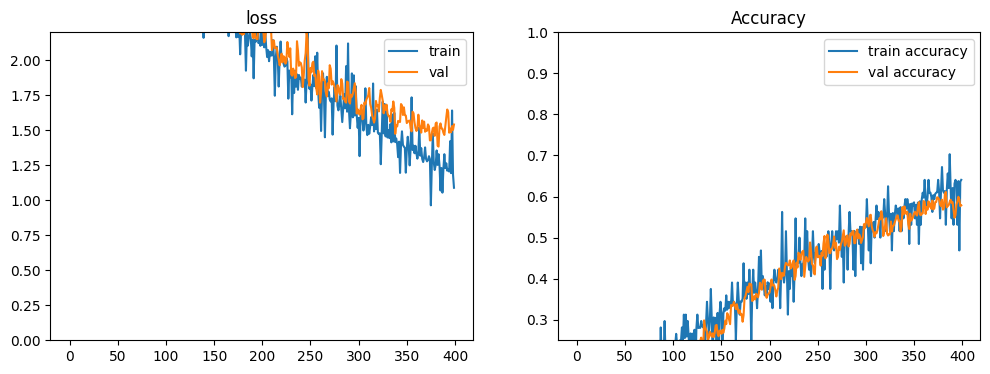

The accuracy is 58.6% compared to a chance level of 3.125%


In [49]:
plot_history(history)
plt.show()

res = data_aug_plus_droput_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

### Now testing dropout 20% with data augmentation

In [17]:
def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

data_aug_plus_droput_model = dropout_model()
# fit model
steps = int(train_images.shape[0] / 64)
history = data_aug_plus_droput_model.fit(train_flow, steps_per_epoch=steps, epochs=600, validation_data=validation_dataset)

Epoch 1/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 100s 434ms/step - accuracy: 0.0320 - loss: 3.8752 - val_accuracy: 0.0281 - val_loss: 3.4013
Epoch 2/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0469 - loss: 3.4049

2024-07-08 19:17:08.051159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:17:08.051230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 3.4049 - val_accuracy: 0.0281 - val_loss: 3.4012
Epoch 3/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.0356 - loss: 3.4011 - val_accuracy: 0.0288 - val_loss: 3.4014
Epoch 4/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.0312 - loss: 3.4012

2024-07-08 19:18:14.511841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:18:14.511909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:18:14.511949: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0312 - loss: 3.4012 - val_accuracy: 0.0275 - val_loss: 3.4014
Epoch 5/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.0354 - loss: 3.4014 - val_accuracy: 0.0288 - val_loss: 3.4015
Epoch 6/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.0312 - loss: 3.4021

2024-07-08 19:19:21.828889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:19:21.828939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0312 - loss: 3.4021 - val_accuracy: 0.0262 - val_loss: 3.4015
Epoch 7/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 337ms/step - accuracy: 0.0307 - loss: 3.4013 - val_accuracy: 0.0288 - val_loss: 3.4015
Epoch 8/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0156 - loss: 3.3998

2024-07-08 19:20:28.714170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:20:28.714236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0156 - loss: 3.3998 - val_accuracy: 0.0262 - val_loss: 3.4015
Epoch 9/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.0330 - loss: 3.4007 - val_accuracy: 0.0314 - val_loss: 3.4016
Epoch 10/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0156 - loss: 3.4039

2024-07-08 19:21:35.697903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:21:35.697958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0156 - loss: 3.4039 - val_accuracy: 0.0340 - val_loss: 3.4015
Epoch 11/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.0368 - loss: 3.4003 - val_accuracy: 0.0255 - val_loss: 3.4015
Epoch 12/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0312 - loss: 3.3948

2024-07-08 19:22:39.706740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:22:39.706808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:22:39.706858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0312 - loss: 3.3948 - val_accuracy: 0.0295 - val_loss: 3.4016
Epoch 13/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.0317 - loss: 3.3997 - val_accuracy: 0.0347 - val_loss: 3.4017
Epoch 14/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.0469 - loss: 3.4032

2024-07-08 19:23:47.360751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:23:47.360854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:23:47.360919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0469 - loss: 3.4032 - val_accuracy: 0.0360 - val_loss: 3.4017
Epoch 15/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - accuracy: 0.0393 - loss: 3.3986 - val_accuracy: 0.0301 - val_loss: 3.4001
Epoch 16/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0156 - loss: 3.4055

2024-07-08 19:24:53.708045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:24:53.708116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0156 - loss: 3.4055 - val_accuracy: 0.0288 - val_loss: 3.4001
Epoch 17/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 337ms/step - accuracy: 0.0391 - loss: 3.3922 - val_accuracy: 0.0380 - val_loss: 3.3883
Epoch 18/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0781 - loss: 3.3127

2024-07-08 19:26:00.500753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:26:00.500853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0781 - loss: 3.3127 - val_accuracy: 0.0347 - val_loss: 3.3878
Epoch 19/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.0443 - loss: 3.3862 - val_accuracy: 0.0537 - val_loss: 3.3888
Epoch 20/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0312 - loss: 3.3834

2024-07-08 19:27:05.011645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:27:05.011695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0312 - loss: 3.3834 - val_accuracy: 0.0497 - val_loss: 3.3896
Epoch 21/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.0508 - loss: 3.3775 - val_accuracy: 0.0668 - val_loss: 3.3845
Epoch 22/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.0938 - loss: 3.3290

2024-07-08 19:28:13.710755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:28:13.710825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 19:28:13.710847: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 19:28:13.710876: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0938 - loss: 3.3290 - val_accuracy: 0.0687 - val_loss: 3.3843
Epoch 23/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.0571 - loss: 3.3535 - val_accuracy: 0.0726 - val_loss: 3.3660
Epoch 24/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0469 - loss: 3.3801

2024-07-08 19:29:19.584867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:29:19.584952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:29:19.585032: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 3.3801 - val_accuracy: 0.0772 - val_loss: 3.3654
Epoch 25/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.0638 - loss: 3.3347 - val_accuracy: 0.0857 - val_loss: 3.3433
Epoch 26/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0781 - loss: 3.3414

2024-07-08 19:30:23.903025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:30:23.903076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0781 - loss: 3.3414 - val_accuracy: 0.0851 - val_loss: 3.3475
Epoch 27/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.0663 - loss: 3.3213 - val_accuracy: 0.0844 - val_loss: 3.3422
Epoch 28/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0469 - loss: 3.2742

2024-07-08 19:31:33.104199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:31:33.104284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 3.2742 - val_accuracy: 0.0766 - val_loss: 3.3412
Epoch 29/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.0693 - loss: 3.2996 - val_accuracy: 0.0903 - val_loss: 3.2998
Epoch 30/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0781 - loss: 3.1569

2024-07-08 19:32:37.914288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:32:37.914387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 19:32:37.914440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 19:32:37.914524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0781 - loss: 3.1569 - val_accuracy: 0.0870 - val_loss: 3.2974
Epoch 31/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.0794 - loss: 3.2744 - val_accuracy: 0.0988 - val_loss: 3.2839
Epoch 32/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0312 - loss: 3.3631

2024-07-08 19:33:42.505911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:33:42.505988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:33:42.506021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0312 - loss: 3.3631 - val_accuracy: 0.0936 - val_loss: 3.2796
Epoch 33/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.0763 - loss: 3.2699 - val_accuracy: 0.1008 - val_loss: 3.2485
Epoch 34/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0469 - loss: 3.2532

2024-07-08 19:34:46.881030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:34:46.881085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:34:46.881149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 3.2532 - val_accuracy: 0.1001 - val_loss: 3.2447
Epoch 35/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 366ms/step - accuracy: 0.0778 - loss: 3.2465 - val_accuracy: 0.1027 - val_loss: 3.2688
Epoch 36/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0625 - loss: 3.2637

2024-07-08 19:35:58.972138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:35:58.972467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 3.2637 - val_accuracy: 0.1014 - val_loss: 3.2686
Epoch 37/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.0698 - loss: 3.2464 - val_accuracy: 0.1021 - val_loss: 3.2291
Epoch 38/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1562 - loss: 3.1739

2024-07-08 19:37:03.716891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:37:03.716943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:37:03.716994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1562 - loss: 3.1739 - val_accuracy: 0.1014 - val_loss: 3.2177
Epoch 39/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.0765 - loss: 3.2470 - val_accuracy: 0.1073 - val_loss: 3.2331
Epoch 40/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0469 - loss: 3.2677

2024-07-08 19:38:08.002108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:38:08.002172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:38:08.002207: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 3.2677 - val_accuracy: 0.0982 - val_loss: 3.2246
Epoch 41/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.0824 - loss: 3.2284 - val_accuracy: 0.1047 - val_loss: 3.2226
Epoch 42/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0625 - loss: 3.2455

2024-07-08 19:39:17.312267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:39:17.312317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 3.2455 - val_accuracy: 0.1021 - val_loss: 3.2272
Epoch 43/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 327ms/step - accuracy: 0.0836 - loss: 3.2179 - val_accuracy: 0.0975 - val_loss: 3.2422
Epoch 44/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0625 - loss: 3.2286

2024-07-08 19:40:22.196536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:40:22.196618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:40:22.196708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 3.2286 - val_accuracy: 0.0995 - val_loss: 3.2412
Epoch 45/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 342ms/step - accuracy: 0.0823 - loss: 3.2117 - val_accuracy: 0.1001 - val_loss: 3.2318
Epoch 46/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1094 - loss: 3.1254

2024-07-08 19:41:30.494929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:41:30.494980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1094 - loss: 3.1254 - val_accuracy: 0.0955 - val_loss: 3.2361
Epoch 47/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.0806 - loss: 3.2028 - val_accuracy: 0.1139 - val_loss: 3.2039
Epoch 48/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.0469 - loss: 3.2581

2024-07-08 19:42:34.420877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:42:34.420954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 19:42:34.420990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 19:42:34.421024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0469 - loss: 3.2581 - val_accuracy: 0.1204 - val_loss: 3.2036
Epoch 49/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.0889 - loss: 3.1861 - val_accuracy: 0.1086 - val_loss: 3.2050
Epoch 50/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0156 - loss: 3.1800

2024-07-08 19:43:38.109944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:43:38.110008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:43:38.110057: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0156 - loss: 3.1800 - val_accuracy: 0.1014 - val_loss: 3.2136
Epoch 51/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.0984 - loss: 3.1771 - val_accuracy: 0.1361 - val_loss: 3.1856
Epoch 52/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.0625 - loss: 3.2503

2024-07-08 19:44:41.950093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:44:41.950289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 19:44:41.950349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 19:44:41.950393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 3.2503 - val_accuracy: 0.1387 - val_loss: 3.1907
Epoch 53/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 370ms/step - accuracy: 0.1012 - loss: 3.1668 - val_accuracy: 0.1224 - val_loss: 3.1498
Epoch 54/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.0625 - loss: 3.3015

2024-07-08 19:45:55.289022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:45:55.289084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 3.3015 - val_accuracy: 0.1178 - val_loss: 3.1479
Epoch 55/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.0963 - loss: 3.1559 - val_accuracy: 0.1217 - val_loss: 3.1942
Epoch 56/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.0469 - loss: 3.2595

2024-07-08 19:46:59.906683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:46:59.906735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 3.2595 - val_accuracy: 0.1381 - val_loss: 3.1846
Epoch 57/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.1030 - loss: 3.1298 - val_accuracy: 0.1263 - val_loss: 3.1448
Epoch 58/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1250 - loss: 3.0446

2024-07-08 19:48:03.698159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:48:03.698226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:48:03.698278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1250 - loss: 3.0446 - val_accuracy: 0.1342 - val_loss: 3.1452
Epoch 59/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.1038 - loss: 3.1413 - val_accuracy: 0.1479 - val_loss: 3.1041
Epoch 60/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1250 - loss: 3.1059

2024-07-08 19:49:13.909627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:49:13.909678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1250 - loss: 3.1059 - val_accuracy: 0.1342 - val_loss: 3.1058
Epoch 61/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.1079 - loss: 3.1204 - val_accuracy: 0.1355 - val_loss: 3.0974
Epoch 62/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1406 - loss: 3.2103

2024-07-08 19:50:18.311884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:50:18.311959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:50:18.311995: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1406 - loss: 3.2103 - val_accuracy: 0.1381 - val_loss: 3.0962
Epoch 63/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.1064 - loss: 3.1214 - val_accuracy: 0.1368 - val_loss: 3.0742
Epoch 64/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1406 - loss: 3.1632

2024-07-08 19:51:27.528716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:51:27.528823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1406 - loss: 3.1632 - val_accuracy: 0.1368 - val_loss: 3.0764
Epoch 65/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.1181 - loss: 3.0828 - val_accuracy: 0.1263 - val_loss: 3.0887
Epoch 66/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1875 - loss: 2.9767

2024-07-08 19:52:31.883295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:52:31.883362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1875 - loss: 2.9767 - val_accuracy: 0.1466 - val_loss: 3.0702
Epoch 67/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.1216 - loss: 3.0600 - val_accuracy: 0.1551 - val_loss: 3.0129
Epoch 68/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0625 - loss: 3.0835

2024-07-08 19:53:37.405568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:53:37.405662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 19:53:37.405703: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 19:53:37.405745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 3.0835 - val_accuracy: 0.1597 - val_loss: 3.0269
Epoch 69/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 342ms/step - accuracy: 0.1302 - loss: 3.0494 - val_accuracy: 0.1571 - val_loss: 3.0497
Epoch 70/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1094 - loss: 3.0489

2024-07-08 19:54:45.494654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:54:45.494709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1094 - loss: 3.0489 - val_accuracy: 0.1453 - val_loss: 3.0591
Epoch 71/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.1311 - loss: 3.0313 - val_accuracy: 0.1538 - val_loss: 2.9692
Epoch 72/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1406 - loss: 3.0453

2024-07-08 19:55:50.892848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:55:50.892952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:55:50.893001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1406 - loss: 3.0453 - val_accuracy: 0.1545 - val_loss: 2.9484
Epoch 73/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.1400 - loss: 3.0052 - val_accuracy: 0.1774 - val_loss: 2.9242
Epoch 74/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1094 - loss: 3.0555

2024-07-08 19:56:58.383350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:56:58.383399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1094 - loss: 3.0555 - val_accuracy: 0.1747 - val_loss: 2.9178
Epoch 75/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 327ms/step - accuracy: 0.1415 - loss: 2.9860 - val_accuracy: 0.1963 - val_loss: 2.9031
Epoch 76/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2031 - loss: 2.8829

2024-07-08 19:58:03.291872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:58:03.291918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2031 - loss: 2.8829 - val_accuracy: 0.1904 - val_loss: 2.9106
Epoch 77/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.1514 - loss: 2.9586 - val_accuracy: 0.1976 - val_loss: 2.8772
Epoch 78/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2656 - loss: 2.8055

2024-07-08 19:59:08.027208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:59:08.027283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 19:59:08.027343: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2656 - loss: 2.8055 - val_accuracy: 0.2101 - val_loss: 2.8757
Epoch 79/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 322ms/step - accuracy: 0.1560 - loss: 2.9366 - val_accuracy: 0.2048 - val_loss: 2.8562
Epoch 80/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1719 - loss: 2.9453

2024-07-08 20:00:11.716840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:00:11.716891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1719 - loss: 2.9453 - val_accuracy: 0.1963 - val_loss: 2.8754
Epoch 81/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.1731 - loss: 2.8919 - val_accuracy: 0.2003 - val_loss: 2.8851
Epoch 82/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2969 - loss: 2.6269

2024-07-08 20:01:15.302685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:01:15.302771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2969 - loss: 2.6269 - val_accuracy: 0.2055 - val_loss: 2.8709
Epoch 83/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 381ms/step - accuracy: 0.1633 - loss: 2.9087 - val_accuracy: 0.2009 - val_loss: 2.8348
Epoch 84/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.1406 - loss: 2.9954

2024-07-08 20:02:30.123053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:02:30.123355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1406 - loss: 2.9954 - val_accuracy: 0.2140 - val_loss: 2.8101
Epoch 85/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.1809 - loss: 2.8590 - val_accuracy: 0.2284 - val_loss: 2.7554
Epoch 86/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2031 - loss: 2.9353

2024-07-08 20:03:40.103913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:03:40.103977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2031 - loss: 2.9353 - val_accuracy: 0.2284 - val_loss: 2.7465
Epoch 87/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.1893 - loss: 2.8224 - val_accuracy: 0.2520 - val_loss: 2.7262
Epoch 88/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2031 - loss: 2.8179

2024-07-08 20:04:45.492349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:04:45.492480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:04:45.492553: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2031 - loss: 2.8179 - val_accuracy: 0.2487 - val_loss: 2.7406
Epoch 89/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - accuracy: 0.1968 - loss: 2.8058 - val_accuracy: 0.2448 - val_loss: 2.6724
Epoch 90/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3125 - loss: 2.7180

2024-07-08 20:05:52.012585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:05:52.012632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:05:52.012669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3125 - loss: 2.7180 - val_accuracy: 0.2408 - val_loss: 2.7022
Epoch 91/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 337ms/step - accuracy: 0.2002 - loss: 2.7926 - val_accuracy: 0.2461 - val_loss: 2.7085
Epoch 92/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1094 - loss: 2.8289

2024-07-08 20:06:58.611082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:06:58.611143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:06:58.611177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1094 - loss: 2.8289 - val_accuracy: 0.2644 - val_loss: 2.7012
Epoch 93/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.2121 - loss: 2.7580 - val_accuracy: 0.2467 - val_loss: 2.6807
Epoch 94/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2344 - loss: 2.7460

2024-07-08 20:08:04.593560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:08:04.593645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:08:04.593681: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2344 - loss: 2.7460 - val_accuracy: 0.2513 - val_loss: 2.6729
Epoch 95/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.2171 - loss: 2.7328 - val_accuracy: 0.2559 - val_loss: 2.6262
Epoch 96/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3125 - loss: 2.5959

2024-07-08 20:09:09.527923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:09:09.527974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3125 - loss: 2.5959 - val_accuracy: 0.2480 - val_loss: 2.6408
Epoch 97/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.2141 - loss: 2.7207 - val_accuracy: 0.2873 - val_loss: 2.5920
Epoch 98/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2031 - loss: 2.8474

2024-07-08 20:10:15.102400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:10:15.102471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:10:15.102531: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2031 - loss: 2.8474 - val_accuracy: 0.2749 - val_loss: 2.5991
Epoch 99/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.2262 - loss: 2.6918 - val_accuracy: 0.2847 - val_loss: 2.5460
Epoch 100/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2344 - loss: 2.4081

2024-07-08 20:11:19.499137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:11:19.499191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2344 - loss: 2.4081 - val_accuracy: 0.2821 - val_loss: 2.5542
Epoch 101/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.2398 - loss: 2.6524 - val_accuracy: 0.2775 - val_loss: 2.5824
Epoch 102/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2188 - loss: 2.6766

2024-07-08 20:12:23.617466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:12:23.617516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:12:23.617580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2188 - loss: 2.6766 - val_accuracy: 0.2932 - val_loss: 2.5633
Epoch 103/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 361ms/step - accuracy: 0.2400 - loss: 2.6490 - val_accuracy: 0.3024 - val_loss: 2.5073
Epoch 104/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2500 - loss: 2.5829

2024-07-08 20:13:34.823302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:13:34.823356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 20:13:34.823377: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 20:13:34.823405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2500 - loss: 2.5829 - val_accuracy: 0.2991 - val_loss: 2.5238
Epoch 105/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 341ms/step - accuracy: 0.2511 - loss: 2.6323 - val_accuracy: 0.2893 - val_loss: 2.5335
Epoch 106/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.1875 - loss: 2.6900

2024-07-08 20:14:42.816788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:14:42.816847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1875 - loss: 2.6900 - val_accuracy: 0.3024 - val_loss: 2.5097
Epoch 107/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.2707 - loss: 2.5629 - val_accuracy: 0.3063 - val_loss: 2.4687
Epoch 108/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1719 - loss: 2.6326

2024-07-08 20:15:50.927561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:15:50.927629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1719 - loss: 2.6326 - val_accuracy: 0.3233 - val_loss: 2.4537
Epoch 109/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.2619 - loss: 2.5722 - val_accuracy: 0.3135 - val_loss: 2.4450
Epoch 110/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.1719 - loss: 2.7737

2024-07-08 20:16:57.014358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:16:57.014417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1719 - loss: 2.7737 - val_accuracy: 0.3298 - val_loss: 2.4070
Epoch 111/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.2750 - loss: 2.5355 - val_accuracy: 0.3364 - val_loss: 2.4233
Epoch 112/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2812 - loss: 2.5933

2024-07-08 20:18:01.801172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:18:01.801238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2812 - loss: 2.5933 - val_accuracy: 0.3455 - val_loss: 2.4257
Epoch 113/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 327ms/step - accuracy: 0.2683 - loss: 2.5500 - val_accuracy: 0.3403 - val_loss: 2.3360
Epoch 114/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3594 - loss: 2.5905

2024-07-08 20:19:06.709961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:19:06.710021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3594 - loss: 2.5905 - val_accuracy: 0.3292 - val_loss: 2.3589
Epoch 115/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.2897 - loss: 2.4765 - val_accuracy: 0.3174 - val_loss: 2.3925
Epoch 116/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2656 - loss: 2.5223

2024-07-08 20:20:12.322856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:20:12.322924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2656 - loss: 2.5223 - val_accuracy: 0.3082 - val_loss: 2.4256
Epoch 117/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 359ms/step - accuracy: 0.2946 - loss: 2.4460 - val_accuracy: 0.3298 - val_loss: 2.3597
Epoch 118/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2500 - loss: 2.5033

2024-07-08 20:21:23.717812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:21:23.717872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 20:21:23.717902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 20:21:23.717936: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2500 - loss: 2.5033 - val_accuracy: 0.3292 - val_loss: 2.3607
Epoch 119/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.2956 - loss: 2.4514 - val_accuracy: 0.3089 - val_loss: 2.3599
Epoch 120/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2188 - loss: 2.6720

2024-07-08 20:22:30.117188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:22:30.117239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:22:30.117286: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2188 - loss: 2.6720 - val_accuracy: 0.3024 - val_loss: 2.3781
Epoch 121/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.2957 - loss: 2.4450 - val_accuracy: 0.3514 - val_loss: 2.2548
Epoch 122/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2969 - loss: 2.4477

2024-07-08 20:23:36.218852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:23:36.218905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2969 - loss: 2.4477 - val_accuracy: 0.3495 - val_loss: 2.2434
Epoch 123/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.3212 - loss: 2.3745 - val_accuracy: 0.3554 - val_loss: 2.2688
Epoch 124/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2344 - loss: 2.6762

2024-07-08 20:24:40.480241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:24:40.480308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2344 - loss: 2.6762 - val_accuracy: 0.3488 - val_loss: 2.3106
Epoch 125/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.3066 - loss: 2.4171 - val_accuracy: 0.3370 - val_loss: 2.3238
Epoch 126/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3281 - loss: 2.2218

2024-07-08 20:25:49.415103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:25:49.415161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:25:49.415207: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3281 - loss: 2.2218 - val_accuracy: 0.3384 - val_loss: 2.3218
Epoch 127/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.3092 - loss: 2.3719 - val_accuracy: 0.3802 - val_loss: 2.1839
Epoch 128/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4062 - loss: 2.2089

2024-07-08 20:26:54.841626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:26:54.841724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:26:54.841792: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4062 - loss: 2.2089 - val_accuracy: 0.3822 - val_loss: 2.1796
Epoch 129/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.3237 - loss: 2.3265 - val_accuracy: 0.3344 - val_loss: 2.3048
Epoch 130/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3438 - loss: 2.3786

2024-07-08 20:28:00.520039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:28:00.520091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3438 - loss: 2.3786 - val_accuracy: 0.3671 - val_loss: 2.2202
Epoch 131/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.3221 - loss: 2.3498 - val_accuracy: 0.3698 - val_loss: 2.1820
Epoch 132/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3906 - loss: 2.0296

2024-07-08 20:29:04.798001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:29:04.798063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3906 - loss: 2.0296 - val_accuracy: 0.3894 - val_loss: 2.1325
Epoch 133/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 348ms/step - accuracy: 0.3288 - loss: 2.3155 - val_accuracy: 0.3599 - val_loss: 2.2351
Epoch 134/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3594 - loss: 2.0773

2024-07-08 20:30:13.540090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:30:13.540192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3594 - loss: 2.0773 - val_accuracy: 0.3737 - val_loss: 2.1789
Epoch 135/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.3459 - loss: 2.2641 - val_accuracy: 0.3933 - val_loss: 2.0940
Epoch 136/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4062 - loss: 2.0840

2024-07-08 20:31:18.109463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:31:18.109512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:31:18.109547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4062 - loss: 2.0840 - val_accuracy: 0.3940 - val_loss: 2.1281
Epoch 137/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.3517 - loss: 2.2481 - val_accuracy: 0.4012 - val_loss: 2.0897
Epoch 138/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3594 - loss: 2.2900

2024-07-08 20:32:22.715932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:32:22.716009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3594 - loss: 2.2900 - val_accuracy: 0.4130 - val_loss: 2.0519
Epoch 139/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.3582 - loss: 2.2382 - val_accuracy: 0.4012 - val_loss: 2.1040
Epoch 140/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2031 - loss: 2.6888

2024-07-08 20:33:30.216696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:33:30.216759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2031 - loss: 2.6888 - val_accuracy: 0.4143 - val_loss: 2.0607
Epoch 141/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.3613 - loss: 2.2081 - val_accuracy: 0.4247 - val_loss: 2.0233
Epoch 142/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3750 - loss: 2.2043

2024-07-08 20:34:34.112686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:34:34.112754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3750 - loss: 2.2043 - val_accuracy: 0.4136 - val_loss: 2.0593
Epoch 143/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.3674 - loss: 2.1870 - val_accuracy: 0.4130 - val_loss: 2.0797
Epoch 144/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3281 - loss: 2.3391

2024-07-08 20:35:43.294243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:35:43.294305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3281 - loss: 2.3391 - val_accuracy: 0.4280 - val_loss: 2.0386
Epoch 145/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - accuracy: 0.3771 - loss: 2.1459 - val_accuracy: 0.4444 - val_loss: 1.9292
Epoch 146/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3281 - loss: 2.2148

2024-07-08 20:36:49.322490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:36:49.322540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3281 - loss: 2.2148 - val_accuracy: 0.4411 - val_loss: 1.9458
Epoch 147/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.3757 - loss: 2.1546 - val_accuracy: 0.4346 - val_loss: 1.9985
Epoch 148/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3906 - loss: 2.1878

2024-07-08 20:37:54.659549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 20:37:54.659594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3906 - loss: 2.1878 - val_accuracy: 0.4274 - val_loss: 2.0156
Epoch 149/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 343ms/step - accuracy: 0.3927 - loss: 2.1047 - val_accuracy: 0.4352 - val_loss: 1.9512
Epoch 150/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4688 - loss: 2.1905

2024-07-08 20:39:02.415273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:39:02.415339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 2.1905 - val_accuracy: 0.4267 - val_loss: 1.9643
Epoch 151/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.3870 - loss: 2.0898 - val_accuracy: 0.4267 - val_loss: 1.9575
Epoch 152/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.3281 - loss: 2.5132

2024-07-08 20:40:09.813244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:40:09.813297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:40:09.813350: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3281 - loss: 2.5132 - val_accuracy: 0.4372 - val_loss: 1.9422
Epoch 153/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.3950 - loss: 2.0739 - val_accuracy: 0.4503 - val_loss: 1.8994
Epoch 154/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3125 - loss: 2.7319

2024-07-08 20:41:14.217832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:41:14.217905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:41:14.217983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3125 - loss: 2.7319 - val_accuracy: 0.4476 - val_loss: 1.8991
Epoch 155/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.4029 - loss: 2.0898 - val_accuracy: 0.4601 - val_loss: 1.8399
Epoch 156/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3906 - loss: 2.0525

2024-07-08 20:42:19.718685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:42:19.718753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:42:19.718797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3906 - loss: 2.0525 - val_accuracy: 0.4581 - val_loss: 1.8759
Epoch 157/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.4115 - loss: 2.0235 - val_accuracy: 0.4483 - val_loss: 1.9198
Epoch 158/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6094 - loss: 1.7789

2024-07-08 20:43:26.694330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:43:26.694384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 1.7789 - val_accuracy: 0.4535 - val_loss: 1.8901
Epoch 159/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.4296 - loss: 1.9920 - val_accuracy: 0.4581 - val_loss: 1.8707
Epoch 160/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4531 - loss: 1.8291

2024-07-08 20:44:33.016583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:44:33.016648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:44:33.016687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4531 - loss: 1.8291 - val_accuracy: 0.4581 - val_loss: 1.8807
Epoch 161/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.4315 - loss: 1.9687 - val_accuracy: 0.4804 - val_loss: 1.8058
Epoch 162/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4375 - loss: 2.0007

2024-07-08 20:45:41.330883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:45:41.330932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:45:41.331009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4375 - loss: 2.0007 - val_accuracy: 0.4836 - val_loss: 1.7977
Epoch 163/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 359ms/step - accuracy: 0.4238 - loss: 2.0138 - val_accuracy: 0.5000 - val_loss: 1.7598
Epoch 164/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4219 - loss: 2.0044

2024-07-08 20:46:53.111480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:46:53.111567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4219 - loss: 2.0044 - val_accuracy: 0.4967 - val_loss: 1.7538
Epoch 165/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.4380 - loss: 1.9358 - val_accuracy: 0.4653 - val_loss: 1.8706
Epoch 166/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3906 - loss: 1.8752

2024-07-08 20:47:58.293484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:47:58.293541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3906 - loss: 1.8752 - val_accuracy: 0.4771 - val_loss: 1.8148
Epoch 167/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.4313 - loss: 1.9341 - val_accuracy: 0.4863 - val_loss: 1.7336
Epoch 168/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4062 - loss: 2.1297

2024-07-08 20:49:03.610031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:49:03.610077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4062 - loss: 2.1297 - val_accuracy: 0.4797 - val_loss: 1.7711
Epoch 169/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.4390 - loss: 1.9109 - val_accuracy: 0.4836 - val_loss: 1.7905
Epoch 170/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4375 - loss: 1.9051

2024-07-08 20:50:07.902562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:50:07.902613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:50:07.902650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4375 - loss: 1.9051 - val_accuracy: 0.4921 - val_loss: 1.7883
Epoch 171/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.4515 - loss: 1.8671 - val_accuracy: 0.5059 - val_loss: 1.7259
Epoch 172/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4062 - loss: 2.0082

2024-07-08 20:51:12.115904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:51:12.115951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4062 - loss: 2.0082 - val_accuracy: 0.5098 - val_loss: 1.7196
Epoch 173/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.4490 - loss: 1.8630 - val_accuracy: 0.5059 - val_loss: 1.7796
Epoch 174/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4688 - loss: 1.6290

2024-07-08 20:52:17.304741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:52:17.304853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:52:17.304888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 1.6290 - val_accuracy: 0.4993 - val_loss: 1.7647
Epoch 175/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 384ms/step - accuracy: 0.4659 - loss: 1.8405 - val_accuracy: 0.5190 - val_loss: 1.6690
Epoch 176/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4688 - loss: 1.9060

2024-07-08 20:53:32.840582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:53:32.840751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:53:32.840888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4688 - loss: 1.9060 - val_accuracy: 0.5190 - val_loss: 1.6629
Epoch 177/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 377ms/step - accuracy: 0.4697 - loss: 1.8305 - val_accuracy: 0.5118 - val_loss: 1.7057
Epoch 178/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5000 - loss: 1.9767

2024-07-08 20:54:47.621926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:54:47.622007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 1.9767 - val_accuracy: 0.5098 - val_loss: 1.7240
Epoch 179/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.4799 - loss: 1.8005 - val_accuracy: 0.5255 - val_loss: 1.6822
Epoch 180/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5781 - loss: 1.6178

2024-07-08 20:55:53.815038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:55:53.815105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.6178 - val_accuracy: 0.5203 - val_loss: 1.7104
Epoch 181/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.4808 - loss: 1.7776 - val_accuracy: 0.5157 - val_loss: 1.7232
Epoch 182/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5312 - loss: 1.4567

2024-07-08 20:56:58.218526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:56:58.218591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:56:58.218643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5312 - loss: 1.4567 - val_accuracy: 0.5203 - val_loss: 1.7050
Epoch 183/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.4823 - loss: 1.7435 - val_accuracy: 0.5321 - val_loss: 1.5773
Epoch 184/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4375 - loss: 2.1215

2024-07-08 20:58:02.521084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:58:02.521164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4375 - loss: 2.1215 - val_accuracy: 0.5432 - val_loss: 1.5863
Epoch 185/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.4930 - loss: 1.7275 - val_accuracy: 0.5497 - val_loss: 1.5992
Epoch 186/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5000 - loss: 1.5529

2024-07-08 20:59:07.502756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:59:07.502821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 20:59:07.502856: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5000 - loss: 1.5529 - val_accuracy: 0.5425 - val_loss: 1.6035
Epoch 187/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.4918 - loss: 1.7096 - val_accuracy: 0.5334 - val_loss: 1.6235
Epoch 188/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5156 - loss: 1.8738

2024-07-08 21:00:11.101422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:00:11.101470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5156 - loss: 1.8738 - val_accuracy: 0.5491 - val_loss: 1.5911
Epoch 189/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.5017 - loss: 1.6966 - val_accuracy: 0.5543 - val_loss: 1.5886
Epoch 190/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4531 - loss: 1.6355

2024-07-08 21:01:15.099409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:01:15.099454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4531 - loss: 1.6355 - val_accuracy: 0.5491 - val_loss: 1.6131
Epoch 191/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.5172 - loss: 1.6426 - val_accuracy: 0.5458 - val_loss: 1.6010
Epoch 192/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5469 - loss: 1.8416

2024-07-08 21:02:18.794782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:02:18.794841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5469 - loss: 1.8416 - val_accuracy: 0.5438 - val_loss: 1.6253
Epoch 193/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.5154 - loss: 1.6519 - val_accuracy: 0.5707 - val_loss: 1.5527
Epoch 194/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5781 - loss: 1.6408

2024-07-08 21:03:28.098306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:03:28.098424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:03:28.098465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.6408 - val_accuracy: 0.5569 - val_loss: 1.5692
Epoch 195/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 370ms/step - accuracy: 0.5203 - loss: 1.6197 - val_accuracy: 0.5484 - val_loss: 1.5737
Epoch 196/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4062 - loss: 1.7792

2024-07-08 21:04:41.384339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:04:41.384463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4062 - loss: 1.7792 - val_accuracy: 0.5615 - val_loss: 1.5746
Epoch 197/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 337ms/step - accuracy: 0.5209 - loss: 1.6260 - val_accuracy: 0.5569 - val_loss: 1.5375
Epoch 198/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5156 - loss: 1.4793

2024-07-08 21:05:48.309367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:05:48.309434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5156 - loss: 1.4793 - val_accuracy: 0.5628 - val_loss: 1.5113
Epoch 199/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 327ms/step - accuracy: 0.5310 - loss: 1.5831 - val_accuracy: 0.5340 - val_loss: 1.5945
Epoch 200/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5625 - loss: 1.5339

2024-07-08 21:06:53.064464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:06:53.064540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:06:53.064576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5625 - loss: 1.5339 - val_accuracy: 0.5281 - val_loss: 1.6204
Epoch 201/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.5361 - loss: 1.5826 - val_accuracy: 0.5707 - val_loss: 1.5204
Epoch 202/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4531 - loss: 1.6786

2024-07-08 21:07:56.317553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:07:56.317620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4531 - loss: 1.6786 - val_accuracy: 0.5582 - val_loss: 1.5397
Epoch 203/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.5395 - loss: 1.5413 - val_accuracy: 0.5687 - val_loss: 1.5301
Epoch 204/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4688 - loss: 1.8702

2024-07-08 21:09:00.721529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:09:00.721600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 1.8702 - val_accuracy: 0.5733 - val_loss: 1.4678
Epoch 205/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.5505 - loss: 1.5205 - val_accuracy: 0.6021 - val_loss: 1.4140
Epoch 206/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5000 - loss: 1.7038

2024-07-08 21:10:05.017019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:10:05.017108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 1.7038 - val_accuracy: 0.5949 - val_loss: 1.4432
Epoch 207/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.5502 - loss: 1.5299 - val_accuracy: 0.5792 - val_loss: 1.5024
Epoch 208/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6094 - loss: 1.2378

2024-07-08 21:11:09.113330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:11:09.113377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 1.2378 - val_accuracy: 0.5864 - val_loss: 1.4692
Epoch 209/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.5534 - loss: 1.4881 - val_accuracy: 0.5654 - val_loss: 1.5370
Epoch 210/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5469 - loss: 1.6980

2024-07-08 21:12:13.089429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:12:13.089488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:12:13.089548: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5469 - loss: 1.6980 - val_accuracy: 0.5936 - val_loss: 1.4658
Epoch 211/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 343ms/step - accuracy: 0.5568 - loss: 1.4821 - val_accuracy: 0.5988 - val_loss: 1.4117
Epoch 212/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5000 - loss: 1.5069

2024-07-08 21:13:20.853478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:13:20.853561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 1.5069 - val_accuracy: 0.5923 - val_loss: 1.4206
Epoch 213/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 379ms/step - accuracy: 0.5634 - loss: 1.4603 - val_accuracy: 0.5877 - val_loss: 1.4762
Epoch 214/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5312 - loss: 1.8253

2024-07-08 21:14:35.931693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:14:35.931931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5312 - loss: 1.8253 - val_accuracy: 0.5955 - val_loss: 1.4730
Epoch 215/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.5580 - loss: 1.4503 - val_accuracy: 0.5785 - val_loss: 1.4555
Epoch 216/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4844 - loss: 1.8362

2024-07-08 21:15:43.577773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:15:43.577833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:15:43.577880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4844 - loss: 1.8362 - val_accuracy: 0.5897 - val_loss: 1.4223
Epoch 217/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.5815 - loss: 1.4069 - val_accuracy: 0.6119 - val_loss: 1.3831
Epoch 218/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6250 - loss: 1.1646

2024-07-08 21:16:47.811391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:16:47.811454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 1.1646 - val_accuracy: 0.6152 - val_loss: 1.3659
Epoch 219/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.5775 - loss: 1.3964 - val_accuracy: 0.5962 - val_loss: 1.4083
Epoch 220/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4844 - loss: 1.3994

2024-07-08 21:17:51.406296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:17:51.406365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4844 - loss: 1.3994 - val_accuracy: 0.6027 - val_loss: 1.3783
Epoch 221/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.5824 - loss: 1.3930 - val_accuracy: 0.6008 - val_loss: 1.4046
Epoch 222/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5625 - loss: 1.4010

2024-07-08 21:18:59.624026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:18:59.624138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5625 - loss: 1.4010 - val_accuracy: 0.6054 - val_loss: 1.3736
Epoch 223/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.5873 - loss: 1.3816 - val_accuracy: 0.5877 - val_loss: 1.4349
Epoch 224/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7188 - loss: 1.1767

2024-07-08 21:20:10.015523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:20:10.015580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 1.1767 - val_accuracy: 0.5903 - val_loss: 1.4394
Epoch 225/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.5877 - loss: 1.3761 - val_accuracy: 0.6191 - val_loss: 1.3586
Epoch 226/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5781 - loss: 1.4566

2024-07-08 21:21:13.711290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:21:13.711349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.4566 - val_accuracy: 0.6355 - val_loss: 1.3550
Epoch 227/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.5945 - loss: 1.3595 - val_accuracy: 0.5884 - val_loss: 1.4762
Epoch 228/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5469 - loss: 1.4247

2024-07-08 21:22:17.711887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:22:17.711967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5469 - loss: 1.4247 - val_accuracy: 0.5890 - val_loss: 1.5101
Epoch 229/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.5862 - loss: 1.3612 - val_accuracy: 0.6335 - val_loss: 1.3264
Epoch 230/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5156 - loss: 1.5068

2024-07-08 21:23:21.238877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:23:21.238952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:23:21.239021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5156 - loss: 1.5068 - val_accuracy: 0.6342 - val_loss: 1.3544
Epoch 231/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 360ms/step - accuracy: 0.6113 - loss: 1.2850 - val_accuracy: 0.6145 - val_loss: 1.3763
Epoch 232/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5625 - loss: 1.2549

2024-07-08 21:24:32.513201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:24:32.513270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:24:32.513331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5625 - loss: 1.2549 - val_accuracy: 0.6243 - val_loss: 1.3118
Epoch 233/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.6180 - loss: 1.2683 - val_accuracy: 0.6224 - val_loss: 1.3498
Epoch 234/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6250 - loss: 1.1976

2024-07-08 21:25:36.203169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:25:36.203226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 1.1976 - val_accuracy: 0.6185 - val_loss: 1.3431
Epoch 235/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - accuracy: 0.6089 - loss: 1.2806 - val_accuracy: 0.5844 - val_loss: 1.4327
Epoch 236/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5781 - loss: 1.4819

2024-07-08 21:26:40.214261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 21:26:40.214308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.4819 - val_accuracy: 0.5825 - val_loss: 1.4198
Epoch 237/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.6088 - loss: 1.2589 - val_accuracy: 0.6322 - val_loss: 1.3214
Epoch 238/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6250 - loss: 1.3331

2024-07-08 21:27:43.706683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:27:43.706750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 1.3331 - val_accuracy: 0.6335 - val_loss: 1.3423
Epoch 239/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 355ms/step - accuracy: 0.6343 - loss: 1.2033 - val_accuracy: 0.6243 - val_loss: 1.3521
Epoch 240/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7031 - loss: 1.0556

2024-07-08 21:28:53.735003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:28:53.735078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 1.0556 - val_accuracy: 0.6322 - val_loss: 1.3175
Epoch 241/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.6328 - loss: 1.2215 - val_accuracy: 0.6276 - val_loss: 1.3108
Epoch 242/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4844 - loss: 1.5360

2024-07-08 21:30:00.580526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:30:00.580587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:30:00.580624: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4844 - loss: 1.5360 - val_accuracy: 0.6368 - val_loss: 1.2766
Epoch 243/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.6258 - loss: 1.2166 - val_accuracy: 0.6158 - val_loss: 1.3660
Epoch 244/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6094 - loss: 1.1839

2024-07-08 21:31:05.015876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:31:05.015970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 21:31:05.016004: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 21:31:05.016050: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 1.1839 - val_accuracy: 0.6191 - val_loss: 1.3609
Epoch 245/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.6393 - loss: 1.1851 - val_accuracy: 0.6276 - val_loss: 1.2890
Epoch 246/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5781 - loss: 1.4433

2024-07-08 21:32:11.005875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:32:11.005935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.4433 - val_accuracy: 0.6257 - val_loss: 1.3039
Epoch 247/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.6403 - loss: 1.1790 - val_accuracy: 0.6440 - val_loss: 1.2593
Epoch 248/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5781 - loss: 1.2574

2024-07-08 21:33:15.699898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:33:15.699968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5781 - loss: 1.2574 - val_accuracy: 0.6394 - val_loss: 1.3011
Epoch 249/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.6379 - loss: 1.1803 - val_accuracy: 0.6492 - val_loss: 1.2595
Epoch 250/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5312 - loss: 1.7112

2024-07-08 21:34:22.325080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:34:22.325148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 21:34:22.325188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 21:34:22.325245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5312 - loss: 1.7112 - val_accuracy: 0.6545 - val_loss: 1.2428
Epoch 251/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.6469 - loss: 1.1550 - val_accuracy: 0.6387 - val_loss: 1.2642
Epoch 252/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7344 - loss: 1.1211

2024-07-08 21:35:26.712494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:35:26.712546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 1.1211 - val_accuracy: 0.6315 - val_loss: 1.2872
Epoch 253/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.6438 - loss: 1.1465 - val_accuracy: 0.6204 - val_loss: 1.3335
Epoch 254/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6562 - loss: 1.2405

2024-07-08 21:36:32.611326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:36:32.611391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 1.2405 - val_accuracy: 0.6368 - val_loss: 1.2920
Epoch 255/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.6537 - loss: 1.1188 - val_accuracy: 0.6518 - val_loss: 1.2696
Epoch 256/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6094 - loss: 1.3933

2024-07-08 21:37:43.018669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:37:43.018730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:37:43.018777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 1.3933 - val_accuracy: 0.6597 - val_loss: 1.2386
Epoch 257/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.6502 - loss: 1.1325 - val_accuracy: 0.6616 - val_loss: 1.2270
Epoch 258/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 0.9009

2024-07-08 21:38:50.825429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:38:50.825507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:38:50.825557: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 0.9009 - val_accuracy: 0.6675 - val_loss: 1.2051
Epoch 259/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.6570 - loss: 1.1143 - val_accuracy: 0.6577 - val_loss: 1.2219
Epoch 260/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6094 - loss: 1.1161

2024-07-08 21:39:56.195115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:39:56.195262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 1.1161 - val_accuracy: 0.6571 - val_loss: 1.1880
Epoch 261/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.6575 - loss: 1.0930 - val_accuracy: 0.6538 - val_loss: 1.2779
Epoch 262/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6875 - loss: 1.0905

2024-07-08 21:41:02.202824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:41:02.202871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:41:02.202918: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 1.0905 - val_accuracy: 0.6545 - val_loss: 1.2439
Epoch 263/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.6628 - loss: 1.0877 - val_accuracy: 0.6374 - val_loss: 1.3979
Epoch 264/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7188 - loss: 0.9336

2024-07-08 21:42:06.910653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:42:06.910740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:42:06.910791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 0.9336 - val_accuracy: 0.6486 - val_loss: 1.3402
Epoch 265/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.6677 - loss: 1.0616 - val_accuracy: 0.6394 - val_loss: 1.2431
Epoch 266/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6875 - loss: 1.1298

2024-07-08 21:43:13.112978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:43:13.113033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:43:13.113069: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 1.1298 - val_accuracy: 0.6368 - val_loss: 1.2728
Epoch 267/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.6750 - loss: 1.0415 - val_accuracy: 0.6512 - val_loss: 1.2576
Epoch 268/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6875 - loss: 0.8116

2024-07-08 21:44:17.513474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:44:17.513530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.8116 - val_accuracy: 0.6479 - val_loss: 1.3064
Epoch 269/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 366ms/step - accuracy: 0.6706 - loss: 1.0633 - val_accuracy: 0.6636 - val_loss: 1.2050
Epoch 270/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6094 - loss: 1.1761

2024-07-08 21:45:29.689144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:45:29.689249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:45:29.689303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 1.1761 - val_accuracy: 0.6597 - val_loss: 1.2217
Epoch 271/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 382ms/step - accuracy: 0.6809 - loss: 1.0152 - val_accuracy: 0.6832 - val_loss: 1.1809
Epoch 272/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6875 - loss: 1.1721

2024-07-08 21:46:45.543441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:46:45.543505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6875 - loss: 1.1721 - val_accuracy: 0.6780 - val_loss: 1.2173
Epoch 273/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.6859 - loss: 1.0162 - val_accuracy: 0.6688 - val_loss: 1.2019
Epoch 274/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7031 - loss: 0.7748

2024-07-08 21:47:50.725208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:47:50.725256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 0.7748 - val_accuracy: 0.6643 - val_loss: 1.2390
Epoch 275/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.6897 - loss: 0.9843 - val_accuracy: 0.6721 - val_loss: 1.1944
Epoch 276/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4688 - loss: 1.4719

2024-07-08 21:48:55.412526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:48:55.412574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 1.4719 - val_accuracy: 0.6695 - val_loss: 1.2144
Epoch 277/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.6928 - loss: 0.9773 - val_accuracy: 0.6623 - val_loss: 1.2641
Epoch 278/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 1.0065

2024-07-08 21:49:58.698935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:49:58.698988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 1.0065 - val_accuracy: 0.6636 - val_loss: 1.2510
Epoch 279/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.6877 - loss: 0.9869 - val_accuracy: 0.6623 - val_loss: 1.2392
Epoch 280/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6719 - loss: 0.9141

2024-07-08 21:51:02.403987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:51:02.404042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 0.9141 - val_accuracy: 0.6616 - val_loss: 1.2441
Epoch 281/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.7045 - loss: 0.9396 - val_accuracy: 0.6747 - val_loss: 1.2391
Epoch 282/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 0.8960

2024-07-08 21:52:05.705957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:52:05.706063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 0.8960 - val_accuracy: 0.6695 - val_loss: 1.2620
Epoch 283/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.7072 - loss: 0.9343 - val_accuracy: 0.6747 - val_loss: 1.2144
Epoch 284/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7031 - loss: 0.9912

2024-07-08 21:53:09.396524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 21:53:09.396583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 0.9912 - val_accuracy: 0.6708 - val_loss: 1.2153
Epoch 285/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.7082 - loss: 0.9234 - val_accuracy: 0.6990 - val_loss: 1.1388
Epoch 286/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6875 - loss: 0.9488

2024-07-08 21:54:14.736537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:54:14.736613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.9488 - val_accuracy: 0.6937 - val_loss: 1.1733
Epoch 287/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 372ms/step - accuracy: 0.7076 - loss: 0.9374 - val_accuracy: 0.6963 - val_loss: 1.1653
Epoch 288/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7500 - loss: 0.8827

2024-07-08 21:55:28.322617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:55:28.322779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.8827 - val_accuracy: 0.6918 - val_loss: 1.1600
Epoch 289/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.7115 - loss: 0.9233 - val_accuracy: 0.6957 - val_loss: 1.1966
Epoch 290/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7344 - loss: 0.8987

2024-07-08 21:56:37.306957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:56:37.307034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 0.8987 - val_accuracy: 0.6983 - val_loss: 1.1611
Epoch 291/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.7066 - loss: 0.9229 - val_accuracy: 0.6904 - val_loss: 1.1832
Epoch 292/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7500 - loss: 0.9484

2024-07-08 21:57:41.392858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:57:41.392991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 21:57:41.393116: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.9484 - val_accuracy: 0.6996 - val_loss: 1.1617
Epoch 293/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.7147 - loss: 0.8873 - val_accuracy: 0.6832 - val_loss: 1.1927
Epoch 294/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7344 - loss: 0.7948

2024-07-08 21:58:45.608843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:58:45.608903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 0.7948 - val_accuracy: 0.6623 - val_loss: 1.3205
Epoch 295/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.7190 - loss: 0.8947 - val_accuracy: 0.6891 - val_loss: 1.2084
Epoch 296/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7656 - loss: 1.0051

2024-07-08 21:59:50.107627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:59:50.107730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 1.0051 - val_accuracy: 0.6826 - val_loss: 1.2013
Epoch 297/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.7104 - loss: 0.9006 - val_accuracy: 0.6911 - val_loss: 1.1822
Epoch 298/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7031 - loss: 0.9796

2024-07-08 22:00:54.115446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:00:54.115510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 0.9796 - val_accuracy: 0.6898 - val_loss: 1.1868
Epoch 299/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.7221 - loss: 0.8556 - val_accuracy: 0.6885 - val_loss: 1.1852
Epoch 300/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7031 - loss: 0.8049

2024-07-08 22:01:58.284582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:01:58.284646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:01:58.284680: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7031 - loss: 0.8049 - val_accuracy: 0.6911 - val_loss: 1.1773
Epoch 301/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.7289 - loss: 0.8424 - val_accuracy: 0.6859 - val_loss: 1.2431
Epoch 302/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6562 - loss: 1.0060

2024-07-08 22:03:02.605644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:03:02.605702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 1.0060 - val_accuracy: 0.6918 - val_loss: 1.2567
Epoch 303/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.7253 - loss: 0.8449 - val_accuracy: 0.6721 - val_loss: 1.2419
Epoch 304/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7188 - loss: 1.0535

2024-07-08 22:04:06.811437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:04:06.811519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 1.0535 - val_accuracy: 0.6708 - val_loss: 1.2381
Epoch 305/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.7322 - loss: 0.8434 - val_accuracy: 0.6682 - val_loss: 1.2619
Epoch 306/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8125 - loss: 0.6575

2024-07-08 22:05:10.793180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:05:10.793271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.6575 - val_accuracy: 0.6819 - val_loss: 1.2293
Epoch 307/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.7361 - loss: 0.8099 - val_accuracy: 0.7081 - val_loss: 1.1169
Epoch 308/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7188 - loss: 0.7714

2024-07-08 22:06:14.910420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:06:14.910473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:06:14.910519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 0.7714 - val_accuracy: 0.6957 - val_loss: 1.1792
Epoch 309/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.7333 - loss: 0.8183 - val_accuracy: 0.6656 - val_loss: 1.2948
Epoch 310/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8125 - loss: 0.5891

2024-07-08 22:07:18.497996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:07:18.498046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5891 - val_accuracy: 0.6780 - val_loss: 1.2687
Epoch 311/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.7377 - loss: 0.8121 - val_accuracy: 0.6839 - val_loss: 1.2075
Epoch 312/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7188 - loss: 1.0621

2024-07-08 22:08:21.597516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:08:21.597563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:08:21.597608: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 1.0621 - val_accuracy: 0.6924 - val_loss: 1.1697
Epoch 313/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 384ms/step - accuracy: 0.7471 - loss: 0.7841 - val_accuracy: 0.7107 - val_loss: 1.2077
Epoch 314/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7500 - loss: 0.8287

2024-07-08 22:09:37.330938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:09:37.331018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:09:37.331087: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.8287 - val_accuracy: 0.7068 - val_loss: 1.2248
Epoch 315/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 384ms/step - accuracy: 0.7404 - loss: 0.8174 - val_accuracy: 0.7075 - val_loss: 1.1447
Epoch 316/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5938 - loss: 0.9170

2024-07-08 22:10:53.327942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:10:53.328034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 22:10:53.328060: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 22:10:53.328153: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5938 - loss: 0.9170 - val_accuracy: 0.7048 - val_loss: 1.1558
Epoch 317/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 371ms/step - accuracy: 0.7501 - loss: 0.7859 - val_accuracy: 0.6702 - val_loss: 1.3047
Epoch 318/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7656 - loss: 0.6625

2024-07-08 22:12:06.913420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:12:06.913487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:12:06.913536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 0.6625 - val_accuracy: 0.6728 - val_loss: 1.2700
Epoch 319/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 327ms/step - accuracy: 0.7531 - loss: 0.7708 - val_accuracy: 0.6996 - val_loss: 1.1793
Epoch 320/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7344 - loss: 0.9015

2024-07-08 22:13:11.706481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:13:11.706564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 0.9015 - val_accuracy: 0.6976 - val_loss: 1.2109
Epoch 321/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.7627 - loss: 0.7488 - val_accuracy: 0.6950 - val_loss: 1.1347
Epoch 322/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7188 - loss: 0.8253

2024-07-08 22:14:17.289385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:14:17.289514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:14:17.289564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7188 - loss: 0.8253 - val_accuracy: 0.6937 - val_loss: 1.2018
Epoch 323/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 326ms/step - accuracy: 0.7479 - loss: 0.7793 - val_accuracy: 0.6846 - val_loss: 1.2184
Epoch 324/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7969 - loss: 0.6025

2024-07-08 22:15:22.769757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:15:22.769815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:15:22.769862: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.6025 - val_accuracy: 0.6911 - val_loss: 1.2155
Epoch 325/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7635 - loss: 0.7393 - val_accuracy: 0.6891 - val_loss: 1.2086
Epoch 326/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7344 - loss: 0.7897

2024-07-08 22:16:25.797977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:16:25.798029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:16:25.798064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 0.7897 - val_accuracy: 0.7075 - val_loss: 1.1294
Epoch 327/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7608 - loss: 0.7400 - val_accuracy: 0.6957 - val_loss: 1.2306
Epoch 328/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6875 - loss: 1.1254

2024-07-08 22:17:28.708834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:17:28.708897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 1.1254 - val_accuracy: 0.6898 - val_loss: 1.2177
Epoch 329/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.7679 - loss: 0.7023 - val_accuracy: 0.7179 - val_loss: 1.1634
Epoch 330/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7969 - loss: 0.7339

2024-07-08 22:18:31.452181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:18:31.452244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:18:31.452280: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.7339 - val_accuracy: 0.7101 - val_loss: 1.1813
Epoch 331/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.7657 - loss: 0.7102 - val_accuracy: 0.7088 - val_loss: 1.2069
Epoch 332/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7812 - loss: 0.8235

2024-07-08 22:19:34.209269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:19:34.209339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.8235 - val_accuracy: 0.7035 - val_loss: 1.2096
Epoch 333/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7654 - loss: 0.7349 - val_accuracy: 0.6832 - val_loss: 1.2691
Epoch 334/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7656 - loss: 0.6205

2024-07-08 22:20:37.091051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:20:37.091108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 0.6205 - val_accuracy: 0.6872 - val_loss: 1.2992
Epoch 335/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7756 - loss: 0.6910 - val_accuracy: 0.6996 - val_loss: 1.2423
Epoch 336/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6719 - loss: 0.9684

2024-07-08 22:21:39.997399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:21:39.997451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:21:39.997500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 0.9684 - val_accuracy: 0.7003 - val_loss: 1.2165
Epoch 337/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.7702 - loss: 0.7107 - val_accuracy: 0.7140 - val_loss: 1.2239
Epoch 338/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7812 - loss: 0.6212

2024-07-08 22:22:43.009125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:22:43.009190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:22:43.009225: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.6212 - val_accuracy: 0.7225 - val_loss: 1.2083
Epoch 339/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.7695 - loss: 0.6974 - val_accuracy: 0.6931 - val_loss: 1.2659
Epoch 340/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7656 - loss: 0.6762

2024-07-08 22:23:45.672378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:23:45.672430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:23:45.672464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 0.6762 - val_accuracy: 0.7029 - val_loss: 1.2222
Epoch 341/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.7698 - loss: 0.6922 - val_accuracy: 0.7153 - val_loss: 1.1814
Epoch 342/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8281 - loss: 0.5309

2024-07-08 22:24:48.907961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:24:48.908023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:24:48.908069: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.5309 - val_accuracy: 0.7212 - val_loss: 1.1128
Epoch 343/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7821 - loss: 0.6704 - val_accuracy: 0.7094 - val_loss: 1.2228
Epoch 344/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 0.3694

2024-07-08 22:25:51.729218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:25:51.729287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3694 - val_accuracy: 0.7101 - val_loss: 1.2096
Epoch 345/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7816 - loss: 0.6636 - val_accuracy: 0.7009 - val_loss: 1.1938
Epoch 346/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 0.6557

2024-07-08 22:26:54.507713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:26:54.507758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.6557 - val_accuracy: 0.7068 - val_loss: 1.1835
Epoch 347/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7842 - loss: 0.6530 - val_accuracy: 0.7238 - val_loss: 1.1802
Epoch 348/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7969 - loss: 0.6881

2024-07-08 22:27:57.398393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:27:57.398448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:27:57.398504: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.6881 - val_accuracy: 0.7101 - val_loss: 1.2620
Epoch 349/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.7861 - loss: 0.6523 - val_accuracy: 0.7291 - val_loss: 1.0896
Epoch 350/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7344 - loss: 0.7940

2024-07-08 22:29:00.023090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:29:00.023174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 0.7940 - val_accuracy: 0.7140 - val_loss: 1.1081
Epoch 351/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.7806 - loss: 0.6499 - val_accuracy: 0.7134 - val_loss: 1.2023
Epoch 352/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7656 - loss: 0.5843

2024-07-08 22:30:03.714717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:30:03.714770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:30:03.714820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 0.5843 - val_accuracy: 0.7166 - val_loss: 1.1734
Epoch 353/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.7908 - loss: 0.6395 - val_accuracy: 0.7297 - val_loss: 1.1147
Epoch 354/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8125 - loss: 0.7120

2024-07-08 22:31:06.213652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:31:06.213737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:31:06.213783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.7120 - val_accuracy: 0.7264 - val_loss: 1.1315
Epoch 355/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.7993 - loss: 0.6170 - val_accuracy: 0.7114 - val_loss: 1.2638
Epoch 356/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7500 - loss: 0.6852

2024-07-08 22:32:08.809338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:32:08.809426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.6852 - val_accuracy: 0.7035 - val_loss: 1.2853
Epoch 357/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7960 - loss: 0.6289 - val_accuracy: 0.7107 - val_loss: 1.2650
Epoch 358/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6719 - loss: 0.9329

2024-07-08 22:33:11.699460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:33:11.699525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:33:11.699588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 0.9329 - val_accuracy: 0.7153 - val_loss: 1.2343
Epoch 359/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.7963 - loss: 0.6345 - val_accuracy: 0.7186 - val_loss: 1.2568
Epoch 360/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6562 - loss: 0.8234

2024-07-08 22:34:14.401499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:34:14.401555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 0.8234 - val_accuracy: 0.7238 - val_loss: 1.1972
Epoch 361/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8007 - loss: 0.6012 - val_accuracy: 0.7114 - val_loss: 1.2439
Epoch 362/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7188 - loss: 0.7528

2024-07-08 22:35:17.010730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:35:17.010813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 0.7528 - val_accuracy: 0.7147 - val_loss: 1.2246
Epoch 363/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.7941 - loss: 0.6170 - val_accuracy: 0.7075 - val_loss: 1.2278
Epoch 364/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7812 - loss: 0.7488

2024-07-08 22:36:19.898101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:36:19.898167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:36:19.898201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.7488 - val_accuracy: 0.7029 - val_loss: 1.2491
Epoch 365/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8021 - loss: 0.5932 - val_accuracy: 0.7179 - val_loss: 1.2246
Epoch 366/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8281 - loss: 0.6386

2024-07-08 22:37:23.000739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:37:23.000813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:37:23.000880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.6386 - val_accuracy: 0.7147 - val_loss: 1.2072
Epoch 367/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8046 - loss: 0.5830 - val_accuracy: 0.7336 - val_loss: 1.1268
Epoch 368/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7500 - loss: 0.7670

2024-07-08 22:38:25.521066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:38:25.521135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:38:25.521217: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.7670 - val_accuracy: 0.7251 - val_loss: 1.1690
Epoch 369/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8063 - loss: 0.5758 - val_accuracy: 0.7205 - val_loss: 1.2517
Epoch 370/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6719 - loss: 0.8508

2024-07-08 22:39:28.208874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:39:28.208925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:39:28.208980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 0.8508 - val_accuracy: 0.7179 - val_loss: 1.2756
Epoch 371/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.7960 - loss: 0.5882 - val_accuracy: 0.7277 - val_loss: 1.1698
Epoch 372/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.5598

2024-07-08 22:40:30.705251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:40:30.705317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:40:30.705394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.5598 - val_accuracy: 0.7369 - val_loss: 1.1694
Epoch 373/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8132 - loss: 0.5538 - val_accuracy: 0.7166 - val_loss: 1.2810
Epoch 374/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 0.4429

2024-07-08 22:41:33.402729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:41:33.402776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:41:33.402823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4429 - val_accuracy: 0.7147 - val_loss: 1.2751
Epoch 375/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8113 - loss: 0.5568 - val_accuracy: 0.7297 - val_loss: 1.2308
Epoch 376/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 0.4204

2024-07-08 22:42:35.989627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:42:35.989700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4204 - val_accuracy: 0.7232 - val_loss: 1.2399
Epoch 377/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8105 - loss: 0.5557 - val_accuracy: 0.7205 - val_loss: 1.2513
Epoch 378/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8281 - loss: 0.5904

2024-07-08 22:43:38.706950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:43:38.707018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.5904 - val_accuracy: 0.7160 - val_loss: 1.2852
Epoch 379/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8156 - loss: 0.5633 - val_accuracy: 0.7212 - val_loss: 1.2288
Epoch 380/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7969 - loss: 0.5850

2024-07-08 22:44:41.394409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:44:41.394482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:44:41.394533: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.5850 - val_accuracy: 0.7264 - val_loss: 1.1683
Epoch 381/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8053 - loss: 0.5694 - val_accuracy: 0.7238 - val_loss: 1.2440
Epoch 382/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 0.5365

2024-07-08 22:45:44.000284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 22:45:44.000330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.5365 - val_accuracy: 0.7212 - val_loss: 1.2770
Epoch 383/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8174 - loss: 0.5477 - val_accuracy: 0.7277 - val_loss: 1.2625
Epoch 384/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7500 - loss: 0.5611

2024-07-08 22:46:47.015911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:46:47.015968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.5611 - val_accuracy: 0.7264 - val_loss: 1.2536
Epoch 385/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8207 - loss: 0.5418 - val_accuracy: 0.7251 - val_loss: 1.2581
Epoch 386/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8125 - loss: 0.5811

2024-07-08 22:47:49.897460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:47:49.897517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5811 - val_accuracy: 0.7304 - val_loss: 1.2055
Epoch 387/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8124 - loss: 0.5507 - val_accuracy: 0.7225 - val_loss: 1.2693
Epoch 388/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 0.4378

2024-07-08 22:48:52.397742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:48:52.397798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4378 - val_accuracy: 0.7258 - val_loss: 1.2980
Epoch 389/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8206 - loss: 0.5251 - val_accuracy: 0.7232 - val_loss: 1.2069
Epoch 390/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7969 - loss: 0.5327

2024-07-08 22:49:55.509161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:49:55.509249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.5327 - val_accuracy: 0.7264 - val_loss: 1.1828
Epoch 391/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8223 - loss: 0.5301 - val_accuracy: 0.7179 - val_loss: 1.2428
Epoch 392/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 0.2868

2024-07-08 22:50:58.403351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 22:50:58.403420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.2868 - val_accuracy: 0.7251 - val_loss: 1.2362
Epoch 393/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 314ms/step - accuracy: 0.8270 - loss: 0.5125 - val_accuracy: 0.7232 - val_loss: 1.2903
Epoch 394/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8125 - loss: 0.5775

2024-07-08 22:52:00.768387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:52:00.768455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5775 - val_accuracy: 0.7251 - val_loss: 1.2694
Epoch 395/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8281 - loss: 0.5130 - val_accuracy: 0.7232 - val_loss: 1.2504
Epoch 396/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7812 - loss: 0.6366

2024-07-08 22:53:03.490924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:53:03.490991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.6366 - val_accuracy: 0.7291 - val_loss: 1.2715
Epoch 397/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8208 - loss: 0.5279 - val_accuracy: 0.7415 - val_loss: 1.1618
Epoch 398/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8750 - loss: 0.4821

2024-07-08 22:54:06.402511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:54:06.402575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.4821 - val_accuracy: 0.7304 - val_loss: 1.1945
Epoch 399/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.8214 - loss: 0.5075 - val_accuracy: 0.7219 - val_loss: 1.2696
Epoch 400/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.3852

2024-07-08 22:55:09.198465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 22:55:09.198514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.3852 - val_accuracy: 0.7317 - val_loss: 1.2134
Epoch 401/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.8305 - loss: 0.4972 - val_accuracy: 0.7134 - val_loss: 1.2888
Epoch 402/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8438 - loss: 0.4513

2024-07-08 22:56:12.905596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:56:12.905661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4513 - val_accuracy: 0.7120 - val_loss: 1.3071
Epoch 403/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8267 - loss: 0.5117 - val_accuracy: 0.7238 - val_loss: 1.2878
Epoch 404/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7812 - loss: 0.5715

2024-07-08 22:57:15.400594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:57:15.400643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.5715 - val_accuracy: 0.7212 - val_loss: 1.3013
Epoch 405/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8387 - loss: 0.4946 - val_accuracy: 0.7317 - val_loss: 1.2293
Epoch 406/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 0.3989

2024-07-08 22:58:18.110582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:58:18.110630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 22:58:18.110651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 22:58:18.110676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3989 - val_accuracy: 0.7297 - val_loss: 1.2980
Epoch 407/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8323 - loss: 0.4958 - val_accuracy: 0.7317 - val_loss: 1.2817
Epoch 408/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8125 - loss: 0.4916

2024-07-08 22:59:20.898416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 22:59:20.898518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 22:59:20.898568: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.4916 - val_accuracy: 0.7225 - val_loss: 1.3258
Epoch 409/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8366 - loss: 0.4696 - val_accuracy: 0.7081 - val_loss: 1.4074
Epoch 410/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8125 - loss: 0.6023

2024-07-08 23:00:23.721464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:00:23.721519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.6023 - val_accuracy: 0.7035 - val_loss: 1.3541
Epoch 411/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.8278 - loss: 0.5159 - val_accuracy: 0.7284 - val_loss: 1.3011
Epoch 412/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7969 - loss: 0.5382

2024-07-08 23:01:27.102994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:01:27.103059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.5382 - val_accuracy: 0.7271 - val_loss: 1.2878
Epoch 413/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8327 - loss: 0.4768 - val_accuracy: 0.7520 - val_loss: 1.1894
Epoch 414/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8438 - loss: 0.4149

2024-07-08 23:02:30.083486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:02:30.083543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4149 - val_accuracy: 0.7415 - val_loss: 1.2472
Epoch 415/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8363 - loss: 0.4749 - val_accuracy: 0.7402 - val_loss: 1.3267
Epoch 416/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8281 - loss: 0.4053

2024-07-08 23:03:33.084117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:03:33.084183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.4053 - val_accuracy: 0.7343 - val_loss: 1.3179
Epoch 417/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8415 - loss: 0.4562 - val_accuracy: 0.7297 - val_loss: 1.3437
Epoch 418/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 0.4843

2024-07-08 23:04:35.911416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:04:35.911468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:04:35.911531: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4843 - val_accuracy: 0.7258 - val_loss: 1.3659
Epoch 419/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.8425 - loss: 0.4546 - val_accuracy: 0.7421 - val_loss: 1.2320
Epoch 420/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8438 - loss: 0.4020

2024-07-08 23:05:39.520416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:05:39.520472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4020 - val_accuracy: 0.7363 - val_loss: 1.2130
Epoch 421/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8406 - loss: 0.4560 - val_accuracy: 0.7192 - val_loss: 1.3772
Epoch 422/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8750 - loss: 0.2933

2024-07-08 23:06:42.112347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:06:42.112403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:06:42.112439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2933 - val_accuracy: 0.7140 - val_loss: 1.4114
Epoch 423/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8509 - loss: 0.4409 - val_accuracy: 0.7225 - val_loss: 1.3310
Epoch 424/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7812 - loss: 0.6243

2024-07-08 23:07:45.282692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:07:45.282760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.6243 - val_accuracy: 0.7258 - val_loss: 1.3248
Epoch 425/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8463 - loss: 0.4471 - val_accuracy: 0.7376 - val_loss: 1.4213
Epoch 426/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8750 - loss: 0.3310

2024-07-08 23:08:48.011112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:08:48.011183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:08:48.011260: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3310 - val_accuracy: 0.7428 - val_loss: 1.3172
Epoch 427/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8502 - loss: 0.4406 - val_accuracy: 0.7441 - val_loss: 1.1824
Epoch 428/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7969 - loss: 0.6746

2024-07-08 23:09:51.195623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:09:51.195709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:09:51.195761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.6746 - val_accuracy: 0.7435 - val_loss: 1.2389
Epoch 429/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.8561 - loss: 0.4104 - val_accuracy: 0.7343 - val_loss: 1.3052
Epoch 430/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7656 - loss: 0.6583

2024-07-08 23:10:54.686009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:10:54.686076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 0.6583 - val_accuracy: 0.7369 - val_loss: 1.3048
Epoch 431/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8519 - loss: 0.4125 - val_accuracy: 0.7336 - val_loss: 1.3318
Epoch 432/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 0.2308

2024-07-08 23:11:57.306884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:11:57.306968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2308 - val_accuracy: 0.7317 - val_loss: 1.3239
Epoch 433/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8469 - loss: 0.4395 - val_accuracy: 0.7343 - val_loss: 1.2980
Epoch 434/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8281 - loss: 0.5629

2024-07-08 23:13:00.050574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:13:00.050628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8281 - loss: 0.5629 - val_accuracy: 0.7421 - val_loss: 1.2240
Epoch 435/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8524 - loss: 0.4247 - val_accuracy: 0.7330 - val_loss: 1.2580
Epoch 436/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8281 - loss: 0.3108

2024-07-08 23:14:02.910041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:14:02.910111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.3108 - val_accuracy: 0.7343 - val_loss: 1.2722
Epoch 437/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8515 - loss: 0.4400 - val_accuracy: 0.7461 - val_loss: 1.2298
Epoch 438/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8281 - loss: 0.4152

2024-07-08 23:15:05.695609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:15:05.695676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.4152 - val_accuracy: 0.7317 - val_loss: 1.2651
Epoch 439/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8479 - loss: 0.4229 - val_accuracy: 0.7251 - val_loss: 1.2731
Epoch 440/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7188 - loss: 0.7112

2024-07-08 23:16:08.477134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:16:08.477235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 0.7112 - val_accuracy: 0.7264 - val_loss: 1.2467
Epoch 441/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8573 - loss: 0.4272 - val_accuracy: 0.7487 - val_loss: 1.2113
Epoch 442/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 0.3794

2024-07-08 23:17:11.108995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:17:11.109071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.3794 - val_accuracy: 0.7428 - val_loss: 1.2594
Epoch 443/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8580 - loss: 0.4037 - val_accuracy: 0.7395 - val_loss: 1.3434
Epoch 444/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8750 - loss: 0.4693

2024-07-08 23:18:14.402767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:18:14.402862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.4693 - val_accuracy: 0.7264 - val_loss: 1.3594
Epoch 445/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8572 - loss: 0.4092 - val_accuracy: 0.7330 - val_loss: 1.2910
Epoch 446/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 0.2187

2024-07-08 23:19:17.416807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:19:17.416897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:19:17.416976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2187 - val_accuracy: 0.7343 - val_loss: 1.3245
Epoch 447/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8572 - loss: 0.4224 - val_accuracy: 0.7428 - val_loss: 1.2537
Epoch 448/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9062 - loss: 0.2573

2024-07-08 23:20:20.208865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:20:20.208930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2573 - val_accuracy: 0.7395 - val_loss: 1.2826
Epoch 449/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8579 - loss: 0.4078 - val_accuracy: 0.7323 - val_loss: 1.2228
Epoch 450/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8281 - loss: 0.5335

2024-07-08 23:21:23.113441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:21:23.113500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:21:23.113536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.5335 - val_accuracy: 0.7225 - val_loss: 1.2815
Epoch 451/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8633 - loss: 0.3909 - val_accuracy: 0.7389 - val_loss: 1.2677
Epoch 452/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.4672

2024-07-08 23:22:25.805761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:22:25.805828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4672 - val_accuracy: 0.7304 - val_loss: 1.3509
Epoch 453/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8615 - loss: 0.3970 - val_accuracy: 0.7297 - val_loss: 1.3107
Epoch 454/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9062 - loss: 0.3367

2024-07-08 23:23:28.705539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:23:28.705618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 23:23:28.705640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-08 23:23:28.705674: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.3367 - val_accuracy: 0.7421 - val_loss: 1.2517
Epoch 455/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 314ms/step - accuracy: 0.8616 - loss: 0.3927 - val_accuracy: 0.7408 - val_loss: 1.2897
Epoch 456/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8750 - loss: 0.4088

2024-07-08 23:24:31.121805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:24:31.121902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.4088 - val_accuracy: 0.7474 - val_loss: 1.2380
Epoch 457/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8673 - loss: 0.3760 - val_accuracy: 0.7369 - val_loss: 1.2863
Epoch 458/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8125 - loss: 0.4432

2024-07-08 23:25:34.403439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:25:34.403488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:25:34.403538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.4432 - val_accuracy: 0.7415 - val_loss: 1.2397
Epoch 459/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8693 - loss: 0.3602 - val_accuracy: 0.7480 - val_loss: 1.2963
Epoch 460/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 0.2694

2024-07-08 23:26:36.808162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:26:36.808260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:26:36.808332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2694 - val_accuracy: 0.7402 - val_loss: 1.3148
Epoch 461/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.8754 - loss: 0.3620 - val_accuracy: 0.7454 - val_loss: 1.3095
Epoch 462/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 0.2684

2024-07-08 23:27:41.002716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:27:41.002771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:27:41.002813: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.2684 - val_accuracy: 0.7454 - val_loss: 1.2519
Epoch 463/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8682 - loss: 0.3727 - val_accuracy: 0.7415 - val_loss: 1.2536
Epoch 464/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9531 - loss: 0.2257

2024-07-08 23:28:43.636792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:28:43.636854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 0.2257 - val_accuracy: 0.7428 - val_loss: 1.3045
Epoch 465/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8716 - loss: 0.3693 - val_accuracy: 0.7467 - val_loss: 1.2619
Epoch 466/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 0.6092

2024-07-08 23:29:46.303009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:29:46.303077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.6092 - val_accuracy: 0.7349 - val_loss: 1.2822
Epoch 467/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8650 - loss: 0.3652 - val_accuracy: 0.7408 - val_loss: 1.3734
Epoch 468/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 0.2024

2024-07-08 23:30:48.890524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:30:48.890612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:30:48.890679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2024 - val_accuracy: 0.7507 - val_loss: 1.3416
Epoch 469/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8670 - loss: 0.3759 - val_accuracy: 0.7356 - val_loss: 1.3026
Epoch 470/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 0.4279

2024-07-08 23:31:51.600339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:31:51.600421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.4279 - val_accuracy: 0.7382 - val_loss: 1.2974
Epoch 471/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.8691 - loss: 0.3718 - val_accuracy: 0.7421 - val_loss: 1.3327
Epoch 472/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.3975

2024-07-08 23:32:55.005186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:32:55.005283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.3975 - val_accuracy: 0.7435 - val_loss: 1.3389
Epoch 473/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8776 - loss: 0.3571 - val_accuracy: 0.7395 - val_loss: 1.3464
Epoch 474/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 0.2930

2024-07-08 23:33:57.973237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:33:57.973290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:33:57.973327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.2930 - val_accuracy: 0.7330 - val_loss: 1.3259
Epoch 475/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8653 - loss: 0.3749 - val_accuracy: 0.7454 - val_loss: 1.2824
Epoch 476/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9219 - loss: 0.2509

2024-07-08 23:35:00.706002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:35:00.706075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.2509 - val_accuracy: 0.7212 - val_loss: 1.3088
Epoch 477/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8659 - loss: 0.3795 - val_accuracy: 0.7454 - val_loss: 1.3214
Epoch 478/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 0.2998

2024-07-08 23:36:03.692752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:36:03.692838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2998 - val_accuracy: 0.7467 - val_loss: 1.3513
Epoch 479/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8771 - loss: 0.3428 - val_accuracy: 0.7441 - val_loss: 1.2994
Epoch 480/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 0.4208

2024-07-08 23:37:06.195638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:37:06.195698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4208 - val_accuracy: 0.7421 - val_loss: 1.3600
Epoch 481/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8757 - loss: 0.3557 - val_accuracy: 0.7264 - val_loss: 1.3383
Epoch 482/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8750 - loss: 0.3391

2024-07-08 23:38:09.112795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 23:38:09.112844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3391 - val_accuracy: 0.7428 - val_loss: 1.2759
Epoch 483/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8681 - loss: 0.3628 - val_accuracy: 0.7467 - val_loss: 1.3462
Epoch 484/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 0.3845

2024-07-08 23:39:12.000924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:39:12.000989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.3845 - val_accuracy: 0.7552 - val_loss: 1.3272
Epoch 485/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8767 - loss: 0.3466 - val_accuracy: 0.7552 - val_loss: 1.3325
Epoch 486/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 0.3948

2024-07-08 23:40:14.704586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 23:40:14.704637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.3948 - val_accuracy: 0.7559 - val_loss: 1.3602
Epoch 487/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8786 - loss: 0.3439 - val_accuracy: 0.7487 - val_loss: 1.3976
Epoch 488/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 0.3024

2024-07-08 23:41:17.308378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:41:17.308439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.3024 - val_accuracy: 0.7461 - val_loss: 1.4676
Epoch 489/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8824 - loss: 0.3311 - val_accuracy: 0.7448 - val_loss: 1.3416
Epoch 490/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 0.3776

2024-07-08 23:42:20.604813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:42:20.604883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:42:20.604931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3776 - val_accuracy: 0.7376 - val_loss: 1.3355
Epoch 491/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8866 - loss: 0.3332 - val_accuracy: 0.7173 - val_loss: 1.4505
Epoch 492/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7969 - loss: 0.4416

2024-07-08 23:43:23.307597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:43:23.307644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.4416 - val_accuracy: 0.7225 - val_loss: 1.4194
Epoch 493/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8790 - loss: 0.3252 - val_accuracy: 0.7507 - val_loss: 1.3134
Epoch 494/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 0.3077

2024-07-08 23:44:25.804265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:44:25.804316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:44:25.804364: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3077 - val_accuracy: 0.7480 - val_loss: 1.2949
Epoch 495/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.8880 - loss: 0.3179 - val_accuracy: 0.7310 - val_loss: 1.3615
Epoch 496/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8281 - loss: 0.4415

2024-07-08 23:45:28.617576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:45:28.617673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:45:28.617771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.4415 - val_accuracy: 0.7245 - val_loss: 1.3725
Epoch 497/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8746 - loss: 0.3406 - val_accuracy: 0.7349 - val_loss: 1.3662
Epoch 498/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8906 - loss: 0.3293

2024-07-08 23:46:31.314956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:46:31.315009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3293 - val_accuracy: 0.7546 - val_loss: 1.3247
Epoch 499/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.8769 - loss: 0.3418 - val_accuracy: 0.7467 - val_loss: 1.4105
Epoch 500/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8594 - loss: 0.4978

2024-07-08 23:47:34.998206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:47:34.998258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:47:34.998311: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4978 - val_accuracy: 0.7461 - val_loss: 1.3994
Epoch 501/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.8878 - loss: 0.3199 - val_accuracy: 0.7376 - val_loss: 1.4339
Epoch 502/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7812 - loss: 0.5198

2024-07-08 23:48:37.520256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:48:37.520322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.5198 - val_accuracy: 0.7402 - val_loss: 1.4513
Epoch 503/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8842 - loss: 0.3200 - val_accuracy: 0.7513 - val_loss: 1.3693
Epoch 504/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9531 - loss: 0.1428

2024-07-08 23:49:40.162872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:49:40.162922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9531 - loss: 0.1428 - val_accuracy: 0.7539 - val_loss: 1.3791
Epoch 505/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8911 - loss: 0.3008 - val_accuracy: 0.7448 - val_loss: 1.3602
Epoch 506/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8750 - loss: 0.3089

2024-07-08 23:50:43.116478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:50:43.116550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3089 - val_accuracy: 0.7507 - val_loss: 1.3237
Epoch 507/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.8856 - loss: 0.3311 - val_accuracy: 0.7493 - val_loss: 1.4385
Epoch 508/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7812 - loss: 0.4988

2024-07-08 23:51:45.899346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:51:45.899395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.4988 - val_accuracy: 0.7408 - val_loss: 1.4491
Epoch 509/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8831 - loss: 0.3260 - val_accuracy: 0.7376 - val_loss: 1.4118
Epoch 510/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9062 - loss: 0.2286

2024-07-08 23:52:48.617006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:52:48.617078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-08 23:52:48.617182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2286 - val_accuracy: 0.7507 - val_loss: 1.3356
Epoch 511/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8925 - loss: 0.3050 - val_accuracy: 0.7493 - val_loss: 1.3079
Epoch 512/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8750 - loss: 0.3391

2024-07-08 23:53:51.723080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:53:51.723148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3391 - val_accuracy: 0.7474 - val_loss: 1.3692
Epoch 513/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.8857 - loss: 0.3231 - val_accuracy: 0.7349 - val_loss: 1.4335
Epoch 514/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 0.4414

2024-07-08 23:54:54.915904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 23:54:54.915955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4414 - val_accuracy: 0.7448 - val_loss: 1.4224
Epoch 515/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8887 - loss: 0.3094 - val_accuracy: 0.7454 - val_loss: 1.3249
Epoch 516/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 0.1395

2024-07-08 23:55:57.817092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:55:57.817150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.1395 - val_accuracy: 0.7428 - val_loss: 1.3626
Epoch 517/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8871 - loss: 0.3196 - val_accuracy: 0.7421 - val_loss: 1.4493
Epoch 518/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 0.3457

2024-07-08 23:57:00.500713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-08 23:57:00.500773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3457 - val_accuracy: 0.7579 - val_loss: 1.3965
Epoch 519/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8912 - loss: 0.3043 - val_accuracy: 0.7559 - val_loss: 1.4729
Epoch 520/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 0.3233

2024-07-08 23:58:03.712731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:58:03.712798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.3233 - val_accuracy: 0.7500 - val_loss: 1.4773
Epoch 521/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.8926 - loss: 0.3000 - val_accuracy: 0.7507 - val_loss: 1.3663
Epoch 522/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8125 - loss: 0.4773

2024-07-08 23:59:07.295814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 23:59:07.295885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.4773 - val_accuracy: 0.7448 - val_loss: 1.4025
Epoch 523/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8971 - loss: 0.2967 - val_accuracy: 0.7395 - val_loss: 1.4879
Epoch 524/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 0.2986

2024-07-09 00:00:10.600100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:00:10.600168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:00:10.600207: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.2986 - val_accuracy: 0.7461 - val_loss: 1.4182
Epoch 525/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8960 - loss: 0.2911 - val_accuracy: 0.7500 - val_loss: 1.3060
Epoch 526/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9219 - loss: 0.2709

2024-07-09 00:01:13.606986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:01:13.607037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.2709 - val_accuracy: 0.7376 - val_loss: 1.3617
Epoch 527/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.8962 - loss: 0.2983 - val_accuracy: 0.7415 - val_loss: 1.4073
Epoch 528/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 0.3887

2024-07-09 00:02:16.413007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:02:16.413116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3887 - val_accuracy: 0.7376 - val_loss: 1.4334
Epoch 529/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8950 - loss: 0.2896 - val_accuracy: 0.7435 - val_loss: 1.4103
Epoch 530/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 0.3012

2024-07-09 00:03:19.098072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:03:19.098139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.3012 - val_accuracy: 0.7376 - val_loss: 1.4389
Epoch 531/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8967 - loss: 0.2818 - val_accuracy: 0.7448 - val_loss: 1.3624
Epoch 532/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8594 - loss: 0.2980

2024-07-09 00:04:21.814010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:04:21.814077: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540
2024-07-09 00:04:21.814096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.2980 - val_accuracy: 0.7461 - val_loss: 1.3646
Epoch 533/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8900 - loss: 0.2982 - val_accuracy: 0.7408 - val_loss: 1.4893
Epoch 534/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9219 - loss: 0.2059

2024-07-09 00:05:24.396495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:05:24.396548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9219 - loss: 0.2059 - val_accuracy: 0.7349 - val_loss: 1.5061
Epoch 535/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8939 - loss: 0.2867 - val_accuracy: 0.7363 - val_loss: 1.5318
Epoch 536/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 0.3867

2024-07-09 00:06:29.697802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:06:29.697873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3867 - val_accuracy: 0.7513 - val_loss: 1.4056
Epoch 537/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8970 - loss: 0.2785 - val_accuracy: 0.7520 - val_loss: 1.4193
Epoch 538/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 0.3757

2024-07-09 00:07:33.085087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:07:33.085143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3757 - val_accuracy: 0.7493 - val_loss: 1.4622
Epoch 539/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8933 - loss: 0.2905 - val_accuracy: 0.7428 - val_loss: 1.4293
Epoch 540/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 0.3609

2024-07-09 00:08:36.106056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:08:36.106114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.3609 - val_accuracy: 0.7448 - val_loss: 1.4297
Epoch 541/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8912 - loss: 0.2947 - val_accuracy: 0.7389 - val_loss: 1.5669
Epoch 542/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 0.2532

2024-07-09 00:09:38.902849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:09:38.902946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2532 - val_accuracy: 0.7421 - val_loss: 1.5656
Epoch 543/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8951 - loss: 0.2961 - val_accuracy: 0.7264 - val_loss: 1.4595
Epoch 544/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9219 - loss: 0.2261

2024-07-09 00:10:41.685366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:10:41.685443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:10:41.685492: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.2261 - val_accuracy: 0.7297 - val_loss: 1.3980
Epoch 545/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8973 - loss: 0.2837 - val_accuracy: 0.7441 - val_loss: 1.4408
Epoch 546/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9062 - loss: 0.2545

2024-07-09 00:11:44.718374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:11:44.718470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:11:44.718520: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2545 - val_accuracy: 0.7474 - val_loss: 1.4796
Epoch 547/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8972 - loss: 0.2936 - val_accuracy: 0.7533 - val_loss: 1.3560
Epoch 548/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 0.2388

2024-07-09 00:12:47.917889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:12:47.917964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:12:47.918031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2388 - val_accuracy: 0.7487 - val_loss: 1.4073
Epoch 549/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.8912 - loss: 0.2878 - val_accuracy: 0.7448 - val_loss: 1.4753
Epoch 550/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9375 - loss: 0.1828

2024-07-09 00:13:50.622933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:13:50.623004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1828 - val_accuracy: 0.7474 - val_loss: 1.4930
Epoch 551/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.9069 - loss: 0.2629 - val_accuracy: 0.7579 - val_loss: 1.3942
Epoch 552/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 0.1764

2024-07-09 00:14:53.227400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:14:53.227472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.1764 - val_accuracy: 0.7526 - val_loss: 1.4326
Epoch 553/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8979 - loss: 0.2806 - val_accuracy: 0.7415 - val_loss: 1.5004
Epoch 554/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 0.2151

2024-07-09 00:15:56.343005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:15:56.343056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:15:56.343100: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2151 - val_accuracy: 0.7467 - val_loss: 1.3913
Epoch 555/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.9012 - loss: 0.2706 - val_accuracy: 0.7323 - val_loss: 1.5015
Epoch 556/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9531 - loss: 0.1358

2024-07-09 00:16:59.210268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:16:59.210332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 0.1358 - val_accuracy: 0.7467 - val_loss: 1.4253
Epoch 557/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.9070 - loss: 0.2509 - val_accuracy: 0.7363 - val_loss: 1.5251
Epoch 558/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8750 - loss: 0.3870

2024-07-09 00:18:02.512986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:18:02.513060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:18:02.513093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3870 - val_accuracy: 0.7343 - val_loss: 1.4804
Epoch 559/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8970 - loss: 0.2833 - val_accuracy: 0.7500 - val_loss: 1.4455
Epoch 560/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.4956

2024-07-09 00:19:05.603055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:19:05.603121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4956 - val_accuracy: 0.7513 - val_loss: 1.4369
Epoch 561/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.8962 - loss: 0.2798 - val_accuracy: 0.7467 - val_loss: 1.4860
Epoch 562/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 0.2821

2024-07-09 00:20:08.618292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 00:20:08.618383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2821 - val_accuracy: 0.7565 - val_loss: 1.4279
Epoch 563/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.9121 - loss: 0.2552 - val_accuracy: 0.7415 - val_loss: 1.3837
Epoch 564/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8281 - loss: 0.4596

2024-07-09 00:21:11.716735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:21:11.716807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.4596 - val_accuracy: 0.7526 - val_loss: 1.2953
Epoch 565/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.9058 - loss: 0.2619 - val_accuracy: 0.7487 - val_loss: 1.4524
Epoch 566/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8281 - loss: 0.3956

2024-07-09 00:22:14.907470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:22:14.907534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:22:14.907597: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.3956 - val_accuracy: 0.7493 - val_loss: 1.4514
Epoch 567/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.9083 - loss: 0.2641 - val_accuracy: 0.7539 - val_loss: 1.4241
Epoch 568/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8594 - loss: 0.4241

2024-07-09 00:23:17.414088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:23:17.414163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 00:23:17.414197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12875595116451343057
2024-07-09 00:23:17.414241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4241 - val_accuracy: 0.7546 - val_loss: 1.3658
Epoch 569/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 316ms/step - accuracy: 0.9133 - loss: 0.2330 - val_accuracy: 0.7487 - val_loss: 1.4356
Epoch 570/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8281 - loss: 0.3536

2024-07-09 00:24:20.281061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:24:20.281142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.3536 - val_accuracy: 0.7493 - val_loss: 1.4586
Epoch 571/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.9074 - loss: 0.2592 - val_accuracy: 0.7480 - val_loss: 1.5202
Epoch 572/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.4067

2024-07-09 00:25:23.119228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:25:23.119280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4067 - val_accuracy: 0.7487 - val_loss: 1.5318
Epoch 573/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.9065 - loss: 0.2587 - val_accuracy: 0.7382 - val_loss: 1.5545
Epoch 574/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 0.3362

2024-07-09 00:26:26.289238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:26:26.289308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3362 - val_accuracy: 0.7428 - val_loss: 1.4966
Epoch 575/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.9029 - loss: 0.2674 - val_accuracy: 0.7317 - val_loss: 1.4187
Epoch 576/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 0.3869

2024-07-09 00:27:29.210395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:27:29.210445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8906 - loss: 0.3869 - val_accuracy: 0.7435 - val_loss: 1.3584
Epoch 577/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.9109 - loss: 0.2447 - val_accuracy: 0.7349 - val_loss: 1.4855
Epoch 578/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8750 - loss: 0.3330

2024-07-09 00:28:31.920416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:28:31.920465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3330 - val_accuracy: 0.7336 - val_loss: 1.4776
Epoch 579/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.9053 - loss: 0.2616 - val_accuracy: 0.7487 - val_loss: 1.4866
Epoch 580/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 0.1968

2024-07-09 00:29:35.468225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:29:35.468306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.1968 - val_accuracy: 0.7559 - val_loss: 1.4019
Epoch 581/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.9054 - loss: 0.2547 - val_accuracy: 0.7330 - val_loss: 1.5114
Epoch 582/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9219 - loss: 0.2100

2024-07-09 00:30:38.892674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:30:38.892749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.2100 - val_accuracy: 0.7441 - val_loss: 1.4280
Epoch 583/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.9069 - loss: 0.2486 - val_accuracy: 0.7415 - val_loss: 1.5246
Epoch 584/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9219 - loss: 0.1748

2024-07-09 00:31:41.800129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:31:41.800199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:31:41.800251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.1748 - val_accuracy: 0.7533 - val_loss: 1.4709
Epoch 585/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 315ms/step - accuracy: 0.9112 - loss: 0.2445 - val_accuracy: 0.7474 - val_loss: 1.3837
Epoch 586/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9531 - loss: 0.2413

2024-07-09 00:32:44.292683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:32:44.292735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 0.2413 - val_accuracy: 0.7520 - val_loss: 1.3508
Epoch 587/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.9132 - loss: 0.2284 - val_accuracy: 0.7559 - val_loss: 1.5051
Epoch 588/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 0.3108

2024-07-09 00:33:47.349401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:33:47.349486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:33:47.349538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.3108 - val_accuracy: 0.7480 - val_loss: 1.4814
Epoch 589/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.9107 - loss: 0.2407 - val_accuracy: 0.7474 - val_loss: 1.5108
Epoch 590/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 0.2992

2024-07-09 00:34:50.007606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:34:50.007691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:34:50.007782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2992 - val_accuracy: 0.7461 - val_loss: 1.5567
Epoch 591/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.9105 - loss: 0.2461 - val_accuracy: 0.7559 - val_loss: 1.4257
Epoch 592/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9062 - loss: 0.1868

2024-07-09 00:35:52.723914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:35:52.723968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.1868 - val_accuracy: 0.7454 - val_loss: 1.4821
Epoch 593/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.9151 - loss: 0.2328 - val_accuracy: 0.7559 - val_loss: 1.4543
Epoch 594/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 0.4518

2024-07-09 00:36:55.419177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:36:55.419258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:36:55.419293: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 0.4518 - val_accuracy: 0.7546 - val_loss: 1.4813
Epoch 595/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 316ms/step - accuracy: 0.9132 - loss: 0.2412 - val_accuracy: 0.7565 - val_loss: 1.5075
Epoch 596/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9062 - loss: 0.2900

2024-07-09 00:37:58.219974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:37:58.220043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 00:37:58.220107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2884884607471584540


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2900 - val_accuracy: 0.7520 - val_loss: 1.4661
Epoch 597/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - accuracy: 0.9101 - loss: 0.2414 - val_accuracy: 0.7480 - val_loss: 1.4395
Epoch 598/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 0.1634

2024-07-09 00:39:01.232175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 00:39:01.232251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1634 - val_accuracy: 0.7467 - val_loss: 1.4718
Epoch 599/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 316ms/step - accuracy: 0.9191 - loss: 0.2313 - val_accuracy: 0.7487 - val_loss: 1.3927
Epoch 600/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 0.3039

2024-07-09 00:40:03.693666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 00:40:03.693720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 0.3039 - val_accuracy: 0.7369 - val_loss: 1.5074


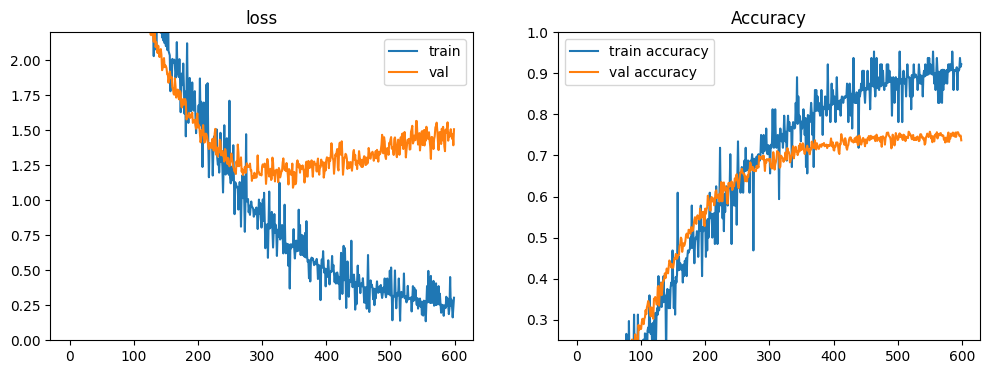

The accuracy is 75.7% compared to a chance level of 3.125%


In [18]:
plot_history(history)
plt.show()

res = data_aug_plus_droput_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

#### Now testing dropout 40% with weightdecay

In [13]:
from tensorflow.keras.regularizers import l2

def dropout_weightdecay_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

dropout_weightdecay_model = dropout_weightdecay_model()

# Train the model with EarlyStopping
history_dropout_weightdecay_model = dropout_weightdecay_model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=600,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/600


I0000 00:00:1720547414.195184  267074 service.cc:145] XLA service 0x7f6a3c002750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720547414.195292  267074 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-07-09 17:50:15.457565: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 17:50:16.055821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  4/188 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.0075 - loss: 69.8562      

I0000 00:00:1720547439.144878  267074 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 181ms/step - accuracy: 0.0318 - loss: 44.5158 - val_accuracy: 0.0380 - val_loss: 40.6593
Epoch 2/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0347 - loss: 39.9720 - val_accuracy: 0.0288 - val_loss: 37.9730
Epoch 3/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0349 - loss: 37.3316 - val_accuracy: 0.0393 - val_loss: 35.4814
Epoch 4/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0412 - loss: 34.8827 - val_accuracy: 0.0589 - val_loss: 33.1683
Epoch 5/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0430 - loss: 32.6050 - val_accuracy: 0.0589 - val_loss: 31.0216
Epoch 6/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0509 - loss: 30.4904 - val_accuracy: 0.0452 - val_loss: 29.0284
Epoch 7/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0552 - loss: 28.5354 - val_accuracy: 0.0445 - val_loss: 27.1811
Epoch 8/600
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0603 - loss

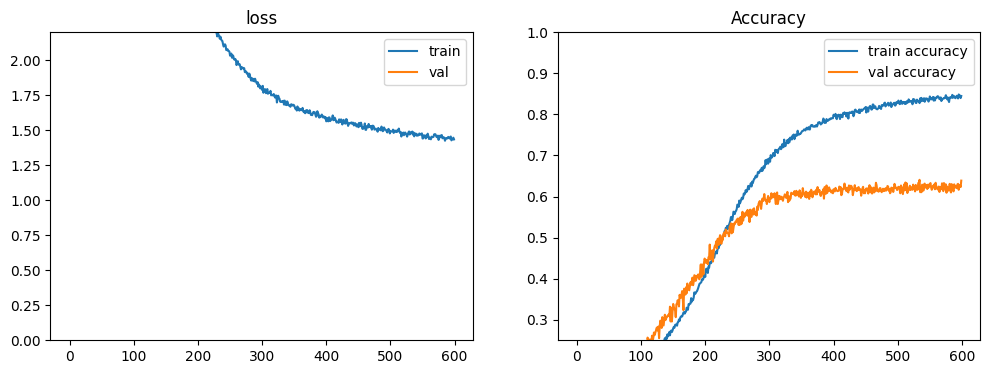

The accuracy is 65.1% compared to a chance level of 1.5625%


In [14]:
plot_history(history_dropout_weightdecay_model)
plt.show()

res = dropout_weightdecay_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

### Weight decay + data augmentation

In [19]:
from tensorflow.keras.regularizers import l2

def dataugment_weightdecay_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))       
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2))) 
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

dataugment_weightdecay_model = dataugment_weightdecay_model()

steps = int(train_images.shape[0] / 64)
# Train the model with EarlyStopping

history_dataugment_weightdecay_model = dataugment_weightdecay_model.fit(
    train_flow, 
    steps_per_epoch=steps, 
    epochs=600, 
    validation_data=validation_dataset,
    batch_size=64
)

Epoch 1/600


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720556700.194662  360742 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1402', 8 bytes spill stores, 8 bytes spill loads



187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 380ms/step - accuracy: 0.0463 - loss: 42.7510 - val_accuracy: 0.0687 - val_loss: 40.4803
Epoch 2/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0156 - loss: 40.5753

2024-07-09 20:26:14.109912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:26:14.110014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0156 - loss: 40.5753 - val_accuracy: 0.0726 - val_loss: 40.4758
Epoch 3/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.1219 - loss: 39.6864 - val_accuracy: 0.1682 - val_loss: 37.5389
Epoch 4/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0625 - loss: 37.5398

2024-07-09 20:27:22.739263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:27:22.739361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:27:22.739427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0625 - loss: 37.5398 - val_accuracy: 0.1780 - val_loss: 37.5043
Epoch 5/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.1685 - loss: 36.8584 - val_accuracy: 0.1957 - val_loss: 34.9084
Epoch 6/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2031 - loss: 34.9305

2024-07-09 20:28:28.939053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:28:28.939112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:28:28.939197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2031 - loss: 34.9305 - val_accuracy: 0.1957 - val_loss: 34.9104
Epoch 7/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.2092 - loss: 34.3126 - val_accuracy: 0.2238 - val_loss: 32.5433
Epoch 8/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2188 - loss: 32.5174

2024-07-09 20:29:36.611534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:29:36.611602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:29:36.611694: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2188 - loss: 32.5174 - val_accuracy: 0.2075 - val_loss: 32.5852
Epoch 9/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.2312 - loss: 31.9648 - val_accuracy: 0.2644 - val_loss: 30.2989
Epoch 10/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3438 - loss: 30.1593

2024-07-09 20:30:44.030198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:30:44.030284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:30:44.030316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3438 - loss: 30.1593 - val_accuracy: 0.2755 - val_loss: 30.2515
Epoch 11/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.2653 - loss: 29.7734 - val_accuracy: 0.2906 - val_loss: 28.2075
Epoch 12/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2656 - loss: 28.3566

2024-07-09 20:31:50.816829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:31:50.816942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 20:31:50.816962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2656 - loss: 28.3566 - val_accuracy: 0.2814 - val_loss: 28.2444
Epoch 13/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.2839 - loss: 27.7621 - val_accuracy: 0.2991 - val_loss: 26.3648
Epoch 14/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2969 - loss: 26.6331

2024-07-09 20:32:57.415996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:32:57.416082: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 20:32:57.416105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2969 - loss: 26.6331 - val_accuracy: 0.3043 - val_loss: 26.3602
Epoch 15/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.3144 - loss: 25.8809 - val_accuracy: 0.3076 - val_loss: 24.5953
Epoch 16/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3750 - loss: 24.5617

2024-07-09 20:34:03.995608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:34:03.995695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:34:03.995732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3750 - loss: 24.5617 - val_accuracy: 0.3050 - val_loss: 24.6217
Epoch 17/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.3100 - loss: 24.2080 - val_accuracy: 0.3547 - val_loss: 22.9347
Epoch 18/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4219 - loss: 23.0129

2024-07-09 20:35:11.231207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:35:11.231267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:35:11.231370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4219 - loss: 23.0129 - val_accuracy: 0.3541 - val_loss: 22.9672
Epoch 19/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.3390 - loss: 22.5772 - val_accuracy: 0.3318 - val_loss: 21.5323
Epoch 20/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2969 - loss: 21.7774

2024-07-09 20:36:17.793888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:36:17.793947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:36:17.793996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2969 - loss: 21.7774 - val_accuracy: 0.3495 - val_loss: 21.4831
Epoch 21/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 395ms/step - accuracy: 0.3644 - loss: 21.0759 - val_accuracy: 0.3685 - val_loss: 20.0973
Epoch 22/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3438 - loss: 20.1760

2024-07-09 20:37:35.566377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:37:35.566440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3438 - loss: 20.1760 - val_accuracy: 0.3645 - val_loss: 20.0873
Epoch 23/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 367ms/step - accuracy: 0.3689 - loss: 19.7249 - val_accuracy: 0.3796 - val_loss: 18.7599
Epoch 24/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2969 - loss: 18.9183

2024-07-09 20:38:48.219878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:38:48.219942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:38:48.219965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2969 - loss: 18.9183 - val_accuracy: 0.3868 - val_loss: 18.7417
Epoch 25/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.3802 - loss: 18.4595 - val_accuracy: 0.4018 - val_loss: 17.5900
Epoch 26/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4375 - loss: 17.4960

2024-07-09 20:39:54.618917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:39:54.618983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:39:54.619042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4375 - loss: 17.4960 - val_accuracy: 0.3927 - val_loss: 17.5790
Epoch 27/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.4071 - loss: 17.2379 - val_accuracy: 0.4175 - val_loss: 16.4418
Epoch 28/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3750 - loss: 16.5209

2024-07-09 20:40:59.905354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:40:59.905414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:40:59.905470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3750 - loss: 16.5209 - val_accuracy: 0.4084 - val_loss: 16.4567
Epoch 29/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.4168 - loss: 16.1570 - val_accuracy: 0.3933 - val_loss: 15.4670
Epoch 30/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4062 - loss: 15.3877

2024-07-09 20:42:05.540478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:42:05.540539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:42:05.540560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4062 - loss: 15.3877 - val_accuracy: 0.4162 - val_loss: 15.4185
Epoch 31/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.4280 - loss: 15.1506 - val_accuracy: 0.4169 - val_loss: 14.5272
Epoch 32/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4844 - loss: 14.4418

2024-07-09 20:43:11.711294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:43:11.711359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:43:11.711393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4844 - loss: 14.4418 - val_accuracy: 0.4221 - val_loss: 14.4986
Epoch 33/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.4423 - loss: 14.1789 - val_accuracy: 0.4162 - val_loss: 13.6518
Epoch 34/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5000 - loss: 13.5658

2024-07-09 20:44:17.905131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:44:17.905185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:44:17.905268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 13.5658 - val_accuracy: 0.4274 - val_loss: 13.6629
Epoch 35/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.4567 - loss: 13.3353 - val_accuracy: 0.4490 - val_loss: 12.7993
Epoch 36/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5312 - loss: 12.7154

2024-07-09 20:45:24.194259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:45:24.194333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:45:24.194375: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5312 - loss: 12.7154 - val_accuracy: 0.4287 - val_loss: 12.8337
Epoch 37/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.4640 - loss: 12.5030 - val_accuracy: 0.4548 - val_loss: 12.0433
Epoch 38/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5938 - loss: 11.7516

2024-07-09 20:46:30.713489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:46:30.713541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 20:46:30.713573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5938 - loss: 11.7516 - val_accuracy: 0.4431 - val_loss: 12.1153
Epoch 39/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.4765 - loss: 11.7452 - val_accuracy: 0.4692 - val_loss: 11.3508
Epoch 40/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4688 - loss: 11.2277

2024-07-09 20:47:36.772289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:47:36.772345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:47:36.772381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 11.2277 - val_accuracy: 0.4418 - val_loss: 11.4309
Epoch 41/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 337ms/step - accuracy: 0.4895 - loss: 11.0590 - val_accuracy: 0.4614 - val_loss: 10.7674
Epoch 42/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6406 - loss: 10.3350

2024-07-09 20:48:43.607510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:48:43.607562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:48:43.607598: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6406 - loss: 10.3350 - val_accuracy: 0.4614 - val_loss: 10.7583
Epoch 43/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.5018 - loss: 10.3959 - val_accuracy: 0.4843 - val_loss: 10.0802
Epoch 44/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3438 - loss: 10.3700

2024-07-09 20:49:50.173982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:49:50.174073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3438 - loss: 10.3700 - val_accuracy: 0.4777 - val_loss: 10.0992
Epoch 45/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.5173 - loss: 9.7893 - val_accuracy: 0.5059 - val_loss: 9.5025
Epoch 46/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5000 - loss: 9.5146

2024-07-09 20:50:56.728325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:50:56.728380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:50:56.728423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 9.5146 - val_accuracy: 0.5262 - val_loss: 9.4536
Epoch 47/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.5330 - loss: 9.2145 - val_accuracy: 0.5151 - val_loss: 9.0139
Epoch 48/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4531 - loss: 9.1048

2024-07-09 20:52:03.013890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:52:03.013950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:52:03.014010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4531 - loss: 9.1048 - val_accuracy: 0.5223 - val_loss: 9.0033
Epoch 49/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.5573 - loss: 8.6334 - val_accuracy: 0.5020 - val_loss: 8.5565
Epoch 50/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5000 - loss: 8.5663

2024-07-09 20:53:09.274070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:53:09.274122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:53:09.274158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 8.5663 - val_accuracy: 0.5268 - val_loss: 8.4685
Epoch 51/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.5545 - loss: 8.1830 - val_accuracy: 0.5144 - val_loss: 8.0778
Epoch 52/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5156 - loss: 8.0481

2024-07-09 20:54:15.125529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:54:15.125584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:54:15.125638: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5156 - loss: 8.0481 - val_accuracy: 0.5203 - val_loss: 8.0680
Epoch 53/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.5750 - loss: 7.7218 - val_accuracy: 0.5020 - val_loss: 7.7558
Epoch 54/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5625 - loss: 7.5618

2024-07-09 20:55:20.288506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:55:20.288577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:55:20.288649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5625 - loss: 7.5618 - val_accuracy: 0.5229 - val_loss: 7.6852
Epoch 55/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.5834 - loss: 7.2888 - val_accuracy: 0.5353 - val_loss: 7.2838
Epoch 56/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6250 - loss: 6.9326

2024-07-09 20:56:26.324603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:56:26.324673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:56:26.324708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 6.9326 - val_accuracy: 0.5386 - val_loss: 7.2578
Epoch 57/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.5851 - loss: 6.9494 - val_accuracy: 0.5209 - val_loss: 7.0431
Epoch 58/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 6.4690

2024-07-09 20:57:32.309335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:57:32.309381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:57:32.309418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 6.4690 - val_accuracy: 0.5445 - val_loss: 6.9644
Epoch 59/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - accuracy: 0.6119 - loss: 6.5298 - val_accuracy: 0.5419 - val_loss: 6.6350
Epoch 60/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5469 - loss: 6.2459

2024-07-09 20:58:38.198083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:58:38.198130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 20:58:38.198150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5469 - loss: 6.2459 - val_accuracy: 0.5510 - val_loss: 6.5744
Epoch 61/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.6132 - loss: 6.1959 - val_accuracy: 0.5792 - val_loss: 6.2097
Epoch 62/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6094 - loss: 6.1659

2024-07-09 20:59:43.918902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 20:59:43.918983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 20:59:43.919101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 6.1659 - val_accuracy: 0.5615 - val_loss: 6.2821
Epoch 63/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.6382 - loss: 5.8322 - val_accuracy: 0.5609 - val_loss: 6.0477
Epoch 64/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7188 - loss: 5.5502

2024-07-09 21:00:49.516292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:00:49.516377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:00:49.516430: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 5.5502 - val_accuracy: 0.5700 - val_loss: 5.9857
Epoch 65/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.6379 - loss: 5.5759 - val_accuracy: 0.5399 - val_loss: 5.8099
Epoch 66/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5938 - loss: 5.5589

2024-07-09 21:01:55.098746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:01:55.098812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:01:55.098868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5938 - loss: 5.5589 - val_accuracy: 0.5556 - val_loss: 5.7941
Epoch 67/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.6342 - loss: 5.3303 - val_accuracy: 0.4980 - val_loss: 5.7484
Epoch 68/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6094 - loss: 5.1466

2024-07-09 21:03:01.020603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:03:01.020664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:03:01.020698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6094 - loss: 5.1466 - val_accuracy: 0.5347 - val_loss: 5.6463
Epoch 69/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.6603 - loss: 5.0209 - val_accuracy: 0.5923 - val_loss: 5.3199
Epoch 70/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 4.8755

2024-07-09 21:04:06.509805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:04:06.509855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:04:06.509941: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 4.8755 - val_accuracy: 0.5942 - val_loss: 5.3100
Epoch 71/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.6721 - loss: 4.7904 - val_accuracy: 0.5700 - val_loss: 5.0656
Epoch 72/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6875 - loss: 4.5653

2024-07-09 21:05:12.308432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:05:12.308521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:05:12.308563: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 4.5653 - val_accuracy: 0.5746 - val_loss: 5.0619
Epoch 73/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.6790 - loss: 4.5679 - val_accuracy: 0.5825 - val_loss: 4.9181
Epoch 74/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7812 - loss: 4.1939

2024-07-09 21:06:17.904663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:06:17.904729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:06:17.904786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 4.1939 - val_accuracy: 0.5838 - val_loss: 4.9100
Epoch 75/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.6859 - loss: 4.3572 - val_accuracy: 0.6165 - val_loss: 4.7116
Epoch 76/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6406 - loss: 4.5535

2024-07-09 21:07:23.717227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:07:23.717282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:07:23.717318: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6406 - loss: 4.5535 - val_accuracy: 0.6165 - val_loss: 4.7173
Epoch 77/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.6851 - loss: 4.1981 - val_accuracy: 0.5478 - val_loss: 4.7506
Epoch 78/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7031 - loss: 4.2254

2024-07-09 21:08:29.103769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:08:29.103832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:08:29.103901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 4.2254 - val_accuracy: 0.5635 - val_loss: 4.6956
Epoch 79/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.7119 - loss: 3.9723 - val_accuracy: 0.6165 - val_loss: 4.3820
Epoch 80/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8125 - loss: 3.5595

2024-07-09 21:09:34.794869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:09:34.794926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:09:34.794978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 3.5595 - val_accuracy: 0.5923 - val_loss: 4.4317
Epoch 81/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.7120 - loss: 3.8236 - val_accuracy: 0.5877 - val_loss: 4.3376
Epoch 82/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6875 - loss: 3.8146

2024-07-09 21:10:40.216315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:10:40.216369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:10:40.216404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 3.8146 - val_accuracy: 0.5851 - val_loss: 4.3502
Epoch 83/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.7309 - loss: 3.6473 - val_accuracy: 0.6073 - val_loss: 4.1809
Epoch 84/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6875 - loss: 3.7160

2024-07-09 21:11:46.476644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:11:46.476703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 3.7160 - val_accuracy: 0.6283 - val_loss: 4.1410
Epoch 85/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.7383 - loss: 3.5001 - val_accuracy: 0.6034 - val_loss: 4.1138
Epoch 86/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8125 - loss: 3.3482

2024-07-09 21:12:52.203273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:12:52.203352: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 21:12:52.203386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 3.3482 - val_accuracy: 0.5929 - val_loss: 4.1161
Epoch 87/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.7419 - loss: 3.3808 - val_accuracy: 0.6309 - val_loss: 3.9765
Epoch 88/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7656 - loss: 3.0578

2024-07-09 21:13:57.591922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:13:57.591989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:13:57.592075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 3.0578 - val_accuracy: 0.6250 - val_loss: 3.9653
Epoch 89/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.7378 - loss: 3.2522 - val_accuracy: 0.6126 - val_loss: 3.9565
Epoch 90/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7969 - loss: 3.1075

2024-07-09 21:15:03.222898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:15:03.222970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:15:03.223025: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 3.1075 - val_accuracy: 0.6263 - val_loss: 3.8652
Epoch 91/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.7516 - loss: 3.1245 - val_accuracy: 0.5975 - val_loss: 3.8435
Epoch 92/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7344 - loss: 3.2130

2024-07-09 21:16:09.207121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:16:09.207177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 21:16:09.207197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 3.2130 - val_accuracy: 0.6014 - val_loss: 3.8707
Epoch 93/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.7516 - loss: 3.0460 - val_accuracy: 0.6191 - val_loss: 3.7731
Epoch 94/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7812 - loss: 3.0152

2024-07-09 21:17:14.919160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:17:14.919232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:17:14.919299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 3.0152 - val_accuracy: 0.6034 - val_loss: 3.8202
Epoch 95/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.7615 - loss: 2.9381 - val_accuracy: 0.6067 - val_loss: 3.6887
Epoch 96/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7656 - loss: 2.8918

2024-07-09 21:18:20.230064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:18:20.230114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:18:20.230149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 2.8918 - val_accuracy: 0.6224 - val_loss: 3.6374
Epoch 97/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.7703 - loss: 2.8675 - val_accuracy: 0.5949 - val_loss: 3.6036
Epoch 98/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6875 - loss: 3.0413

2024-07-09 21:19:26.118272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:19:26.118323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 3.0413 - val_accuracy: 0.6060 - val_loss: 3.5795
Epoch 99/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.7716 - loss: 2.7605 - val_accuracy: 0.6315 - val_loss: 3.5385
Epoch 100/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7031 - loss: 2.8872

2024-07-09 21:20:31.870190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:20:31.870261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:20:31.870295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7031 - loss: 2.8872 - val_accuracy: 0.6315 - val_loss: 3.5524
Epoch 101/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.7884 - loss: 2.6490 - val_accuracy: 0.6348 - val_loss: 3.4739
Epoch 102/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7188 - loss: 2.8558

2024-07-09 21:21:36.987994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:21:36.988064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:21:36.988099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 2.8558 - val_accuracy: 0.6152 - val_loss: 3.5378
Epoch 103/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.7781 - loss: 2.6271 - val_accuracy: 0.6374 - val_loss: 3.4392
Epoch 104/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7812 - loss: 2.5874

2024-07-09 21:22:42.292655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:22:42.292744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:22:42.292795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 2.5874 - val_accuracy: 0.6603 - val_loss: 3.3514
Epoch 105/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.7955 - loss: 2.5077 - val_accuracy: 0.6171 - val_loss: 3.4241
Epoch 106/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8125 - loss: 2.3816

2024-07-09 21:23:48.282561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:23:48.282610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 2.3816 - val_accuracy: 0.6211 - val_loss: 3.4288
Epoch 107/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.7999 - loss: 2.4441 - val_accuracy: 0.6466 - val_loss: 3.2837
Epoch 108/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 2.2586

2024-07-09 21:24:54.225263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:24:54.225306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:24:54.225355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 2.2586 - val_accuracy: 0.6283 - val_loss: 3.3408
Epoch 109/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.7943 - loss: 2.4183 - val_accuracy: 0.6414 - val_loss: 3.2781
Epoch 110/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7500 - loss: 2.6178

2024-07-09 21:26:00.674477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:26:00.674551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 2.6178 - val_accuracy: 0.6623 - val_loss: 3.1896
Epoch 111/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 337ms/step - accuracy: 0.8144 - loss: 2.3225 - val_accuracy: 0.6355 - val_loss: 3.3363
Epoch 112/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6719 - loss: 2.7798

2024-07-09 21:27:07.499415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:27:07.499475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:27:07.499508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6719 - loss: 2.7798 - val_accuracy: 0.6643 - val_loss: 3.2076
Epoch 113/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8150 - loss: 2.2655 - val_accuracy: 0.6564 - val_loss: 3.1662
Epoch 114/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7500 - loss: 2.2890

2024-07-09 21:28:13.514122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:28:13.514193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:28:13.514230: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 2.2890 - val_accuracy: 0.6440 - val_loss: 3.2079
Epoch 115/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8123 - loss: 2.2447 - val_accuracy: 0.6348 - val_loss: 3.2011
Epoch 116/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8281 - loss: 2.2074

2024-07-09 21:29:19.597205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:29:19.597261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:29:19.597291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 2.2074 - val_accuracy: 0.6387 - val_loss: 3.1719
Epoch 117/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.8187 - loss: 2.1898 - val_accuracy: 0.6492 - val_loss: 3.1642
Epoch 118/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7812 - loss: 2.3594

2024-07-09 21:30:25.393603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:30:25.393691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:30:25.393763: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 2.3594 - val_accuracy: 0.6616 - val_loss: 3.1027
Epoch 119/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.8353 - loss: 2.0935 - val_accuracy: 0.6466 - val_loss: 3.0893
Epoch 120/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7656 - loss: 2.3365

2024-07-09 21:31:31.817030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:31:31.817102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:31:31.817164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 2.3365 - val_accuracy: 0.6466 - val_loss: 3.0883
Epoch 121/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8280 - loss: 2.0744 - val_accuracy: 0.6329 - val_loss: 3.1648
Epoch 122/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8281 - loss: 2.0797

2024-07-09 21:32:37.866140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:32:37.866192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:32:37.866241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 2.0797 - val_accuracy: 0.6283 - val_loss: 3.2553
Epoch 123/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.8285 - loss: 2.0490 - val_accuracy: 0.6302 - val_loss: 3.1729
Epoch 124/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7969 - loss: 2.1894

2024-07-09 21:33:43.390714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:33:43.390774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 2.1894 - val_accuracy: 0.6191 - val_loss: 3.2527
Epoch 125/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8380 - loss: 2.0099 - val_accuracy: 0.6113 - val_loss: 3.1401
Epoch 126/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9219 - loss: 1.9736

2024-07-09 21:34:49.517936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:34:49.518020: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 21:34:49.518043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.9736 - val_accuracy: 0.6368 - val_loss: 3.0597
Epoch 127/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.8433 - loss: 1.9553 - val_accuracy: 0.6531 - val_loss: 3.0693
Epoch 128/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7969 - loss: 2.2020

2024-07-09 21:35:55.212413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:35:55.212467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:35:55.212506: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 2.2020 - val_accuracy: 0.6545 - val_loss: 3.0172
Epoch 129/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.8375 - loss: 1.9438 - val_accuracy: 0.6571 - val_loss: 2.9603
Epoch 130/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8438 - loss: 1.9993

2024-07-09 21:37:00.681752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:37:00.681816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:37:00.681850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.9993 - val_accuracy: 0.6636 - val_loss: 2.8738
Epoch 131/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.8439 - loss: 1.9123 - val_accuracy: 0.6787 - val_loss: 2.9421
Epoch 132/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8906 - loss: 1.8299

2024-07-09 21:38:06.892550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:38:06.892626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:38:06.892663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.8299 - val_accuracy: 0.6656 - val_loss: 2.9863
Epoch 133/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.8378 - loss: 1.9029 - val_accuracy: 0.6374 - val_loss: 3.0188
Epoch 134/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8125 - loss: 1.8637

2024-07-09 21:39:12.419359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:39:12.419423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:39:12.419487: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 1.8637 - val_accuracy: 0.6165 - val_loss: 3.0790
Epoch 135/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.8419 - loss: 1.8870 - val_accuracy: 0.6479 - val_loss: 3.0693
Epoch 136/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7969 - loss: 1.9452

2024-07-09 21:40:18.079260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:40:18.079316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:40:18.079384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 1.9452 - val_accuracy: 0.6531 - val_loss: 2.9875
Epoch 137/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8418 - loss: 1.8650 - val_accuracy: 0.6492 - val_loss: 3.0810
Epoch 138/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7344 - loss: 2.1515

2024-07-09 21:41:24.029350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:41:24.029437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:41:24.029486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7344 - loss: 2.1515 - val_accuracy: 0.6662 - val_loss: 2.9384
Epoch 139/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.8568 - loss: 1.7964 - val_accuracy: 0.6662 - val_loss: 2.9456
Epoch 140/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7656 - loss: 1.9088

2024-07-09 21:42:29.825050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:42:29.825112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:42:29.825132: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 1.9088 - val_accuracy: 0.6728 - val_loss: 2.9052
Epoch 141/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8639 - loss: 1.7669 - val_accuracy: 0.6381 - val_loss: 2.9631
Epoch 142/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7969 - loss: 1.9777

2024-07-09 21:43:35.815268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:43:35.815421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:43:35.815482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 1.9777 - val_accuracy: 0.6453 - val_loss: 2.9007
Epoch 143/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.8590 - loss: 1.7679 - val_accuracy: 0.6545 - val_loss: 2.9177
Epoch 144/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9062 - loss: 1.5797

2024-07-09 21:44:42.098751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:44:42.098811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 21:44:42.098835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.5797 - val_accuracy: 0.6564 - val_loss: 2.8888
Epoch 145/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.8540 - loss: 1.7722 - val_accuracy: 0.6584 - val_loss: 2.9094
Epoch 146/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8594 - loss: 1.6051

2024-07-09 21:45:47.979718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:45:47.979777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:45:47.979812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.6051 - val_accuracy: 0.6734 - val_loss: 2.8912
Epoch 147/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.8566 - loss: 1.7340 - val_accuracy: 0.6741 - val_loss: 2.8655
Epoch 148/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8281 - loss: 1.7466

2024-07-09 21:46:53.915342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:46:53.915416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 21:46:53.915453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.7466 - val_accuracy: 0.6610 - val_loss: 2.9258
Epoch 149/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.8666 - loss: 1.6965 - val_accuracy: 0.6911 - val_loss: 2.7787
Epoch 150/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8281 - loss: 1.7521

2024-07-09 21:48:01.337996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:48:01.338071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:48:01.338101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.7521 - val_accuracy: 0.6662 - val_loss: 2.7943
Epoch 151/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.8746 - loss: 1.6704 - val_accuracy: 0.6747 - val_loss: 2.7825
Epoch 152/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 1.5837

2024-07-09 21:49:08.704866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:49:08.704938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:49:08.705041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.5837 - val_accuracy: 0.6558 - val_loss: 2.8632
Epoch 153/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 331ms/step - accuracy: 0.8696 - loss: 1.6613 - val_accuracy: 0.6754 - val_loss: 2.8495
Epoch 154/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9375 - loss: 1.4943

2024-07-09 21:50:14.381490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:50:14.381559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:50:14.381591: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.4943 - val_accuracy: 0.6780 - val_loss: 2.8358
Epoch 155/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.8717 - loss: 1.6488 - val_accuracy: 0.6630 - val_loss: 2.8827
Epoch 156/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 1.6130

2024-07-09 21:51:20.304355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:51:20.304431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:51:20.304484: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.6130 - val_accuracy: 0.6538 - val_loss: 2.9243
Epoch 157/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.8717 - loss: 1.6224 - val_accuracy: 0.6518 - val_loss: 2.9050
Epoch 158/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8281 - loss: 1.6641

2024-07-09 21:52:26.614683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:52:26.614757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:52:26.614792: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.6641 - val_accuracy: 0.6499 - val_loss: 2.9129
Epoch 159/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.8725 - loss: 1.6143 - val_accuracy: 0.6590 - val_loss: 2.8920
Epoch 160/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 1.5331

2024-07-09 21:53:32.814845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:53:32.814893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:53:32.814930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.5331 - val_accuracy: 0.6715 - val_loss: 2.8050
Epoch 161/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.8782 - loss: 1.5825 - val_accuracy: 0.6682 - val_loss: 2.8359
Epoch 162/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8281 - loss: 1.5946

2024-07-09 21:54:38.111852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:54:38.111920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:54:38.111951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.5946 - val_accuracy: 0.6780 - val_loss: 2.7827
Epoch 163/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.8798 - loss: 1.5821 - val_accuracy: 0.6852 - val_loss: 2.7348
Epoch 164/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8438 - loss: 1.6054

2024-07-09 21:55:43.905069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:55:43.905144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 21:55:43.905193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.6054 - val_accuracy: 0.6747 - val_loss: 2.7736
Epoch 165/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.8784 - loss: 1.5713 - val_accuracy: 0.6760 - val_loss: 2.8169
Epoch 166/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8750 - loss: 1.5062

2024-07-09 21:56:52.816719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:56:52.816794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:56:52.816880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.5062 - val_accuracy: 0.6590 - val_loss: 2.9386
Epoch 167/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 355ms/step - accuracy: 0.8784 - loss: 1.5656 - val_accuracy: 0.6760 - val_loss: 2.8141
Epoch 168/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 1.6507

2024-07-09 21:58:03.083258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:58:03.083407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 21:58:03.083507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.6507 - val_accuracy: 0.6760 - val_loss: 2.8544
Epoch 169/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.8778 - loss: 1.5534 - val_accuracy: 0.6774 - val_loss: 2.7170
Epoch 170/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8906 - loss: 1.5671

2024-07-09 21:59:13.429675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 21:59:13.429747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.5671 - val_accuracy: 0.6715 - val_loss: 2.7911
Epoch 171/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 353ms/step - accuracy: 0.8932 - loss: 1.5099 - val_accuracy: 0.6760 - val_loss: 2.7698
Epoch 172/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8438 - loss: 1.6284

2024-07-09 22:00:23.414543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:00:23.414644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.6284 - val_accuracy: 0.6813 - val_loss: 2.7396
Epoch 173/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 358ms/step - accuracy: 0.8927 - loss: 1.5135 - val_accuracy: 0.6486 - val_loss: 2.7363
Epoch 174/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8750 - loss: 1.5776

2024-07-09 22:01:34.318887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:01:34.318964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:01:34.319013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.5776 - val_accuracy: 0.6453 - val_loss: 2.7679
Epoch 175/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.8751 - loss: 1.5390 - val_accuracy: 0.6774 - val_loss: 2.7673
Epoch 176/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9531 - loss: 1.3643

2024-07-09 22:02:44.419799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:02:44.419905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:02:44.419950: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 22:02:44.419999: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.3643 - val_accuracy: 0.6675 - val_loss: 2.8120
Epoch 177/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.8875 - loss: 1.4996 - val_accuracy: 0.6702 - val_loss: 2.8185
Epoch 178/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8906 - loss: 1.6005

2024-07-09 22:03:53.938756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:03:53.938828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:03:53.938904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.6005 - val_accuracy: 0.6623 - val_loss: 2.8442
Epoch 179/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.8882 - loss: 1.4958 - val_accuracy: 0.6793 - val_loss: 2.7685
Epoch 180/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9062 - loss: 1.4070

2024-07-09 22:05:02.408486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:05:02.408547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:05:02.408585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.4070 - val_accuracy: 0.6865 - val_loss: 2.7051
Epoch 181/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.8851 - loss: 1.4986 - val_accuracy: 0.6643 - val_loss: 2.8312
Epoch 182/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.3129

2024-07-09 22:06:11.606906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:06:11.606991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 22:06:11.607041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.3129 - val_accuracy: 0.6597 - val_loss: 2.9001
Epoch 183/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.8809 - loss: 1.5112 - val_accuracy: 0.6492 - val_loss: 2.8605
Epoch 184/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.4369

2024-07-09 22:07:20.640856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:07:20.641020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:07:20.641061: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 22:07:20.641115: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.4369 - val_accuracy: 0.6558 - val_loss: 2.8538
Epoch 185/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 358ms/step - accuracy: 0.8997 - loss: 1.4571 - val_accuracy: 0.6721 - val_loss: 2.7160
Epoch 186/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.3840

2024-07-09 22:08:31.610455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:08:31.610516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:08:31.610537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 22:08:31.610560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.3840 - val_accuracy: 0.6564 - val_loss: 2.7493
Epoch 187/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.8883 - loss: 1.4827 - val_accuracy: 0.6656 - val_loss: 2.7737
Epoch 188/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 1.5730

2024-07-09 22:09:39.413573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:09:39.413644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:09:39.413695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.5730 - val_accuracy: 0.6662 - val_loss: 2.7814
Epoch 189/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.8828 - loss: 1.4875 - val_accuracy: 0.6963 - val_loss: 2.7092
Epoch 190/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 1.4238

2024-07-09 22:10:47.642645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:10:47.642717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:10:47.642767: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.4238 - val_accuracy: 0.6904 - val_loss: 2.7437
Epoch 191/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.8882 - loss: 1.4646 - val_accuracy: 0.6538 - val_loss: 2.8256
Epoch 192/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8281 - loss: 1.5427

2024-07-09 22:11:54.908558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:11:54.908626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:11:54.908663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.5427 - val_accuracy: 0.6675 - val_loss: 2.7512
Epoch 193/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.8959 - loss: 1.4366 - val_accuracy: 0.6852 - val_loss: 2.7116
Epoch 194/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9219 - loss: 1.3133

2024-07-09 22:13:03.226149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:13:03.226221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.3133 - val_accuracy: 0.6918 - val_loss: 2.6403
Epoch 195/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.9020 - loss: 1.4101 - val_accuracy: 0.6832 - val_loss: 2.6308
Epoch 196/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.4286

2024-07-09 22:14:09.119039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:14:09.119100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.4286 - val_accuracy: 0.6872 - val_loss: 2.5954
Epoch 197/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.8874 - loss: 1.4498 - val_accuracy: 0.6793 - val_loss: 2.6938
Epoch 198/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8750 - loss: 1.4540

2024-07-09 22:15:14.613105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:15:14.613166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 22:15:14.613196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.4540 - val_accuracy: 0.6630 - val_loss: 2.7345
Epoch 199/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.8986 - loss: 1.4283 - val_accuracy: 0.6571 - val_loss: 2.7917
Epoch 200/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8906 - loss: 1.4552

2024-07-09 22:16:21.091884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:16:21.091955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:16:21.091991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.4552 - val_accuracy: 0.6682 - val_loss: 2.7218
Epoch 201/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.8946 - loss: 1.4194 - val_accuracy: 0.6669 - val_loss: 2.7711
Epoch 202/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8750 - loss: 1.4696

2024-07-09 22:17:26.613582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:17:26.613675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.4696 - val_accuracy: 0.6531 - val_loss: 2.7856
Epoch 203/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.8920 - loss: 1.4383 - val_accuracy: 0.6859 - val_loss: 2.6796
Epoch 204/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8438 - loss: 1.6452

2024-07-09 22:18:35.834998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:18:35.835058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:18:35.835106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.6452 - val_accuracy: 0.6800 - val_loss: 2.6752
Epoch 205/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.8902 - loss: 1.4282 - val_accuracy: 0.6918 - val_loss: 2.7851
Epoch 206/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 1.4046

2024-07-09 22:19:43.475578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:19:43.475650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:19:43.475686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.4046 - val_accuracy: 0.6767 - val_loss: 2.7949
Epoch 207/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.9069 - loss: 1.3993 - val_accuracy: 0.6767 - val_loss: 2.6716
Epoch 208/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8281 - loss: 1.5575

2024-07-09 22:20:48.691640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:20:48.691704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 22:20:48.691744: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.5575 - val_accuracy: 0.6662 - val_loss: 2.7119
Epoch 209/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.9032 - loss: 1.3896 - val_accuracy: 0.6571 - val_loss: 2.7855
Epoch 210/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 1.4753

2024-07-09 22:21:54.199983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:21:54.200077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.4753 - val_accuracy: 0.6610 - val_loss: 2.7960
Epoch 211/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.9030 - loss: 1.3775 - val_accuracy: 0.6551 - val_loss: 2.7767
Epoch 212/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9219 - loss: 1.4513

2024-07-09 22:22:59.587184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:22:59.587253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:22:59.587316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.4513 - val_accuracy: 0.6571 - val_loss: 2.7911
Epoch 213/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.8875 - loss: 1.4087 - val_accuracy: 0.6368 - val_loss: 2.8159
Epoch 214/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 1.6177

2024-07-09 22:24:06.611347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:24:06.611410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:24:06.611464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.6177 - val_accuracy: 0.6459 - val_loss: 2.7636
Epoch 215/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.8966 - loss: 1.3979 - val_accuracy: 0.6721 - val_loss: 2.8510
Epoch 216/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9062 - loss: 1.3917

2024-07-09 22:25:16.189282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:25:16.189346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:25:16.189429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.3917 - val_accuracy: 0.6800 - val_loss: 2.8343
Epoch 217/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9072 - loss: 1.3507 - val_accuracy: 0.6675 - val_loss: 2.7336
Epoch 218/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 1.4192

2024-07-09 22:26:24.320220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:26:24.320272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 22:26:24.320303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.4192 - val_accuracy: 0.6702 - val_loss: 2.7288
Epoch 219/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.8910 - loss: 1.3990 - val_accuracy: 0.6715 - val_loss: 2.7486
Epoch 220/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9062 - loss: 1.3588

2024-07-09 22:27:30.305059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:27:30.305151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:27:30.305246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.3588 - val_accuracy: 0.6728 - val_loss: 2.6744
Epoch 221/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.9013 - loss: 1.3697 - val_accuracy: 0.6603 - val_loss: 2.7740
Epoch 222/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8281 - loss: 1.4770

2024-07-09 22:28:37.815416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:28:37.815516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:28:37.815582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 22:28:37.815644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.4770 - val_accuracy: 0.6728 - val_loss: 2.7660
Epoch 223/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9061 - loss: 1.3517 - val_accuracy: 0.6590 - val_loss: 2.7183
Epoch 224/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8750 - loss: 1.3982

2024-07-09 22:29:46.618359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:29:46.618436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:29:46.618473: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.3982 - val_accuracy: 0.6688 - val_loss: 2.6579
Epoch 225/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.9005 - loss: 1.3526 - val_accuracy: 0.6767 - val_loss: 2.7079
Epoch 226/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8594 - loss: 1.4139

2024-07-09 22:30:55.712449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:30:55.712557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:30:55.712584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 22:30:55.712692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.4139 - val_accuracy: 0.6924 - val_loss: 2.6206
Epoch 227/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.8961 - loss: 1.3651 - val_accuracy: 0.6767 - val_loss: 2.6590
Epoch 228/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9375 - loss: 1.2723

2024-07-09 22:32:01.609690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:32:01.609775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:32:01.609818: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.2723 - val_accuracy: 0.6695 - val_loss: 2.6741
Epoch 229/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.8999 - loss: 1.3600 - val_accuracy: 0.6695 - val_loss: 2.6340
Epoch 230/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8281 - loss: 1.5580

2024-07-09 22:33:09.413351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:33:09.413428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:33:09.413499: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.5580 - val_accuracy: 0.6630 - val_loss: 2.6691
Epoch 231/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.8978 - loss: 1.3583 - val_accuracy: 0.6741 - val_loss: 2.7155
Epoch 232/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.2845

2024-07-09 22:34:16.918431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:34:16.918502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:34:16.918576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.2845 - val_accuracy: 0.6760 - val_loss: 2.7375
Epoch 233/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.9030 - loss: 1.3450 - val_accuracy: 0.6590 - val_loss: 2.7849
Epoch 234/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9219 - loss: 1.3984

2024-07-09 22:35:23.330611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:35:23.330665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 22:35:23.330686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.3984 - val_accuracy: 0.6734 - val_loss: 2.7272
Epoch 235/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.9029 - loss: 1.3502 - val_accuracy: 0.6931 - val_loss: 2.5881
Epoch 236/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8906 - loss: 1.3596

2024-07-09 22:36:30.998590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:36:30.998644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.3596 - val_accuracy: 0.6728 - val_loss: 2.6837
Epoch 237/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.9006 - loss: 1.3407 - val_accuracy: 0.6708 - val_loss: 2.7065
Epoch 238/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8906 - loss: 1.5673

2024-07-09 22:37:34.726685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:37:34.726764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:37:34.726828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.5673 - val_accuracy: 0.6603 - val_loss: 2.7623
Epoch 239/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9009 - loss: 1.3421 - val_accuracy: 0.6682 - val_loss: 2.6991
Epoch 240/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9062 - loss: 1.2943

2024-07-09 22:38:38.813573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:38:38.813646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 22:38:38.813718: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2943 - val_accuracy: 0.6688 - val_loss: 2.7050
Epoch 241/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9079 - loss: 1.3187 - val_accuracy: 0.6708 - val_loss: 2.6832
Epoch 242/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 1.2740

2024-07-09 22:39:42.886827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:39:42.886923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:39:42.886959: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.2740 - val_accuracy: 0.6754 - val_loss: 2.7220
Epoch 243/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 322ms/step - accuracy: 0.9065 - loss: 1.3262 - val_accuracy: 0.6911 - val_loss: 2.6539
Epoch 244/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 1.3130

2024-07-09 22:40:46.627891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:40:46.627945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:40:46.627981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.3130 - val_accuracy: 0.6728 - val_loss: 2.7201
Epoch 245/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9070 - loss: 1.3090 - val_accuracy: 0.6695 - val_loss: 2.7213
Epoch 246/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8125 - loss: 1.4659

2024-07-09 22:41:50.703632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:41:50.703704: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 22:41:50.703727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 1.4659 - val_accuracy: 0.6551 - val_loss: 2.7066
Epoch 247/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9109 - loss: 1.3055 - val_accuracy: 0.6937 - val_loss: 2.5926
Epoch 248/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 1.3824

2024-07-09 22:42:54.815591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:42:54.815648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:42:54.815697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.3824 - val_accuracy: 0.6819 - val_loss: 2.6382
Epoch 249/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 322ms/step - accuracy: 0.9051 - loss: 1.3216 - val_accuracy: 0.6846 - val_loss: 2.6247
Epoch 250/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9531 - loss: 1.1521

2024-07-09 22:43:58.594428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:43:58.594484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1521 - val_accuracy: 0.6760 - val_loss: 2.7446
Epoch 251/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9023 - loss: 1.3299 - val_accuracy: 0.6937 - val_loss: 2.6914
Epoch 252/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8906 - loss: 1.3506

2024-07-09 22:45:02.801443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:45:02.801516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:45:02.801584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.3506 - val_accuracy: 0.6918 - val_loss: 2.7256
Epoch 253/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9121 - loss: 1.2832 - val_accuracy: 0.6865 - val_loss: 2.5869
Epoch 254/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8438 - loss: 1.4001

2024-07-09 22:46:06.922647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:46:06.922748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:46:06.922860: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.4001 - val_accuracy: 0.6963 - val_loss: 2.5272
Epoch 255/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.9126 - loss: 1.2771 - val_accuracy: 0.6780 - val_loss: 2.7159
Epoch 256/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8281 - loss: 1.3682

2024-07-09 22:47:10.924527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:47:10.924649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:47:10.924708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.3682 - val_accuracy: 0.6898 - val_loss: 2.6950
Epoch 257/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.9075 - loss: 1.2955 - val_accuracy: 0.6793 - val_loss: 2.7242
Epoch 258/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8750 - loss: 1.4702

2024-07-09 22:48:18.815191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:48:18.815298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:48:18.815339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.4702 - val_accuracy: 0.6787 - val_loss: 2.6361
Epoch 259/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9164 - loss: 1.2854 - val_accuracy: 0.6826 - val_loss: 2.6600
Epoch 260/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.2525

2024-07-09 22:49:26.315238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:49:26.315297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:49:26.315332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.2525 - val_accuracy: 0.6649 - val_loss: 2.6981
Epoch 261/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.9012 - loss: 1.3084 - val_accuracy: 0.6715 - val_loss: 2.6664
Epoch 262/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8281 - loss: 1.5464

2024-07-09 22:50:32.478804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:50:32.478867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:50:32.478926: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.5464 - val_accuracy: 0.6708 - val_loss: 2.6562
Epoch 263/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.8993 - loss: 1.3092 - val_accuracy: 0.6715 - val_loss: 2.6418
Epoch 264/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 1.2117

2024-07-09 22:51:38.722108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:51:38.722173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:51:38.722277: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.2117 - val_accuracy: 0.6643 - val_loss: 2.7290
Epoch 265/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.9095 - loss: 1.2918 - val_accuracy: 0.6741 - val_loss: 2.6395
Epoch 266/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9062 - loss: 1.3718

2024-07-09 22:52:45.062984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:52:45.063058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:52:45.063111: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.3718 - val_accuracy: 0.6734 - val_loss: 2.6283
Epoch 267/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 327ms/step - accuracy: 0.9170 - loss: 1.2693 - val_accuracy: 0.6675 - val_loss: 2.7225
Epoch 268/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8594 - loss: 1.4124

2024-07-09 22:53:50.035140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:53:50.035245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:53:50.035283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.4124 - val_accuracy: 0.6715 - val_loss: 2.7072
Epoch 269/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.9031 - loss: 1.3107 - val_accuracy: 0.6819 - val_loss: 2.6757
Epoch 270/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 1.2599

2024-07-09 22:54:55.822473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:54:55.822547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 22:54:55.822582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2599 - val_accuracy: 0.6721 - val_loss: 2.7063
Epoch 271/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.8968 - loss: 1.3172 - val_accuracy: 0.6872 - val_loss: 2.5776
Epoch 272/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8438 - loss: 1.3970

2024-07-09 22:56:01.634178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:56:01.634248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:56:01.634322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.3970 - val_accuracy: 0.6832 - val_loss: 2.6548
Epoch 273/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 329ms/step - accuracy: 0.9168 - loss: 1.2635 - val_accuracy: 0.6688 - val_loss: 2.6795
Epoch 274/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 1.3188

2024-07-09 22:57:06.832297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:57:06.832376: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-09 22:57:06.832399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.3188 - val_accuracy: 0.6662 - val_loss: 2.7250
Epoch 275/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9031 - loss: 1.3004 - val_accuracy: 0.6780 - val_loss: 2.6763
Epoch 276/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8125 - loss: 1.5170

2024-07-09 22:58:14.443194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:58:14.443294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:58:14.443330: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 1.5170 - val_accuracy: 0.6741 - val_loss: 2.6564
Epoch 277/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 326ms/step - accuracy: 0.9055 - loss: 1.2922 - val_accuracy: 0.6806 - val_loss: 2.6291
Epoch 278/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 1.2804

2024-07-09 22:59:19.328899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 22:59:19.328976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 22:59:19.329013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.2804 - val_accuracy: 0.6734 - val_loss: 2.6593
Epoch 279/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 338ms/step - accuracy: 0.9155 - loss: 1.2488 - val_accuracy: 0.6826 - val_loss: 2.6516
Epoch 280/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 1.1828

2024-07-09 23:00:26.096992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:00:26.097097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:00:26.097163: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1828 - val_accuracy: 0.6656 - val_loss: 2.7655
Epoch 281/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.9053 - loss: 1.2933 - val_accuracy: 0.6708 - val_loss: 2.6279
Epoch 282/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9219 - loss: 1.2284

2024-07-09 23:01:31.605843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:01:31.605901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.2284 - val_accuracy: 0.6767 - val_loss: 2.6231
Epoch 283/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 333ms/step - accuracy: 0.9143 - loss: 1.2488 - val_accuracy: 0.6793 - val_loss: 2.5586
Epoch 284/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9062 - loss: 1.2185

2024-07-09 23:02:37.734737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:02:37.734819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:02:37.734857: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2185 - val_accuracy: 0.6780 - val_loss: 2.5878
Epoch 285/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9126 - loss: 1.2641 - val_accuracy: 0.6688 - val_loss: 2.5930
Epoch 286/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 1.2469

2024-07-09 23:03:46.217190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:03:46.217239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:03:46.217275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.2469 - val_accuracy: 0.6793 - val_loss: 2.5895
Epoch 287/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.9117 - loss: 1.2664 - val_accuracy: 0.6819 - val_loss: 2.6716
Epoch 288/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9688 - loss: 1.2260

2024-07-09 23:04:53.506289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:04:53.506368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:04:53.506419: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.2260 - val_accuracy: 0.6662 - val_loss: 2.7386
Epoch 289/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 347ms/step - accuracy: 0.9087 - loss: 1.2701 - val_accuracy: 0.6774 - val_loss: 2.6788
Epoch 290/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9062 - loss: 1.3118

2024-07-09 23:06:02.421234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:06:02.421322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:06:02.421382: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.3118 - val_accuracy: 0.6728 - val_loss: 2.6512
Epoch 291/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.9262 - loss: 1.2103 - val_accuracy: 0.6793 - val_loss: 2.5964
Epoch 292/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.3508

2024-07-09 23:07:11.374268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:07:11.374354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:07:11.374395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:07:11.374442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.3508 - val_accuracy: 0.6734 - val_loss: 2.5694
Epoch 293/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 352ms/step - accuracy: 0.9259 - loss: 1.2216 - val_accuracy: 0.6924 - val_loss: 2.6441
Epoch 294/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.2647

2024-07-09 23:08:21.125360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:08:21.125418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 23:08:21.125440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.2647 - val_accuracy: 0.6682 - val_loss: 2.6778
Epoch 295/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9169 - loss: 1.2287 - val_accuracy: 0.6832 - val_loss: 2.5859
Epoch 296/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9531 - loss: 1.1754

2024-07-09 23:09:30.305743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:09:30.305872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:09:30.305914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:09:30.305979: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1754 - val_accuracy: 0.6793 - val_loss: 2.6036
Epoch 297/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9249 - loss: 1.2056 - val_accuracy: 0.6728 - val_loss: 2.6947
Epoch 298/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 1.3935

2024-07-09 23:10:38.711276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:10:38.711328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:10:38.711381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.3935 - val_accuracy: 0.6891 - val_loss: 2.5506
Epoch 299/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.9171 - loss: 1.2301 - val_accuracy: 0.6832 - val_loss: 2.6410
Epoch 300/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8906 - loss: 1.2629

2024-07-09 23:11:47.343472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:11:47.343555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:11:47.343631: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.2629 - val_accuracy: 0.6885 - val_loss: 2.5857
Epoch 301/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9215 - loss: 1.2146 - val_accuracy: 0.6603 - val_loss: 2.7229
Epoch 302/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8906 - loss: 1.3391

2024-07-09 23:12:56.506541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:12:56.506649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.3391 - val_accuracy: 0.6603 - val_loss: 2.7244
Epoch 303/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.9192 - loss: 1.2128 - val_accuracy: 0.6643 - val_loss: 2.7064
Epoch 304/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8438 - loss: 1.4605

2024-07-09 23:14:03.805806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:14:03.805857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:14:03.805896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.4605 - val_accuracy: 0.6780 - val_loss: 2.6553
Epoch 305/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.9055 - loss: 1.2539 - val_accuracy: 0.6688 - val_loss: 2.7048
Epoch 306/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8594 - loss: 1.4027

2024-07-09 23:15:11.367925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:15:11.368023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:15:11.368074: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.4027 - val_accuracy: 0.6767 - val_loss: 2.6159
Epoch 307/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 0.9114 - loss: 1.2371 - val_accuracy: 0.6819 - val_loss: 2.5940
Epoch 308/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.1624

2024-07-09 23:16:17.133784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:16:17.133856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.1624 - val_accuracy: 0.6760 - val_loss: 2.6585
Epoch 309/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9109 - loss: 1.2382 - val_accuracy: 0.6702 - val_loss: 2.6931
Epoch 310/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8750 - loss: 1.4059

2024-07-09 23:17:24.607928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:17:24.607998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:17:24.608074: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.4059 - val_accuracy: 0.6859 - val_loss: 2.5719
Epoch 311/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.9266 - loss: 1.2054 - val_accuracy: 0.6990 - val_loss: 2.5081
Epoch 312/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.3342

2024-07-09 23:18:32.141041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:18:32.141102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:18:32.141170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.3342 - val_accuracy: 0.6859 - val_loss: 2.6162
Epoch 313/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9082 - loss: 1.2495 - val_accuracy: 0.6904 - val_loss: 2.6340
Epoch 314/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.2043

2024-07-09 23:19:39.611868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:19:39.611938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 23:19:39.611968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.2043 - val_accuracy: 0.6846 - val_loss: 2.6189
Epoch 315/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.9153 - loss: 1.2243 - val_accuracy: 0.6636 - val_loss: 2.6584
Epoch 316/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8594 - loss: 1.3368

2024-07-09 23:20:46.893535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:20:46.893607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:20:46.893646: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.3368 - val_accuracy: 0.6662 - val_loss: 2.6823
Epoch 317/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9100 - loss: 1.2344 - val_accuracy: 0.6813 - val_loss: 2.6544
Epoch 318/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9219 - loss: 1.2345

2024-07-09 23:21:54.618112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:21:54.618191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:21:54.618228: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.2345 - val_accuracy: 0.6924 - val_loss: 2.5662
Epoch 319/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9231 - loss: 1.1970 - val_accuracy: 0.6904 - val_loss: 2.5633
Epoch 320/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.1575

2024-07-09 23:23:03.110065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:23:03.110159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:23:03.110222: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1575 - val_accuracy: 0.6865 - val_loss: 2.5650
Epoch 321/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9159 - loss: 1.2200 - val_accuracy: 0.6787 - val_loss: 2.5693
Epoch 322/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9531 - loss: 1.1782

2024-07-09 23:24:11.827244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:24:11.827405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:24:11.827439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:24:11.827502: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1782 - val_accuracy: 0.6800 - val_loss: 2.5971
Epoch 323/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 357ms/step - accuracy: 0.9138 - loss: 1.2184 - val_accuracy: 0.6708 - val_loss: 2.6834
Epoch 324/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8594 - loss: 1.3248

2024-07-09 23:25:22.537194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:25:22.537286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.3248 - val_accuracy: 0.6780 - val_loss: 2.6286
Epoch 325/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.9190 - loss: 1.1969 - val_accuracy: 0.6878 - val_loss: 2.5907
Epoch 326/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9688 - loss: 1.2143

2024-07-09 23:26:31.321031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:26:31.321095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.2143 - val_accuracy: 0.6636 - val_loss: 2.6972
Epoch 327/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9244 - loss: 1.1864 - val_accuracy: 0.6695 - val_loss: 2.6001
Epoch 328/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8906 - loss: 1.2594

2024-07-09 23:27:40.546458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:27:40.546565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.2594 - val_accuracy: 0.6813 - val_loss: 2.6556
Epoch 329/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9137 - loss: 1.2239 - val_accuracy: 0.6957 - val_loss: 2.5506
Epoch 330/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8594 - loss: 1.2923

2024-07-09 23:28:48.212407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:28:48.212481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:28:48.212555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.2923 - val_accuracy: 0.6937 - val_loss: 2.5559
Epoch 331/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 347ms/step - accuracy: 0.9192 - loss: 1.2002 - val_accuracy: 0.6688 - val_loss: 2.5813
Epoch 332/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9375 - loss: 1.1428

2024-07-09 23:29:57.140383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:29:57.140485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:29:57.140539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1428 - val_accuracy: 0.6741 - val_loss: 2.6084
Epoch 333/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.9087 - loss: 1.2269 - val_accuracy: 0.6754 - val_loss: 2.5802
Epoch 334/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9531 - loss: 1.1688

2024-07-09 23:31:06.334116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:31:06.334211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 23:31:06.334262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1688 - val_accuracy: 0.6715 - val_loss: 2.6081
Epoch 335/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.9141 - loss: 1.2114 - val_accuracy: 0.6734 - val_loss: 2.5918
Epoch 336/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 1.2819

2024-07-09 23:32:15.320099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:32:15.320158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2819 - val_accuracy: 0.6898 - val_loss: 2.4846
Epoch 337/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.9173 - loss: 1.2095 - val_accuracy: 0.6721 - val_loss: 2.6273
Epoch 338/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.1620

2024-07-09 23:33:24.447562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:33:24.447668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:33:24.447728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:33:24.447820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1620 - val_accuracy: 0.6806 - val_loss: 2.5931
Epoch 339/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9317 - loss: 1.1695 - val_accuracy: 0.6819 - val_loss: 2.6910
Epoch 340/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 1.1960

2024-07-09 23:34:32.559457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:34:32.559526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 23:34:32.559561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1960 - val_accuracy: 0.6728 - val_loss: 2.6968
Epoch 341/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.9155 - loss: 1.2077 - val_accuracy: 0.6715 - val_loss: 2.6722
Epoch 342/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8438 - loss: 1.2408

2024-07-09 23:35:40.415627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:35:40.415736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:35:40.415843: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 1.2408 - val_accuracy: 0.6767 - val_loss: 2.7250
Epoch 343/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 347ms/step - accuracy: 0.9248 - loss: 1.1681 - val_accuracy: 0.6865 - val_loss: 2.5666
Epoch 344/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 1.0000 - loss: 1.0771

2024-07-09 23:36:49.412234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:36:49.412321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:36:49.412371: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0771 - val_accuracy: 0.6846 - val_loss: 2.5559
Epoch 345/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.9248 - loss: 1.1697 - val_accuracy: 0.6656 - val_loss: 2.7609
Epoch 346/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 1.3149

2024-07-09 23:37:56.810282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:37:56.810401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.3149 - val_accuracy: 0.6688 - val_loss: 2.7204
Epoch 347/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9197 - loss: 1.1856 - val_accuracy: 0.6924 - val_loss: 2.5345
Epoch 348/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9531 - loss: 1.0647

2024-07-09 23:39:05.329510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:39:05.329591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:39:05.329629: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.0647 - val_accuracy: 0.6787 - val_loss: 2.5916
Epoch 349/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.9138 - loss: 1.2019 - val_accuracy: 0.6760 - val_loss: 2.6528
Epoch 350/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 1.3073

2024-07-09 23:40:14.011393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:40:14.011449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:40:14.011550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.3073 - val_accuracy: 0.6852 - val_loss: 2.5835
Epoch 351/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.9139 - loss: 1.1940 - val_accuracy: 0.6774 - val_loss: 2.5920
Epoch 352/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9531 - loss: 1.1006

2024-07-09 23:41:22.029150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:41:22.029241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1006 - val_accuracy: 0.6793 - val_loss: 2.5824
Epoch 353/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9145 - loss: 1.1904 - val_accuracy: 0.6734 - val_loss: 2.5833
Epoch 354/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 1.2905

2024-07-09 23:42:30.461003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:42:30.461089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2905 - val_accuracy: 0.6747 - val_loss: 2.5667
Epoch 355/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9138 - loss: 1.1999 - val_accuracy: 0.6898 - val_loss: 2.6228
Epoch 356/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 1.2196

2024-07-09 23:43:39.029430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:43:39.029502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.2196 - val_accuracy: 0.6904 - val_loss: 2.5841
Epoch 357/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9223 - loss: 1.1814 - val_accuracy: 0.6630 - val_loss: 2.6686
Epoch 358/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 1.3099

2024-07-09 23:44:47.210593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:44:47.210662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:44:47.210715: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:44:47.210791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.3099 - val_accuracy: 0.6577 - val_loss: 2.6496
Epoch 359/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9190 - loss: 1.1825 - val_accuracy: 0.6865 - val_loss: 2.6785
Epoch 360/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9688 - loss: 1.1339

2024-07-09 23:45:54.193424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:45:54.193509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:45:54.193551: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.1339 - val_accuracy: 0.6911 - val_loss: 2.6218
Epoch 361/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9178 - loss: 1.1791 - val_accuracy: 0.6774 - val_loss: 2.6242
Epoch 362/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8906 - loss: 1.2002

2024-07-09 23:47:01.636549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:47:01.636626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.2002 - val_accuracy: 0.6832 - val_loss: 2.5952
Epoch 363/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.9208 - loss: 1.1700 - val_accuracy: 0.6708 - val_loss: 2.6470
Epoch 364/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8906 - loss: 1.1812

2024-07-09 23:48:08.903894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:48:08.904024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:48:08.904110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1812 - val_accuracy: 0.6793 - val_loss: 2.5689
Epoch 365/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.9148 - loss: 1.1810 - val_accuracy: 0.6898 - val_loss: 2.6313
Epoch 366/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9531 - loss: 1.1219

2024-07-09 23:49:17.918525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:49:17.918603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:49:17.918641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:49:17.918691: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1219 - val_accuracy: 0.6839 - val_loss: 2.6366
Epoch 367/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 353ms/step - accuracy: 0.9240 - loss: 1.1551 - val_accuracy: 0.6832 - val_loss: 2.5951
Epoch 368/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 1.0933

2024-07-09 23:50:27.705580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:50:27.705658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:50:27.705696: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0933 - val_accuracy: 0.6898 - val_loss: 2.5890
Epoch 369/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9278 - loss: 1.1384 - val_accuracy: 0.6918 - val_loss: 2.6114
Epoch 370/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 1.2276

2024-07-09 23:51:36.113521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:51:36.113591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.2276 - val_accuracy: 0.6990 - val_loss: 2.6684
Epoch 371/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9200 - loss: 1.1639 - val_accuracy: 0.6996 - val_loss: 2.5300
Epoch 372/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9688 - loss: 1.0632

2024-07-09 23:52:44.561067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:52:44.561130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 23:52:44.561160: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0632 - val_accuracy: 0.6911 - val_loss: 2.5196
Epoch 373/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9287 - loss: 1.1431 - val_accuracy: 0.6839 - val_loss: 2.5636
Epoch 374/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 1.1359

2024-07-09 23:53:52.587460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:53:52.587550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:53:52.587599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1359 - val_accuracy: 0.6865 - val_loss: 2.5580
Epoch 375/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9256 - loss: 1.1401 - val_accuracy: 0.6747 - val_loss: 2.5601
Epoch 376/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8281 - loss: 1.4601

2024-07-09 23:54:59.599997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:54:59.600057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:54:59.600099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 1.4601 - val_accuracy: 0.6806 - val_loss: 2.5214
Epoch 377/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9100 - loss: 1.1885 - val_accuracy: 0.6904 - val_loss: 2.5298
Epoch 378/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9531 - loss: 1.0754

2024-07-09 23:56:08.011469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:56:08.011573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:56:08.011647: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.0754 - val_accuracy: 0.6950 - val_loss: 2.5253
Epoch 379/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9308 - loss: 1.1243 - val_accuracy: 0.6865 - val_loss: 2.5942
Epoch 380/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9062 - loss: 1.2221

2024-07-09 23:57:15.649382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:57:15.649493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2221 - val_accuracy: 0.6898 - val_loss: 2.5559
Epoch 381/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.9202 - loss: 1.1541 - val_accuracy: 0.6656 - val_loss: 2.6321
Epoch 382/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9219 - loss: 1.1659

2024-07-09 23:58:25.271374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:58:25.271430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:58:25.271468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.1659 - val_accuracy: 0.6878 - val_loss: 2.5699
Epoch 383/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 339ms/step - accuracy: 0.9197 - loss: 1.1461 - val_accuracy: 0.6741 - val_loss: 2.7111
Epoch 384/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 1.2293

2024-07-09 23:59:32.625856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 23:59:32.626004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 23:59:32.626061: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-09 23:59:32.626126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2293 - val_accuracy: 0.6767 - val_loss: 2.6536
Epoch 385/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9233 - loss: 1.1466 - val_accuracy: 0.6983 - val_loss: 2.4106
Epoch 386/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9375 - loss: 1.1088

2024-07-10 00:00:39.823194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:00:39.823306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:00:39.823358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1088 - val_accuracy: 0.6970 - val_loss: 2.4492
Epoch 387/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9307 - loss: 1.1174 - val_accuracy: 0.6963 - val_loss: 2.6291
Epoch 388/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9062 - loss: 1.2006

2024-07-10 00:01:49.044438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:01:49.044555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:01:49.044670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2006 - val_accuracy: 0.6957 - val_loss: 2.6162
Epoch 389/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.9212 - loss: 1.1378 - val_accuracy: 0.6898 - val_loss: 2.4701
Epoch 390/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9375 - loss: 1.1007

2024-07-10 00:02:58.522302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:02:58.522393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:02:58.522429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1007 - val_accuracy: 0.6793 - val_loss: 2.6004
Epoch 391/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 341ms/step - accuracy: 0.9170 - loss: 1.1505 - val_accuracy: 0.6859 - val_loss: 2.5731
Epoch 392/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9531 - loss: 1.0862

2024-07-10 00:04:06.520195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:04:06.520268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:04:06.520342: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.0862 - val_accuracy: 0.6741 - val_loss: 2.6490
Epoch 393/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.9186 - loss: 1.1530 - val_accuracy: 0.6865 - val_loss: 2.4782
Epoch 394/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9688 - loss: 1.0407

2024-07-10 00:05:15.826741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:05:15.826855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0407 - val_accuracy: 0.6872 - val_loss: 2.4783
Epoch 395/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 337ms/step - accuracy: 0.9264 - loss: 1.1255 - val_accuracy: 0.6937 - val_loss: 2.5835
Epoch 396/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9062 - loss: 1.1238

2024-07-10 00:06:22.805376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:06:22.805427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:06:22.805489: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.1238 - val_accuracy: 0.7003 - val_loss: 2.5622
Epoch 397/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9249 - loss: 1.1427 - val_accuracy: 0.6741 - val_loss: 2.6716
Epoch 398/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8906 - loss: 1.2891

2024-07-10 00:07:29.829532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:07:29.829585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.2891 - val_accuracy: 0.6806 - val_loss: 2.6184
Epoch 399/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.9234 - loss: 1.1390 - val_accuracy: 0.6754 - val_loss: 2.5605
Epoch 400/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.1225

2024-07-10 00:08:38.831690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:08:38.831794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:08:38.831827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1225 - val_accuracy: 0.6387 - val_loss: 2.7021
Epoch 401/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.9177 - loss: 1.1510 - val_accuracy: 0.6800 - val_loss: 2.6003
Epoch 402/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9219 - loss: 1.1128

2024-07-10 00:09:45.421109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:09:45.421166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:09:45.421200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.1128 - val_accuracy: 0.6806 - val_loss: 2.6707
Epoch 403/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.9208 - loss: 1.1400 - val_accuracy: 0.6806 - val_loss: 2.6116
Epoch 404/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.1684

2024-07-10 00:10:54.927401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:10:54.927521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:10:54.927555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1684 - val_accuracy: 0.6787 - val_loss: 2.6116
Epoch 405/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 352ms/step - accuracy: 0.9207 - loss: 1.1411 - val_accuracy: 0.6708 - val_loss: 2.6773
Epoch 406/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8594 - loss: 1.2528

2024-07-10 00:12:04.803283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:12:04.803363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:12:04.803440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8594 - loss: 1.2528 - val_accuracy: 0.6819 - val_loss: 2.6122
Epoch 407/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 348ms/step - accuracy: 0.9262 - loss: 1.1362 - val_accuracy: 0.6813 - val_loss: 2.6019
Epoch 408/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8750 - loss: 1.2683

2024-07-10 00:13:13.650211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:13:13.650315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:13:13.650461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.2683 - val_accuracy: 0.6721 - val_loss: 2.6309
Epoch 409/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.9184 - loss: 1.1494 - val_accuracy: 0.6767 - val_loss: 2.6031
Epoch 410/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8750 - loss: 1.1680

2024-07-10 00:14:21.141318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:14:21.141390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:14:21.141433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.1680 - val_accuracy: 0.6774 - val_loss: 2.5938
Epoch 411/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9190 - loss: 1.1470 - val_accuracy: 0.6924 - val_loss: 2.6419
Epoch 412/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.2660

2024-07-10 00:15:29.498590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:15:29.498658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:15:29.498685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-10 00:15:29.498734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.2660 - val_accuracy: 0.6878 - val_loss: 2.6252
Epoch 413/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9297 - loss: 1.1221 - val_accuracy: 0.6806 - val_loss: 2.6241
Epoch 414/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9219 - loss: 1.0948

2024-07-10 00:16:38.126219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:16:38.126289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:16:38.126324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.0948 - val_accuracy: 0.6734 - val_loss: 2.6412
Epoch 415/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.9278 - loss: 1.1156 - val_accuracy: 0.6767 - val_loss: 2.6562
Epoch 416/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9375 - loss: 1.0663

2024-07-10 00:17:46.213349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:17:46.213429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:17:46.213468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0663 - val_accuracy: 0.6747 - val_loss: 2.7091
Epoch 417/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 343ms/step - accuracy: 0.9287 - loss: 1.1095 - val_accuracy: 0.6754 - val_loss: 2.5291
Epoch 418/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9688 - loss: 1.0485

2024-07-10 00:18:54.121851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:18:54.121938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:18:54.121974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0485 - val_accuracy: 0.6852 - val_loss: 2.5281
Epoch 419/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9339 - loss: 1.1025 - val_accuracy: 0.6662 - val_loss: 2.7174
Epoch 420/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7969 - loss: 1.4350

2024-07-10 00:20:02.311139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:20:02.311208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 1.4350 - val_accuracy: 0.6741 - val_loss: 2.6034
Epoch 421/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.9248 - loss: 1.1195 - val_accuracy: 0.6911 - val_loss: 2.4681
Epoch 422/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.1326

2024-07-10 00:21:08.698887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:21:08.698952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1326 - val_accuracy: 0.6846 - val_loss: 2.5373
Epoch 423/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9221 - loss: 1.1242 - val_accuracy: 0.6747 - val_loss: 2.7456
Epoch 424/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8750 - loss: 1.3032

2024-07-10 00:22:16.222428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:22:16.222525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:22:16.222565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.3032 - val_accuracy: 0.6885 - val_loss: 2.7022
Epoch 425/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9246 - loss: 1.1144 - val_accuracy: 0.6675 - val_loss: 2.6577
Epoch 426/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8906 - loss: 1.1924

2024-07-10 00:23:23.113194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:23:23.113270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:23:23.113355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1924 - val_accuracy: 0.6780 - val_loss: 2.6404
Epoch 427/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9311 - loss: 1.0978 - val_accuracy: 0.6806 - val_loss: 2.6043
Epoch 428/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9375 - loss: 1.1108

2024-07-10 00:24:30.403472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:24:30.403542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:24:30.403595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1108 - val_accuracy: 0.6891 - val_loss: 2.5472
Epoch 429/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.9262 - loss: 1.1064 - val_accuracy: 0.6872 - val_loss: 2.5005
Epoch 430/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.0925

2024-07-10 00:25:37.915326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:25:37.915633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0925 - val_accuracy: 0.6898 - val_loss: 2.5635
Epoch 431/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.9135 - loss: 1.1500 - val_accuracy: 0.7003 - val_loss: 2.4504
Epoch 432/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.0387

2024-07-10 00:26:47.220011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:26:47.220087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0387 - val_accuracy: 0.7029 - val_loss: 2.4320
Epoch 433/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9163 - loss: 1.1458 - val_accuracy: 0.6872 - val_loss: 2.4706
Epoch 434/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 1.1791

2024-07-10 00:27:55.854805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:27:55.854873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:27:55.854904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.1791 - val_accuracy: 0.6688 - val_loss: 2.5930
Epoch 435/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9330 - loss: 1.1029 - val_accuracy: 0.6800 - val_loss: 2.6610
Epoch 436/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9375 - loss: 1.0992

2024-07-10 00:29:04.111087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:29:04.111173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:29:04.111228: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0992 - val_accuracy: 0.6747 - val_loss: 2.6345
Epoch 437/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.9144 - loss: 1.1452 - val_accuracy: 0.6839 - val_loss: 2.5721
Epoch 438/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 1.0298

2024-07-10 00:30:14.327564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:30:14.327672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:30:14.327723: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0298 - val_accuracy: 0.6780 - val_loss: 2.5992
Epoch 439/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9298 - loss: 1.1041 - val_accuracy: 0.6937 - val_loss: 2.6053
Epoch 440/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 1.0960

2024-07-10 00:31:23.210350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:31:23.210444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.0960 - val_accuracy: 0.6918 - val_loss: 2.5498
Epoch 441/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.9341 - loss: 1.0951 - val_accuracy: 0.6826 - val_loss: 2.6243
Epoch 442/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9688 - loss: 1.0195

2024-07-10 00:32:33.818635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:32:33.818725: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139
2024-07-10 00:32:33.818774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0195 - val_accuracy: 0.6813 - val_loss: 2.6121
Epoch 443/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9330 - loss: 1.0782 - val_accuracy: 0.6937 - val_loss: 2.4549
Epoch 444/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9688 - loss: 1.0073

2024-07-10 00:33:42.206870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:33:42.206969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:33:42.207078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0073 - val_accuracy: 0.6806 - val_loss: 2.5659
Epoch 445/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.9300 - loss: 1.0907 - val_accuracy: 0.6741 - val_loss: 2.6621
Epoch 446/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.0567

2024-07-10 00:34:51.706979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:34:51.707076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:34:51.707127: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0567 - val_accuracy: 0.6721 - val_loss: 2.6750
Epoch 447/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step - accuracy: 0.9241 - loss: 1.0953 - val_accuracy: 0.6872 - val_loss: 2.5784
Epoch 448/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8906 - loss: 1.1732

2024-07-10 00:36:00.201506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:36:00.201610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:36:00.201713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1732 - val_accuracy: 0.6904 - val_loss: 2.5522
Epoch 449/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 353ms/step - accuracy: 0.9279 - loss: 1.0962 - val_accuracy: 0.6682 - val_loss: 2.7005
Epoch 450/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9531 - loss: 1.1720

2024-07-10 00:37:10.104373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:37:10.104436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:37:10.104474: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.1720 - val_accuracy: 0.6708 - val_loss: 2.7968
Epoch 451/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.9174 - loss: 1.1280 - val_accuracy: 0.6918 - val_loss: 2.6010
Epoch 452/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9688 - loss: 1.0171

2024-07-10 00:38:18.997846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:38:18.997915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:38:18.997952: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0171 - val_accuracy: 0.6832 - val_loss: 2.6427
Epoch 453/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.9264 - loss: 1.0970 - val_accuracy: 0.6754 - val_loss: 2.6740
Epoch 454/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.0160

2024-07-10 00:39:26.024435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:39:26.024528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0160 - val_accuracy: 0.6787 - val_loss: 2.7525
Epoch 455/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.9211 - loss: 1.1054 - val_accuracy: 0.6950 - val_loss: 2.5676
Epoch 456/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 1.1057

2024-07-10 00:40:34.029322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:40:34.029407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.1057 - val_accuracy: 0.6937 - val_loss: 2.5621
Epoch 457/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 352ms/step - accuracy: 0.9268 - loss: 1.0983 - val_accuracy: 0.6990 - val_loss: 2.6320
Epoch 458/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.0801

2024-07-10 00:41:43.827137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:41:43.827212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:41:43.827271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0801 - val_accuracy: 0.6931 - val_loss: 2.6530
Epoch 459/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.9244 - loss: 1.1021 - val_accuracy: 0.6878 - val_loss: 2.4739
Epoch 460/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9375 - loss: 1.0904

2024-07-10 00:42:51.728708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:42:51.728807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:42:51.728878: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0904 - val_accuracy: 0.6904 - val_loss: 2.5398
Epoch 461/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9285 - loss: 1.0805 - val_accuracy: 0.6852 - val_loss: 2.5110
Epoch 462/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9375 - loss: 1.1026

2024-07-10 00:44:00.404074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:44:00.404121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:44:00.404166: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1026 - val_accuracy: 0.6898 - val_loss: 2.3980
Epoch 463/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9314 - loss: 1.0751 - val_accuracy: 0.6754 - val_loss: 2.6878
Epoch 464/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9375 - loss: 1.1360

2024-07-10 00:45:08.952430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:45:08.952500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.1360 - val_accuracy: 0.6898 - val_loss: 2.5792
Epoch 465/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - accuracy: 0.9315 - loss: 1.0846 - val_accuracy: 0.6950 - val_loss: 2.5373
Epoch 466/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9688 - loss: 1.0591

2024-07-10 00:46:16.754734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:46:16.754849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:46:16.754899: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 1.0591 - val_accuracy: 0.6885 - val_loss: 2.5247
Epoch 467/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.9379 - loss: 1.0584 - val_accuracy: 0.6931 - val_loss: 2.5897
Epoch 468/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 1.1244

2024-07-10 00:47:24.585668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:47:24.585722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:47:24.585741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.1244 - val_accuracy: 0.6891 - val_loss: 2.5651
Epoch 469/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9313 - loss: 1.0676 - val_accuracy: 0.6734 - val_loss: 2.7660
Epoch 470/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9219 - loss: 1.1298

2024-07-10 00:48:33.712575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:48:33.712632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:48:33.712675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.1298 - val_accuracy: 0.6767 - val_loss: 2.7047
Epoch 471/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.9287 - loss: 1.0775 - val_accuracy: 0.6891 - val_loss: 2.5115
Epoch 472/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 1.0616

2024-07-10 00:49:41.721110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:49:41.721216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:49:41.721317: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.0616 - val_accuracy: 0.6832 - val_loss: 2.5384
Epoch 473/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.9339 - loss: 1.0642 - val_accuracy: 0.6760 - val_loss: 2.4671
Epoch 474/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9531 - loss: 1.0046

2024-07-10 00:50:51.134739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:50:51.134799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-10 00:50:51.134821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.0046 - val_accuracy: 0.6780 - val_loss: 2.4088
Epoch 475/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 342ms/step - accuracy: 0.9380 - loss: 1.0585 - val_accuracy: 0.6800 - val_loss: 2.4953
Epoch 476/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9375 - loss: 1.0717

2024-07-10 00:51:59.006389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:51:59.006439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:51:59.006476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0717 - val_accuracy: 0.6767 - val_loss: 2.5096
Epoch 477/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9309 - loss: 1.0626 - val_accuracy: 0.6865 - val_loss: 2.6575
Epoch 478/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9375 - loss: 1.0244

2024-07-10 00:53:08.230720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:53:08.230818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:53:08.230887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0244 - val_accuracy: 0.6852 - val_loss: 2.6268
Epoch 479/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9243 - loss: 1.0905 - val_accuracy: 0.6780 - val_loss: 2.4185
Epoch 480/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8906 - loss: 1.1188

2024-07-10 00:54:16.532570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:54:16.532641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:54:16.532700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1188 - val_accuracy: 0.6754 - val_loss: 2.4837
Epoch 481/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.9207 - loss: 1.1067 - val_accuracy: 0.6931 - val_loss: 2.5170
Epoch 482/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8906 - loss: 1.1899

2024-07-10 00:55:24.322754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:55:24.322846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:55:24.322887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6842804815770911613
2024-07-10 00:55:24.322994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 1.1899 - val_accuracy: 0.6832 - val_loss: 2.6086
Epoch 483/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9279 - loss: 1.0804 - val_accuracy: 0.6800 - val_loss: 2.6152
Epoch 484/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9531 - loss: 1.0280

2024-07-10 00:56:33.039044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:56:33.039186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:56:33.039236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 1.0280 - val_accuracy: 0.6839 - val_loss: 2.6139
Epoch 485/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.9236 - loss: 1.0949 - val_accuracy: 0.6918 - val_loss: 2.6089
Epoch 486/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9219 - loss: 1.0302

2024-07-10 00:57:42.422103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:57:42.422218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:57:42.422268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9219 - loss: 1.0302 - val_accuracy: 0.7009 - val_loss: 2.6085
Epoch 487/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.9290 - loss: 1.0777 - val_accuracy: 0.6826 - val_loss: 2.6294
Epoch 488/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9375 - loss: 1.0510

2024-07-10 00:58:51.030213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 00:58:51.030310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 00:58:51.030393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 1.0510 - val_accuracy: 0.6702 - val_loss: 2.6420
Epoch 489/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.9282 - loss: 1.0793 - val_accuracy: 0.6885 - val_loss: 2.5855
Epoch 490/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8750 - loss: 1.1734

2024-07-10 01:00:00.418329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 01:00:00.418481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 1.1734 - val_accuracy: 0.6891 - val_loss: 2.5879
Epoch 491/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.9383 - loss: 1.0504 - val_accuracy: 0.6885 - val_loss: 2.5765
Epoch 492/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9062 - loss: 1.2216

2024-07-10 01:01:08.522997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 01:01:08.523099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 01:01:08.523188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 1.2216 - val_accuracy: 0.6878 - val_loss: 2.5306
Epoch 493/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 348ms/step - accuracy: 0.9378 - loss: 1.0513 - val_accuracy: 0.6774 - val_loss: 2.5545
Epoch 494/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9844 - loss: 0.9840

2024-07-10 01:02:17.416829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-10 01:02:17.416959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-10 01:02:17.417041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 952660757491023139


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9844 - loss: 0.9840 - val_accuracy: 0.6715 - val_loss: 2.5404
Epoch 495/600
145/187 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.9299 - loss: 1.0574

KeyboardInterrupt: 

In [ ]:
plot_history(history_dataugment_weightdecay_model)
plt.show()

res = dataugment_weightdecay_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

## Now testing droput + weightdecay + data augmentation

In [20]:
from tensorflow.keras.regularizers import l2

def dropout_dataugment_weightdecay_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D((2, 2))) 
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

dropout_dataugment_weightdecay_model = dropout_dataugment_weightdecay_model()

steps = int(train_images.shape[0] / 64)
# Train the model with EarlyStopping

history_dropout_dataugment_weightdecay_model = dropout_dataugment_weightdecay_model.fit(
    train_flow, 
    steps_per_epoch=steps, 
    epochs=1000, 
    validation_data=validation_dataset,
    batch_size=64
)

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723476397.868998     688 service.cc:146] XLA service 0xdb2dec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723476397.869043     688 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-12 15:26:37.953378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-12 15:26:38.078730: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
I0000 00:00:1723476409.24743

KeyboardInterrupt: 

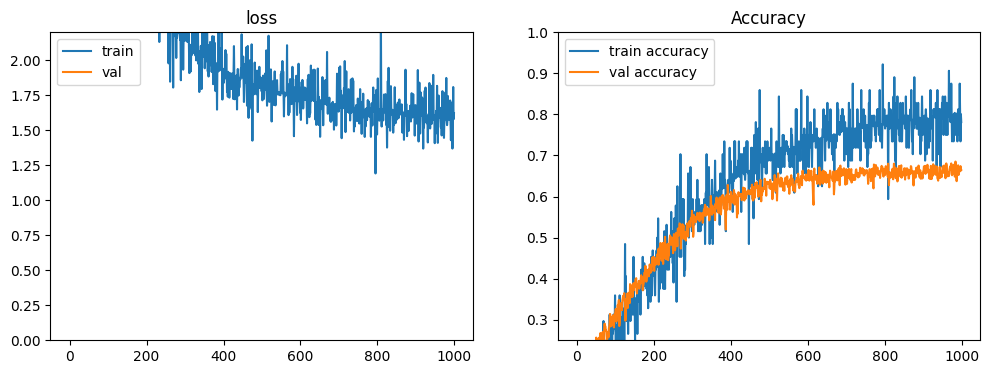

The accuracy is 67.6% compared to a chance level of 3.125%


In [19]:
plot_history(history_dropout_dataugment_weightdecay_model)
plt.show()

res = dropout_dataugment_weightdecay_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

# Dropout and Data Augmentation and Batch Normalization

## This is the best model so far with 75.7% accuracy

In [27]:
from keras.layers import BatchNormalization

def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

data_aug_plus_droput_model = dropout_model()
# fit model
steps = int(train_images.shape[0] / 64)
history = data_aug_plus_droput_model.fit(train_flow, steps_per_epoch=steps, epochs=600, validation_data=validation_dataset)

Epoch 1/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - accuracy: 0.0749 - loss: 3.9922 - val_accuracy: 0.0838 - val_loss: 3.4850
Epoch 2/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1250 - loss: 3.2112 - val_accuracy: 0.0812 - val_loss: 3.5084
Epoch 3/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.1732 - loss: 3.1425 - val_accuracy: 0.1682 - val_loss: 3.0918
Epoch 4/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2031 - loss: 2.9588 - val_accuracy: 0.1643 - val_loss: 3.0975
Epoch 5/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.2061 - loss: 2.9389 - val_accuracy: 0.2147 - val_loss: 2.7935
Epoch 6/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 3.0498 - val_accuracy: 0.2088 - val_loss: 2.8019
Epoch 7/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.2330 - loss: 2.8100 - val_accuracy: 0.2291 - val_loss: 2.6648
Epoch 8/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 2.554

2024-08-12 19:08:52.152931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:08:52.152961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2969 - loss: 2.5142 - val_accuracy: 0.2840 - val_loss: 2.4603
Epoch 15/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.3342 - loss: 2.3786 - val_accuracy: 0.3259 - val_loss: 2.3821
Epoch 16/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 2.0817 - val_accuracy: 0.3220 - val_loss: 2.3967
Epoch 17/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3557 - loss: 2.2539 - val_accuracy: 0.3207 - val_loss: 2.3810
Epoch 18/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 2.6074 - val_accuracy: 0.3226 - val_loss: 2.3847
Epoch 19/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3772 - loss: 2.1807 - val_accuracy: 0.3501 - val_loss: 2.2567
Epoch 20/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.8836 - val_accuracy: 0.3495 - val_loss: 2.2332
Epoch 21/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.3965 - loss: 2.1249 - v

2024-08-12 19:10:17.111516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:10:17.111549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 2.2595 - val_accuracy: 0.3586 - val_loss: 2.2491
Epoch 23/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4108 - loss: 2.0625 - val_accuracy: 0.3495 - val_loss: 2.2556
Epoch 24/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 2.1322 - val_accuracy: 0.3626 - val_loss: 2.1983
Epoch 25/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4178 - loss: 2.0319 - val_accuracy: 0.3691 - val_loss: 2.1367
Epoch 26/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5156 - loss: 1.6842

2024-08-12 19:10:59.659212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:10:59.659238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5156 - loss: 1.6842 - val_accuracy: 0.3560 - val_loss: 2.1418
Epoch 27/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.4419 - loss: 1.9478 - val_accuracy: 0.3829 - val_loss: 2.1839
Epoch 28/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 1.9503 - val_accuracy: 0.3953 - val_loss: 2.1353
Epoch 29/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.4529 - loss: 1.8955 - val_accuracy: 0.3953 - val_loss: 2.1568
Epoch 30/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 1.6844 - val_accuracy: 0.4018 - val_loss: 2.1344
Epoch 31/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4750 - loss: 1.8311 - val_accuracy: 0.3429 - val_loss: 2.2677
Epoch 32/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.9232 - val_accuracy: 0.3174 - val_loss: 2.3886
Epoch 33/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.4758 - loss: 1.8047 - v

2024-08-12 19:13:49.579017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4688 - loss: 1.7837 - val_accuracy: 0.4169 - val_loss: 2.0072
Epoch 43/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5381 - loss: 1.5749 - val_accuracy: 0.4149 - val_loss: 2.0391
Epoch 44/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 1.6014 - val_accuracy: 0.4130 - val_loss: 2.0424
Epoch 45/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.5436 - loss: 1.5701 - val_accuracy: 0.4195 - val_loss: 2.0072
Epoch 46/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5625 - loss: 1.6641

2024-08-12 19:14:32.271704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:14:32.271731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 1.6641 - val_accuracy: 0.4202 - val_loss: 2.0217
Epoch 47/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5586 - loss: 1.5116 - val_accuracy: 0.4882 - val_loss: 1.8320
Epoch 48/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 1.6300 - val_accuracy: 0.4980 - val_loss: 1.7565
Epoch 49/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.5702 - loss: 1.4861 - val_accuracy: 0.4817 - val_loss: 1.7991
Epoch 50/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5781 - loss: 1.4595 - val_accuracy: 0.4483 - val_loss: 1.9056
Epoch 51/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5736 - loss: 1.4395 - val_accuracy: 0.5216 - val_loss: 1.6347
Epoch 52/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 1.5636 - val_accuracy: 0.5170 - val_loss: 1.6575
Epoch 53/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5866 - loss: 1.4007 - v

2024-08-12 19:23:04.358049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:23:04.358076: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 1.1116 - val_accuracy: 0.5471 - val_loss: 1.6019
Epoch 95/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7136 - loss: 0.9254 - val_accuracy: 0.5079 - val_loss: 1.7794
Epoch 96/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.8356 - val_accuracy: 0.5065 - val_loss: 1.7720
Epoch 97/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7251 - loss: 0.8947 - val_accuracy: 0.6014 - val_loss: 1.4062
Epoch 98/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.1738 - val_accuracy: 0.5798 - val_loss: 1.4433
Epoch 99/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7228 - loss: 0.9038 - val_accuracy: 0.6329 - val_loss: 1.3278
Epoch 100/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.7668 - val_accuracy: 0.6119 - val_loss: 1.3921
Epoch 101/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.7306 - loss: 0.8708 -

2024-08-12 19:25:13.028523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:25:13.028552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 1.0022 - val_accuracy: 0.6577 - val_loss: 1.2176
Epoch 107/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7494 - loss: 0.8099 - val_accuracy: 0.6014 - val_loss: 1.4461
Epoch 108/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.7739 - val_accuracy: 0.6014 - val_loss: 1.4074
Epoch 109/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.7453 - loss: 0.8050 - val_accuracy: 0.6342 - val_loss: 1.3651
Epoch 110/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.7464 - val_accuracy: 0.6414 - val_loss: 1.3111
Epoch 111/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7405 - loss: 0.8082 - val_accuracy: 0.5596 - val_loss: 1.6386
Epoch 112/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.9490 - val_accuracy: 0.5556 - val_loss: 1.6366
Epoch 113/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7609 - loss: 0.7

2024-08-12 19:27:00.098504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:27:00.098532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.7085 - val_accuracy: 0.6813 - val_loss: 1.1677
Epoch 117/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.7722 - loss: 0.7288 - val_accuracy: 0.6564 - val_loss: 1.2152
Epoch 118/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.6294 - val_accuracy: 0.6675 - val_loss: 1.1743
Epoch 119/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7713 - loss: 0.7336 - val_accuracy: 0.6643 - val_loss: 1.2063
Epoch 120/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.9744 - val_accuracy: 0.6473 - val_loss: 1.2667
Epoch 121/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7749 - loss: 0.7245 - val_accuracy: 0.6610 - val_loss: 1.2949
Epoch 122/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.8022 - val_accuracy: 0.6420 - val_loss: 1.3350
Epoch 123/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7794 - loss: 0.7

2024-08-12 19:30:33.159443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:30:33.159499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.7008 - val_accuracy: 0.7081 - val_loss: 1.1291
Epoch 137/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7983 - loss: 0.6260 - val_accuracy: 0.6479 - val_loss: 1.2956
Epoch 138/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.6952 - val_accuracy: 0.6414 - val_loss: 1.3203
Epoch 139/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8123 - loss: 0.5952 - val_accuracy: 0.7114 - val_loss: 1.1347
Epoch 140/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.7653 - val_accuracy: 0.7062 - val_loss: 1.1086
Epoch 141/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8037 - loss: 0.6082 - val_accuracy: 0.6839 - val_loss: 1.1749
Epoch 142/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.4747 - val_accuracy: 0.6780 - val_loss: 1.2040
Epoch 143/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7986 - loss: 0.6

2024-08-12 19:31:58.576570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:31:58.576611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.6751 - val_accuracy: 0.6446 - val_loss: 1.3459
Epoch 145/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8164 - loss: 0.5663 - val_accuracy: 0.6937 - val_loss: 1.1547
Epoch 146/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4345 - val_accuracy: 0.6990 - val_loss: 1.1124
Epoch 147/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8148 - loss: 0.5721 - val_accuracy: 0.6401 - val_loss: 1.3380
Epoch 148/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.4973 - val_accuracy: 0.6531 - val_loss: 1.2863
Epoch 149/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8167 - loss: 0.5563 - val_accuracy: 0.6983 - val_loss: 1.1829
Epoch 150/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8125 - loss: 0.7142

2024-08-12 19:33:02.530903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:33:02.530929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.7142 - val_accuracy: 0.6983 - val_loss: 1.1810
Epoch 151/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8271 - loss: 0.5399 - val_accuracy: 0.6747 - val_loss: 1.2506
Epoch 152/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3188 - val_accuracy: 0.6446 - val_loss: 1.3470
Epoch 153/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8186 - loss: 0.5534 - val_accuracy: 0.6145 - val_loss: 1.4288
Epoch 154/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9219 - loss: 0.2895

2024-08-12 19:33:45.149208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:33:45.149244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.2895 - val_accuracy: 0.6054 - val_loss: 1.4602
Epoch 155/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.8308 - loss: 0.5188 - val_accuracy: 0.7153 - val_loss: 1.1139
Epoch 156/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.6176 - val_accuracy: 0.7330 - val_loss: 1.0648
Epoch 157/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8306 - loss: 0.5056 - val_accuracy: 0.7127 - val_loss: 1.1331
Epoch 158/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.5408 - val_accuracy: 0.7147 - val_loss: 1.0996
Epoch 159/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8292 - loss: 0.5168 - val_accuracy: 0.6512 - val_loss: 1.3710
Epoch 160/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.2748 - val_accuracy: 0.6597 - val_loss: 1.3367
Epoch 161/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8392 - loss: 0.4

2024-08-12 19:43:00.845712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3817 - val_accuracy: 0.7186 - val_loss: 1.1147
Epoch 207/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8844 - loss: 0.3320 - val_accuracy: 0.7075 - val_loss: 1.1914
Epoch 208/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4987 - val_accuracy: 0.7009 - val_loss: 1.2069
Epoch 209/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8816 - loss: 0.3488 - val_accuracy: 0.7493 - val_loss: 1.0767
Epoch 210/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4243 - val_accuracy: 0.7467 - val_loss: 1.0749
Epoch 211/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8900 - loss: 0.3397 - val_accuracy: 0.7271 - val_loss: 1.1106
Epoch 212/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.4016 - val_accuracy: 0.7160 - val_loss: 1.1671
Epoch 213/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8899 - loss: 0.3

2024-08-12 19:48:21.873164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:48:21.873192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3518 - val_accuracy: 0.7238 - val_loss: 1.1931
Epoch 237/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9073 - loss: 0.2820 - val_accuracy: 0.7245 - val_loss: 1.1951
Epoch 238/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2902 - val_accuracy: 0.7284 - val_loss: 1.1798
Epoch 239/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9050 - loss: 0.2784 - val_accuracy: 0.7415 - val_loss: 1.1220
Epoch 240/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.3118 - val_accuracy: 0.7500 - val_loss: 1.1035
Epoch 241/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9061 - loss: 0.2746 - val_accuracy: 0.7389 - val_loss: 1.1745
Epoch 242/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1832 - val_accuracy: 0.7559 - val_loss: 1.0768
Epoch 243/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9032 - loss: 0.2

2024-08-12 19:51:34.368635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:51:34.368662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.2278 - val_accuracy: 0.7297 - val_loss: 1.2073
Epoch 255/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9062 - loss: 0.2576 - val_accuracy: 0.6656 - val_loss: 1.5204
Epoch 256/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2631 - val_accuracy: 0.6492 - val_loss: 1.6213
Epoch 257/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9155 - loss: 0.2489 - val_accuracy: 0.7291 - val_loss: 1.1983
Epoch 258/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.2004 - val_accuracy: 0.7310 - val_loss: 1.1717
Epoch 259/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9085 - loss: 0.2550 - val_accuracy: 0.7421 - val_loss: 1.1770
Epoch 260/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9219 - loss: 0.2209

2024-08-12 19:52:38.372784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:52:38.372812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.2209 - val_accuracy: 0.7395 - val_loss: 1.1810
Epoch 261/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9136 - loss: 0.2485 - val_accuracy: 0.6780 - val_loss: 1.4411
Epoch 262/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9688 - loss: 0.1598

2024-08-12 19:52:59.986965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1598 - val_accuracy: 0.6734 - val_loss: 1.4536
Epoch 263/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9104 - loss: 0.2496 - val_accuracy: 0.7480 - val_loss: 1.1436
Epoch 264/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9219 - loss: 0.2532

2024-08-12 19:53:21.174836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:53:21.174868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.2532 - val_accuracy: 0.7480 - val_loss: 1.1002
Epoch 265/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9173 - loss: 0.2379 - val_accuracy: 0.7467 - val_loss: 1.1087
Epoch 266/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1327 - val_accuracy: 0.7448 - val_loss: 1.1203
Epoch 267/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9215 - loss: 0.2314 - val_accuracy: 0.7389 - val_loss: 1.1606
Epoch 268/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2280 - val_accuracy: 0.7389 - val_loss: 1.1328
Epoch 269/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9155 - loss: 0.2402 - val_accuracy: 0.7664 - val_loss: 1.0928
Epoch 270/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3702 - val_accuracy: 0.7716 - val_loss: 1.0649
Epoch 271/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9149 - loss: 0.2

2024-08-12 19:57:59.048688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.2117 - val_accuracy: 0.7565 - val_loss: 1.1280
Epoch 291/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9240 - loss: 0.2137 - val_accuracy: 0.7336 - val_loss: 1.2471
Epoch 292/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2453 - val_accuracy: 0.7323 - val_loss: 1.2443
Epoch 293/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9267 - loss: 0.2068 - val_accuracy: 0.6728 - val_loss: 1.4653
Epoch 294/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.3137 - val_accuracy: 0.6806 - val_loss: 1.4018
Epoch 295/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9296 - loss: 0.2038 - val_accuracy: 0.7389 - val_loss: 1.2014
Epoch 296/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8906 - loss: 0.3375

2024-08-12 19:59:02.533421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:59:02.533452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.3375 - val_accuracy: 0.7408 - val_loss: 1.1571
Epoch 297/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9295 - loss: 0.1990 - val_accuracy: 0.7565 - val_loss: 1.1222
Epoch 298/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2092 - val_accuracy: 0.7546 - val_loss: 1.1479
Epoch 299/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9336 - loss: 0.1926 - val_accuracy: 0.6603 - val_loss: 1.5257
Epoch 300/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8906 - loss: 0.2799

2024-08-12 19:59:44.917091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:59:44.917123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2799 - val_accuracy: 0.6571 - val_loss: 1.5792
Epoch 301/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9343 - loss: 0.1921 - val_accuracy: 0.7749 - val_loss: 1.0363
Epoch 302/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9062 - loss: 0.4036

2024-08-12 20:00:06.236670: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:00:06.236696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.4036 - val_accuracy: 0.7637 - val_loss: 1.0784
Epoch 303/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9319 - loss: 0.1962 - val_accuracy: 0.7382 - val_loss: 1.1879
Epoch 304/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1995 - val_accuracy: 0.7487 - val_loss: 1.1914
Epoch 305/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9297 - loss: 0.1961 - val_accuracy: 0.7238 - val_loss: 1.2087
Epoch 306/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2573 - val_accuracy: 0.7376 - val_loss: 1.2106
Epoch 307/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9363 - loss: 0.1876 - val_accuracy: 0.7827 - val_loss: 1.0724
Epoch 308/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1359 - val_accuracy: 0.7624 - val_loss: 1.1528
Epoch 309/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9288 - loss: 0.1

2024-08-12 20:04:21.744576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0746 - val_accuracy: 0.7323 - val_loss: 1.2735
Epoch 327/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9363 - loss: 0.1787 - val_accuracy: 0.7467 - val_loss: 1.2438
Epoch 328/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2680 - val_accuracy: 0.7421 - val_loss: 1.2956
Epoch 329/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9342 - loss: 0.1839 - val_accuracy: 0.7173 - val_loss: 1.2673
Epoch 330/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2872 - val_accuracy: 0.7330 - val_loss: 1.2169
Epoch 331/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9371 - loss: 0.1756 - val_accuracy: 0.7565 - val_loss: 1.1865
Epoch 332/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.0911 - val_accuracy: 0.7683 - val_loss: 1.1540
Epoch 333/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9387 - loss: 0.1

2024-08-12 20:05:47.145273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:05:47.145298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2013 - val_accuracy: 0.7513 - val_loss: 1.1801
Epoch 335/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9401 - loss: 0.1681 - val_accuracy: 0.7801 - val_loss: 1.0790
Epoch 336/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2044 - val_accuracy: 0.7840 - val_loss: 1.0289
Epoch 337/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9411 - loss: 0.1706 - val_accuracy: 0.7683 - val_loss: 1.0991
Epoch 338/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0943 - val_accuracy: 0.7664 - val_loss: 1.1360
Epoch 339/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9374 - loss: 0.1705 - val_accuracy: 0.7631 - val_loss: 1.0810
Epoch 340/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0877 - val_accuracy: 0.7631 - val_loss: 1.0824
Epoch 341/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9419 - loss: 0.1

2024-08-12 20:08:37.554325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0914 - val_accuracy: 0.7297 - val_loss: 1.3287
Epoch 351/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9457 - loss: 0.1557 - val_accuracy: 0.7709 - val_loss: 1.0479
Epoch 352/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1882 - val_accuracy: 0.7703 - val_loss: 1.1004
Epoch 353/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9413 - loss: 0.1574 - val_accuracy: 0.7081 - val_loss: 1.4691
Epoch 354/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9688 - loss: 0.1684

2024-08-12 20:09:20.853439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1684 - val_accuracy: 0.7081 - val_loss: 1.4316
Epoch 355/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9477 - loss: 0.1527 - val_accuracy: 0.7631 - val_loss: 1.1570
Epoch 356/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1536 - val_accuracy: 0.7637 - val_loss: 1.1895
Epoch 357/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9425 - loss: 0.1641 - val_accuracy: 0.7723 - val_loss: 1.1176
Epoch 358/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1060 - val_accuracy: 0.7670 - val_loss: 1.1331
Epoch 359/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9423 - loss: 0.1630 - val_accuracy: 0.7605 - val_loss: 1.1724
Epoch 360/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1815 - val_accuracy: 0.7507 - val_loss: 1.2485
Epoch 361/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9367 - loss: 0.1

2024-08-12 20:11:29.154509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3208 - val_accuracy: 0.7598 - val_loss: 1.1539
Epoch 367/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9442 - loss: 0.1553 - val_accuracy: 0.7762 - val_loss: 1.1163
Epoch 368/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1831 - val_accuracy: 0.7755 - val_loss: 1.1089
Epoch 369/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.9436 - loss: 0.1507 - val_accuracy: 0.7592 - val_loss: 1.1468
Epoch 370/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1554 - val_accuracy: 0.7598 - val_loss: 1.1858
Epoch 371/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9448 - loss: 0.1486 - val_accuracy: 0.7696 - val_loss: 1.1161
Epoch 372/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.1834 - val_accuracy: 0.7651 - val_loss: 1.0950
Epoch 373/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9456 - loss: 0.1

2024-08-12 20:13:38.444868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:13:38.444893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1112 - val_accuracy: 0.7454 - val_loss: 1.2424
Epoch 379/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9423 - loss: 0.1603 - val_accuracy: 0.7526 - val_loss: 1.2459
Epoch 380/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1314 - val_accuracy: 0.7500 - val_loss: 1.2623
Epoch 381/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9456 - loss: 0.1514 - val_accuracy: 0.7664 - val_loss: 1.1696
Epoch 382/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1301 - val_accuracy: 0.7618 - val_loss: 1.1840
Epoch 383/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9458 - loss: 0.1465 - val_accuracy: 0.7088 - val_loss: 1.4099
Epoch 384/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1456 - val_accuracy: 0.7127 - val_loss: 1.4074
Epoch 385/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9453 - loss: 0.1

2024-08-12 20:23:13.329480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:23:13.329509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0794 - val_accuracy: 0.7526 - val_loss: 1.2617
Epoch 433/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9532 - loss: 0.1318 - val_accuracy: 0.7598 - val_loss: 1.2023
Epoch 434/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1763 - val_accuracy: 0.7513 - val_loss: 1.2152
Epoch 435/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9562 - loss: 0.1243 - val_accuracy: 0.7251 - val_loss: 1.4029
Epoch 436/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2256 - val_accuracy: 0.7219 - val_loss: 1.3776
Epoch 437/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9514 - loss: 0.1302 - val_accuracy: 0.7402 - val_loss: 1.3372
Epoch 438/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1329 - val_accuracy: 0.7454 - val_loss: 1.3187
Epoch 439/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9527 - loss: 0.1

2024-08-12 20:25:21.315788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:25:21.315814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.1261 - val_accuracy: 0.7631 - val_loss: 1.2296
Epoch 445/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9543 - loss: 0.1227 - val_accuracy: 0.7225 - val_loss: 1.4410
Epoch 446/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9531 - loss: 0.1460

2024-08-12 20:25:42.507460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:25:42.507488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1460 - val_accuracy: 0.7304 - val_loss: 1.3325
Epoch 447/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9528 - loss: 0.1341 - val_accuracy: 0.7670 - val_loss: 1.1588
Epoch 448/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0633 - val_accuracy: 0.7559 - val_loss: 1.1943
Epoch 449/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9575 - loss: 0.1253 - val_accuracy: 0.7539 - val_loss: 1.3003
Epoch 450/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1027 - val_accuracy: 0.7585 - val_loss: 1.3116
Epoch 451/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9572 - loss: 0.1232 - val_accuracy: 0.7454 - val_loss: 1.3086
Epoch 452/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9531 - loss: 0.1604

2024-08-12 20:26:46.229618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1604 - val_accuracy: 0.7402 - val_loss: 1.3403
Epoch 453/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9573 - loss: 0.1158 - val_accuracy: 0.7775 - val_loss: 1.1544
Epoch 454/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1226 - val_accuracy: 0.7749 - val_loss: 1.1720
Epoch 455/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9556 - loss: 0.1214 - val_accuracy: 0.7323 - val_loss: 1.2931
Epoch 456/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1858 - val_accuracy: 0.7245 - val_loss: 1.3485
Epoch 457/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9574 - loss: 0.1211 - val_accuracy: 0.6996 - val_loss: 1.5601
Epoch 458/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0571 - val_accuracy: 0.6852 - val_loss: 1.6356
Epoch 459/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9529 - loss: 0.1

2024-08-12 20:29:36.678439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:29:36.678467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1600 - val_accuracy: 0.7664 - val_loss: 1.2247
Epoch 469/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9558 - loss: 0.1188 - val_accuracy: 0.7579 - val_loss: 1.3295
Epoch 470/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0488 - val_accuracy: 0.7664 - val_loss: 1.2576
Epoch 471/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9547 - loss: 0.1249 - val_accuracy: 0.7546 - val_loss: 1.2620
Epoch 472/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1634 - val_accuracy: 0.7552 - val_loss: 1.2817
Epoch 473/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9572 - loss: 0.1205 - val_accuracy: 0.7546 - val_loss: 1.2805
Epoch 474/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1949 - val_accuracy: 0.7592 - val_loss: 1.2674
Epoch 475/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9528 - loss: 0.1

2024-08-12 20:32:06.276729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:32:06.276757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0596 - val_accuracy: 0.7651 - val_loss: 1.1924
Epoch 483/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9536 - loss: 0.1224 - val_accuracy: 0.7677 - val_loss: 1.2301
Epoch 484/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8906 - loss: 0.2239

2024-08-12 20:32:28.290507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:32:28.290552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2239 - val_accuracy: 0.7592 - val_loss: 1.2317
Epoch 485/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9599 - loss: 0.1116 - val_accuracy: 0.7199 - val_loss: 1.5154
Epoch 486/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0720 - val_accuracy: 0.7219 - val_loss: 1.4710
Epoch 487/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9605 - loss: 0.1104 - val_accuracy: 0.7657 - val_loss: 1.1887
Epoch 488/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2770 - val_accuracy: 0.7670 - val_loss: 1.2012
Epoch 489/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9528 - loss: 0.1198 - val_accuracy: 0.7631 - val_loss: 1.1899
Epoch 490/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.1495 - val_accuracy: 0.7579 - val_loss: 1.2758
Epoch 491/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9564 - loss: 0.1

2024-08-12 20:35:18.752970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:35:18.752999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0589 - val_accuracy: 0.7349 - val_loss: 1.3691
Epoch 501/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9608 - loss: 0.1101 - val_accuracy: 0.7048 - val_loss: 1.4403
Epoch 502/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0747 - val_accuracy: 0.7048 - val_loss: 1.4148
Epoch 503/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9581 - loss: 0.1152 - val_accuracy: 0.7723 - val_loss: 1.1974
Epoch 504/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1023 - val_accuracy: 0.7755 - val_loss: 1.1748
Epoch 505/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9567 - loss: 0.1102 - val_accuracy: 0.7644 - val_loss: 1.2312
Epoch 506/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0614 - val_accuracy: 0.7683 - val_loss: 1.2055
Epoch 507/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9567 - loss: 0.1

2024-08-12 20:36:43.856039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0820 - val_accuracy: 0.7094 - val_loss: 1.4638
Epoch 509/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9582 - loss: 0.1164 - val_accuracy: 0.7670 - val_loss: 1.2071
Epoch 510/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9844 - loss: 0.0566

2024-08-12 20:37:05.068216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:37:05.068261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0566 - val_accuracy: 0.7664 - val_loss: 1.2347
Epoch 511/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9576 - loss: 0.1232 - val_accuracy: 0.7880 - val_loss: 1.1569
Epoch 512/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0677 - val_accuracy: 0.7795 - val_loss: 1.1912
Epoch 513/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9564 - loss: 0.1094 - val_accuracy: 0.7225 - val_loss: 1.4330
Epoch 514/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1420 - val_accuracy: 0.7258 - val_loss: 1.4065
Epoch 515/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9585 - loss: 0.1114 - val_accuracy: 0.7402 - val_loss: 1.3537
Epoch 516/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1018 - val_accuracy: 0.7395 - val_loss: 1.3737
Epoch 517/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9569 - loss: 0.1

2024-08-12 20:44:53.760257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0682 - val_accuracy: 0.7644 - val_loss: 1.1948
Epoch 555/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9570 - loss: 0.1119 - val_accuracy: 0.7173 - val_loss: 1.4156
Epoch 556/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0969 - val_accuracy: 0.7297 - val_loss: 1.4284
Epoch 557/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9585 - loss: 0.1082 - val_accuracy: 0.7768 - val_loss: 1.1822
Epoch 558/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1066 - val_accuracy: 0.7723 - val_loss: 1.2212
Epoch 559/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9628 - loss: 0.0954 - val_accuracy: 0.7441 - val_loss: 1.3601
Epoch 560/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0561 - val_accuracy: 0.7513 - val_loss: 1.3314
Epoch 561/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9587 - loss: 0.1

2024-08-12 20:46:19.125856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0648 - val_accuracy: 0.7709 - val_loss: 1.1927
Epoch 563/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9608 - loss: 0.1051 - val_accuracy: 0.7729 - val_loss: 1.2033
Epoch 564/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1689 - val_accuracy: 0.7742 - val_loss: 1.2173
Epoch 565/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9626 - loss: 0.1010 - val_accuracy: 0.7808 - val_loss: 1.1293
Epoch 566/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1871 - val_accuracy: 0.7814 - val_loss: 1.1676
Epoch 567/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9617 - loss: 0.1004 - val_accuracy: 0.7552 - val_loss: 1.2647
Epoch 568/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0717 - val_accuracy: 0.7500 - val_loss: 1.2655
Epoch 569/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9587 - loss: 0.1

2024-08-12 20:51:38.308650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 20:51:38.308678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1567 - val_accuracy: 0.7749 - val_loss: 1.2281
Epoch 593/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9584 - loss: 0.1097 - val_accuracy: 0.7893 - val_loss: 1.1446
Epoch 594/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0894 - val_accuracy: 0.7912 - val_loss: 1.1395
Epoch 595/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9625 - loss: 0.1022 - val_accuracy: 0.7644 - val_loss: 1.1873
Epoch 596/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.1379 - val_accuracy: 0.7762 - val_loss: 1.1610
Epoch 597/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9637 - loss: 0.0925 - val_accuracy: 0.7428 - val_loss: 1.3243
Epoch 598/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9688 - loss: 0.1223

2024-08-12 20:52:42.166918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1223 - val_accuracy: 0.7461 - val_loss: 1.2966
Epoch 599/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9648 - loss: 0.0961 - val_accuracy: 0.7762 - val_loss: 1.1920
Epoch 600/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9844 - loss: 0.0630

2024-08-12 20:53:03.251818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0630 - val_accuracy: 0.7709 - val_loss: 1.2209


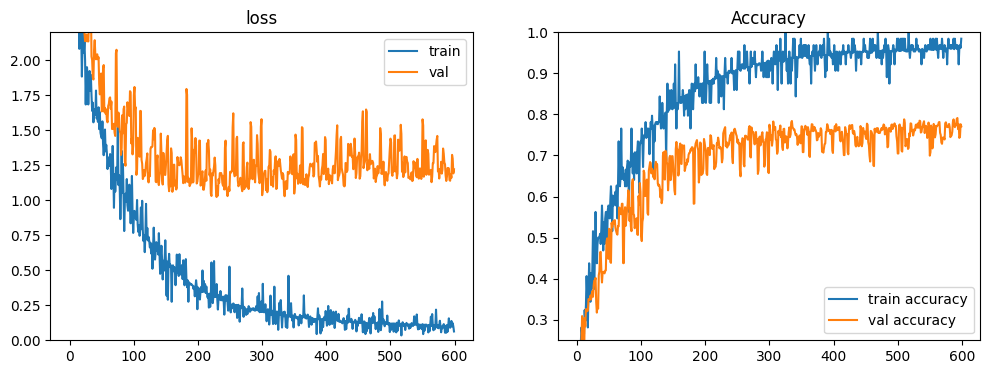

The accuracy is 77.9% compared to a chance level of 3.125%


In [28]:
plot_history(history)
plt.show()

res = data_aug_plus_droput_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

### now saving the model

In [31]:
# After training the model
data_aug_plus_droput_model.save('data_aug_plus_dropout_model.h5')

# Convert the model architecture to JSON
model_json = data_aug_plus_droput_model.to_json()

# Save the JSON to a file
with open("data_aug_plus_dropout_model.json", "w") as json_file:
    json_file.write(model_json)

## Trying to add increasing dropout rate to see if we get above 77.5%

In [25]:
from keras.layers import BatchNormalization

def dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.35))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

data_aug_plus_droput_model = dropout_model()
# fit model
steps = int(train_images.shape[0] / 64)
history = data_aug_plus_droput_model.fit(train_flow, steps_per_epoch=steps, epochs=600, validation_data=validation_dataset)

Epoch 1/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - accuracy: 0.0528 - loss: 4.1988 - val_accuracy: 0.0445 - val_loss: 3.6646
Epoch 2/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1719 - loss: 3.3066 - val_accuracy: 0.0478 - val_loss: 3.6486
Epoch 3/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.1175 - loss: 3.4207 - val_accuracy: 0.1060 - val_loss: 3.3112
Epoch 4/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1406 - loss: 3.2039 - val_accuracy: 0.1106 - val_loss: 3.3053
Epoch 5/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.1689 - loss: 3.1878 - val_accuracy: 0.1257 - val_loss: 3.1055
Epoch 6/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.2188 - loss: 3.3559

2024-08-12 17:17:02.961716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:17:02.961750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 3.3559 - val_accuracy: 0.1211 - val_loss: 3.1193
Epoch 7/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.1799 - loss: 3.0478 - val_accuracy: 0.1420 - val_loss: 3.0449
Epoch 8/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2656 - loss: 2.7002 - val_accuracy: 0.1348 - val_loss: 3.0510
Epoch 9/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.2126 - loss: 2.9193 - val_accuracy: 0.2107 - val_loss: 2.8313
Epoch 10/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 3.0048 - val_accuracy: 0.2166 - val_loss: 2.8343
Epoch 11/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.2245 - loss: 2.8753 - val_accuracy: 0.1741 - val_loss: 2.9855
Epoch 12/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1406 - loss: 2.9522 - val_accuracy: 0.1859 - val_loss: 2.9560
Epoch 13/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.2494 - loss: 2.7884 - val_

2024-08-12 17:19:31.398942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 2.6066 - val_accuracy: 0.2291 - val_loss: 2.8004
Epoch 21/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3043 - loss: 2.4851 - val_accuracy: 0.1891 - val_loss: 3.0120
Epoch 22/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3594 - loss: 2.1993 - val_accuracy: 0.2022 - val_loss: 2.9869
Epoch 23/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3100 - loss: 2.4469 - val_accuracy: 0.2343 - val_loss: 2.8411
Epoch 24/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.2969 - loss: 2.5138

2024-08-12 17:20:13.849255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:20:13.849288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2969 - loss: 2.5138 - val_accuracy: 0.2179 - val_loss: 2.8670
Epoch 25/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3236 - loss: 2.4030 - val_accuracy: 0.2219 - val_loss: 2.8964
Epoch 26/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 2.6593 - val_accuracy: 0.2271 - val_loss: 2.8938
Epoch 27/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3477 - loss: 2.3329 - val_accuracy: 0.2775 - val_loss: 2.6275
Epoch 28/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2500 - loss: 2.5774 - val_accuracy: 0.2749 - val_loss: 2.6189
Epoch 29/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.3572 - loss: 2.2707 - val_accuracy: 0.2480 - val_loss: 2.8206
Epoch 30/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 2.1580 - val_accuracy: 0.2539 - val_loss: 2.7995
Epoch 31/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3516 - loss: 2.2585 - v

2024-08-12 17:24:07.311922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:24:07.311949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3906 - loss: 2.1546 - val_accuracy: 0.3377 - val_loss: 2.4179
Epoch 47/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4239 - loss: 1.9940 - val_accuracy: 0.3619 - val_loss: 2.2041
Epoch 48/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 2.2023 - val_accuracy: 0.3619 - val_loss: 2.2633
Epoch 49/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4359 - loss: 1.9447 - val_accuracy: 0.3743 - val_loss: 2.1776
Epoch 50/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 2.1734 - val_accuracy: 0.3855 - val_loss: 2.1356
Epoch 51/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4405 - loss: 1.9262 - val_accuracy: 0.3527 - val_loss: 2.3468
Epoch 52/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 1.9888 - val_accuracy: 0.3514 - val_loss: 2.3676
Epoch 53/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4414 - loss: 1.9213 - v

2024-08-12 17:26:14.216356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4531 - loss: 1.8174 - val_accuracy: 0.3940 - val_loss: 2.1641
Epoch 59/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.4679 - loss: 1.8426 - val_accuracy: 0.3698 - val_loss: 2.2230
Epoch 60/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 1.7500 - val_accuracy: 0.3907 - val_loss: 2.1697
Epoch 61/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4736 - loss: 1.8104 - val_accuracy: 0.3207 - val_loss: 2.4719
Epoch 62/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.7087 - val_accuracy: 0.3246 - val_loss: 2.4626
Epoch 63/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.4818 - loss: 1.7874 - val_accuracy: 0.3842 - val_loss: 2.1702
Epoch 64/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4062 - loss: 1.9958

2024-08-12 17:27:18.127190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:27:18.127257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 1.9958 - val_accuracy: 0.3999 - val_loss: 2.1393
Epoch 65/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.4943 - loss: 1.7507 - val_accuracy: 0.3514 - val_loss: 2.2617
Epoch 66/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3594 - loss: 2.2186 - val_accuracy: 0.3665 - val_loss: 2.2189
Epoch 67/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.4932 - loss: 1.7113 - val_accuracy: 0.4116 - val_loss: 2.0059
Epoch 68/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.5989 - val_accuracy: 0.4130 - val_loss: 2.0147
Epoch 69/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4969 - loss: 1.7256 - val_accuracy: 0.3187 - val_loss: 2.6319
Epoch 70/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5781 - loss: 1.5816 - val_accuracy: 0.3207 - val_loss: 2.6238
Epoch 71/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5209 - loss: 1.6811 - v

2024-08-12 17:30:29.613146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5781 - loss: 1.5253 - val_accuracy: 0.4326 - val_loss: 1.9342
Epoch 83/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5522 - loss: 1.5274 - val_accuracy: 0.4267 - val_loss: 2.0310
Epoch 84/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.6339 - val_accuracy: 0.4359 - val_loss: 2.0177
Epoch 85/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.5472 - loss: 1.5405 - val_accuracy: 0.4967 - val_loss: 1.7415
Epoch 86/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.6248 - val_accuracy: 0.4791 - val_loss: 1.7581
Epoch 87/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.5470 - loss: 1.5087 - val_accuracy: 0.4529 - val_loss: 1.8552
Epoch 88/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 1.2011 - val_accuracy: 0.4385 - val_loss: 1.8923
Epoch 89/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.5560 - loss: 1.5131 - v

2024-08-12 17:34:43.194096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:34:43.194121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.0003 - val_accuracy: 0.4391 - val_loss: 1.8987
Epoch 107/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5946 - loss: 1.3287 - val_accuracy: 0.4306 - val_loss: 2.0956
Epoch 108/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 1.6827 - val_accuracy: 0.4188 - val_loss: 2.0805
Epoch 109/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6042 - loss: 1.3312 - val_accuracy: 0.4359 - val_loss: 1.9687
Epoch 110/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.4113 - val_accuracy: 0.4346 - val_loss: 1.9470
Epoch 111/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6081 - loss: 1.3187 - val_accuracy: 0.3226 - val_loss: 2.6141
Epoch 112/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.2197 - val_accuracy: 0.3449 - val_loss: 2.4816
Epoch 113/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.6129 - loss: 1.3

2024-08-12 17:39:40.897853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:39:40.897889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.2446 - val_accuracy: 0.4319 - val_loss: 1.9885
Epoch 135/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6495 - loss: 1.1457 - val_accuracy: 0.4849 - val_loss: 1.7940
Epoch 136/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 0.9927 - val_accuracy: 0.4568 - val_loss: 1.9074
Epoch 137/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6416 - loss: 1.1555 - val_accuracy: 0.5020 - val_loss: 1.6996
Epoch 138/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.1420 - val_accuracy: 0.5059 - val_loss: 1.6885
Epoch 139/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6528 - loss: 1.1232 - val_accuracy: 0.5635 - val_loss: 1.5253
Epoch 140/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 1.2705 - val_accuracy: 0.5687 - val_loss: 1.4863
Epoch 141/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6546 - loss: 1.1

2024-08-12 17:42:08.993987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:42:08.994014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.1853 - val_accuracy: 0.5530 - val_loss: 1.5549
Epoch 149/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6728 - loss: 1.0682 - val_accuracy: 0.5164 - val_loss: 1.7026
Epoch 150/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.8752 - val_accuracy: 0.4987 - val_loss: 1.7848
Epoch 151/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.6801 - loss: 1.0363 - val_accuracy: 0.5314 - val_loss: 1.6112
Epoch 152/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6406 - loss: 1.1892

2024-08-12 17:42:51.163796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:42:51.163823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.1892 - val_accuracy: 0.5386 - val_loss: 1.5980
Epoch 153/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6917 - loss: 1.0103 - val_accuracy: 0.6198 - val_loss: 1.3236
Epoch 154/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 1.0173 - val_accuracy: 0.6217 - val_loss: 1.3108
Epoch 155/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6854 - loss: 1.0277 - val_accuracy: 0.5720 - val_loss: 1.4831
Epoch 156/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 1.1627 - val_accuracy: 0.5825 - val_loss: 1.4470
Epoch 157/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6799 - loss: 1.0314 - val_accuracy: 0.5798 - val_loss: 1.4369
Epoch 158/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 1.0850 - val_accuracy: 0.5838 - val_loss: 1.4203
Epoch 159/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6882 - loss: 1.0

2024-08-12 17:44:15.699203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:44:15.699229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.0468 - val_accuracy: 0.4562 - val_loss: 1.9623
Epoch 161/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6823 - loss: 1.0280 - val_accuracy: 0.5582 - val_loss: 1.5174
Epoch 162/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6719 - loss: 1.0324 - val_accuracy: 0.5779 - val_loss: 1.4574
Epoch 163/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.6941 - loss: 0.9814 - val_accuracy: 0.5726 - val_loss: 1.4950
Epoch 164/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.1442 - val_accuracy: 0.5687 - val_loss: 1.5184
Epoch 165/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7013 - loss: 0.9674 - val_accuracy: 0.5792 - val_loss: 1.4933
Epoch 166/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.2541 - val_accuracy: 0.5870 - val_loss: 1.4320
Epoch 167/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7096 - loss: 0.9

2024-08-12 17:47:26.533148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.1150 - val_accuracy: 0.5962 - val_loss: 1.3758
Epoch 179/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7260 - loss: 0.8911 - val_accuracy: 0.6047 - val_loss: 1.3662
Epoch 180/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.9408 - val_accuracy: 0.6080 - val_loss: 1.3645
Epoch 181/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7239 - loss: 0.8940 - val_accuracy: 0.5105 - val_loss: 1.7473
Epoch 182/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.8135 - val_accuracy: 0.5262 - val_loss: 1.7057
Epoch 183/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7216 - loss: 0.8868 - val_accuracy: 0.5975 - val_loss: 1.4024
Epoch 184/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 1.1769 - val_accuracy: 0.5825 - val_loss: 1.4475
Epoch 185/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7226 - loss: 0.8

2024-08-12 17:49:34.202214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 17:49:34.202239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.0473 - val_accuracy: 0.6355 - val_loss: 1.2706
Epoch 191/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7407 - loss: 0.8238 - val_accuracy: 0.6132 - val_loss: 1.2866
Epoch 192/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.6863 - val_accuracy: 0.6113 - val_loss: 1.3107
Epoch 193/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7214 - loss: 0.8659 - val_accuracy: 0.6086 - val_loss: 1.3868
Epoch 194/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.8177 - val_accuracy: 0.6257 - val_loss: 1.2909
Epoch 195/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7309 - loss: 0.8478 - val_accuracy: 0.6106 - val_loss: 1.4303
Epoch 196/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.0427 - val_accuracy: 0.6165 - val_loss: 1.3820
Epoch 197/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7366 - loss: 0.8

2024-08-12 17:50:59.035075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 0.7651 - val_accuracy: 0.6093 - val_loss: 1.3928
Epoch 199/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7429 - loss: 0.8052 - val_accuracy: 0.6276 - val_loss: 1.3212
Epoch 200/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 0.6804 - val_accuracy: 0.6257 - val_loss: 1.3421
Epoch 201/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7462 - loss: 0.7966 - val_accuracy: 0.6027 - val_loss: 1.3910
Epoch 202/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.9326 - val_accuracy: 0.5897 - val_loss: 1.4538
Epoch 203/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7544 - loss: 0.7856 - val_accuracy: 0.5674 - val_loss: 1.5125
Epoch 204/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.7115 - val_accuracy: 0.5504 - val_loss: 1.5819
Epoch 205/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7432 - loss: 0.8

2024-08-12 17:54:31.705905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.7694 - val_accuracy: 0.5851 - val_loss: 1.4997
Epoch 219/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7633 - loss: 0.7277 - val_accuracy: 0.6086 - val_loss: 1.3977
Epoch 220/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.6430 - val_accuracy: 0.6158 - val_loss: 1.3968
Epoch 221/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7596 - loss: 0.7228 - val_accuracy: 0.6787 - val_loss: 1.1387
Epoch 222/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.6088 - val_accuracy: 0.6780 - val_loss: 1.1492
Epoch 223/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.7682 - loss: 0.7059 - val_accuracy: 0.5366 - val_loss: 1.7383
Epoch 224/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.7220 - val_accuracy: 0.5321 - val_loss: 1.7356
Epoch 225/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7789 - loss: 0.6

2024-08-12 18:05:51.455881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 18:05:51.455908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.5814 - val_accuracy: 0.6486 - val_loss: 1.3435
Epoch 283/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8269 - loss: 0.5255 - val_accuracy: 0.6139 - val_loss: 1.3995
Epoch 284/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.5218 - val_accuracy: 0.6230 - val_loss: 1.3889
Epoch 285/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8284 - loss: 0.5214 - val_accuracy: 0.6551 - val_loss: 1.3257
Epoch 286/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.3665 - val_accuracy: 0.6616 - val_loss: 1.2842
Epoch 287/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8285 - loss: 0.5178 - val_accuracy: 0.6505 - val_loss: 1.3422
Epoch 288/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.5905 - val_accuracy: 0.6335 - val_loss: 1.4271
Epoch 289/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8274 - loss: 0.5

2024-08-12 18:09:44.781326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2745 - val_accuracy: 0.6145 - val_loss: 1.5449
Epoch 305/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8498 - loss: 0.4555 - val_accuracy: 0.7068 - val_loss: 1.1088
Epoch 306/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.5519 - val_accuracy: 0.7081 - val_loss: 1.0464
Epoch 307/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8493 - loss: 0.4513 - val_accuracy: 0.7114 - val_loss: 1.1407
Epoch 308/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.5104 - val_accuracy: 0.7094 - val_loss: 1.1325
Epoch 309/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8397 - loss: 0.4831 - val_accuracy: 0.7120 - val_loss: 1.0995
Epoch 310/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.5276 - val_accuracy: 0.7179 - val_loss: 1.0863
Epoch 311/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8445 - loss: 0.4

2024-08-12 18:15:02.461549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.3499 - val_accuracy: 0.7284 - val_loss: 1.0768
Epoch 335/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.8588 - loss: 0.4078 - val_accuracy: 0.7094 - val_loss: 1.2395
Epoch 336/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4749 - val_accuracy: 0.7081 - val_loss: 1.1897
Epoch 337/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8615 - loss: 0.3972 - val_accuracy: 0.6688 - val_loss: 1.3552
Epoch 338/600
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8281 - loss: 0.5624

2024-08-12 18:15:45.911943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 18:15:45.911970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.5624 - val_accuracy: 0.6479 - val_loss: 1.4460
Epoch 339/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8636 - loss: 0.4015 - val_accuracy: 0.7186 - val_loss: 1.1152
Epoch 340/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.3852 - val_accuracy: 0.7219 - val_loss: 1.1208
Epoch 341/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8653 - loss: 0.3846 - val_accuracy: 0.6407 - val_loss: 1.4949
Epoch 342/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.3700 - val_accuracy: 0.6466 - val_loss: 1.4786
Epoch 343/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8753 - loss: 0.3719 - val_accuracy: 0.7179 - val_loss: 1.1858
Epoch 344/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.3436 - val_accuracy: 0.7134 - val_loss: 1.1972
Epoch 345/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8716 - loss: 0.3

2024-08-12 18:22:49.856384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 18:22:49.856412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2872 - val_accuracy: 0.6885 - val_loss: 1.2755
Epoch 379/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8884 - loss: 0.3204 - val_accuracy: 0.7291 - val_loss: 1.1526
Epoch 380/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1888 - val_accuracy: 0.7408 - val_loss: 1.1066
Epoch 381/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8791 - loss: 0.3440 - val_accuracy: 0.7428 - val_loss: 1.1069
Epoch 382/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2606 - val_accuracy: 0.7513 - val_loss: 1.0831
Epoch 383/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8906 - loss: 0.3205 - val_accuracy: 0.6610 - val_loss: 1.4621
Epoch 384/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.4396 - val_accuracy: 0.6734 - val_loss: 1.4087
Epoch 385/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8866 - loss: 0.3

2024-08-12 18:30:36.792054: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.3401 - val_accuracy: 0.7094 - val_loss: 1.3361
Epoch 423/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9005 - loss: 0.2852 - val_accuracy: 0.6963 - val_loss: 1.3396
Epoch 424/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2313 - val_accuracy: 0.7009 - val_loss: 1.3453
Epoch 425/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9069 - loss: 0.2634 - val_accuracy: 0.7487 - val_loss: 1.0854
Epoch 426/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4271 - val_accuracy: 0.7572 - val_loss: 1.0168
Epoch 427/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9047 - loss: 0.2768 - val_accuracy: 0.6662 - val_loss: 1.4488
Epoch 428/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.2189 - val_accuracy: 0.6872 - val_loss: 1.3472
Epoch 429/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9043 - loss: 0.2

2024-08-12 18:33:48.596676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 18:33:48.596701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.1742 - val_accuracy: 0.7520 - val_loss: 1.1207
Epoch 441/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9089 - loss: 0.2568 - val_accuracy: 0.7389 - val_loss: 1.1508
Epoch 442/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2675 - val_accuracy: 0.7310 - val_loss: 1.1916
Epoch 443/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9104 - loss: 0.2586 - val_accuracy: 0.7251 - val_loss: 1.2446
Epoch 444/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2849 - val_accuracy: 0.7075 - val_loss: 1.3158
Epoch 445/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9077 - loss: 0.2529 - val_accuracy: 0.7238 - val_loss: 1.2245
Epoch 446/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1592 - val_accuracy: 0.7291 - val_loss: 1.2367
Epoch 447/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9100 - loss: 0.2

2024-08-12 18:52:37.411318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.2272 - val_accuracy: 0.7598 - val_loss: 1.1449
Epoch 547/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9315 - loss: 0.1787 - val_accuracy: 0.7448 - val_loss: 1.2059
Epoch 548/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.2748 - val_accuracy: 0.7349 - val_loss: 1.2489
Epoch 549/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9322 - loss: 0.1846 - val_accuracy: 0.7147 - val_loss: 1.3745
Epoch 550/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2607 - val_accuracy: 0.7219 - val_loss: 1.3257
Epoch 551/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9321 - loss: 0.1827 - val_accuracy: 0.7114 - val_loss: 1.3638
Epoch 552/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1058 - val_accuracy: 0.7022 - val_loss: 1.4214
Epoch 553/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9362 - loss: 0.1

2024-08-12 19:00:06.786436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:00:06.786467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1999 - val_accuracy: 0.7022 - val_loss: 1.3687
Epoch 589/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9375 - loss: 0.1701 - val_accuracy: 0.7624 - val_loss: 1.1570
Epoch 590/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0604 - val_accuracy: 0.7644 - val_loss: 1.1693
Epoch 591/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9411 - loss: 0.1599 - val_accuracy: 0.7500 - val_loss: 1.2571
Epoch 592/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1043 - val_accuracy: 0.7382 - val_loss: 1.2872
Epoch 593/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9375 - loss: 0.1701 - val_accuracy: 0.7448 - val_loss: 1.2615
Epoch 594/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.1600 - val_accuracy: 0.7421 - val_loss: 1.2588
Epoch 595/600
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9363 - loss: 0.1

2024-08-12 19:02:14.763649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752931588001709737
2024-08-12 19:02:14.763676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10736652053762674006


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.4139 - val_accuracy: 0.7264 - val_loss: 1.3213


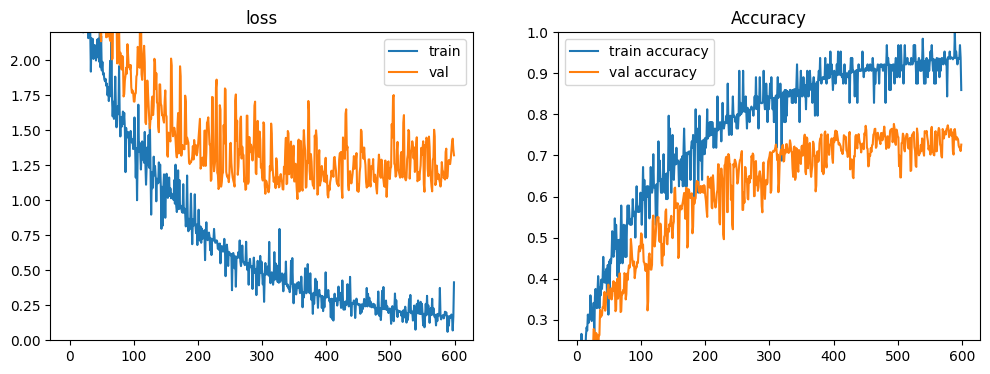

The accuracy is 70.8% compared to a chance level of 3.125%


In [26]:
plot_history(history)
plt.show()

res = data_aug_plus_droput_model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

In [107]:
# serialize model to JSON
model_json = dropout_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dropout_model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [108]:
dropout_model.save("model.keras")

# Experimenting

In [13]:
# define cnn model
def define_baseline_model():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
     model.add(Dense(30, activation='softmax'))
     # compile model
     opt = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

model = define_baseline_model()

# Train the model with EarlyStopping
fivevgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


I0000 00:00:1719587443.166435    1802 service.cc:145] XLA service 0x7fee04006f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719587443.166574    1802 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-06-28 15:10:44.653942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-28 15:10:46.888201: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1719587448.157591    2314 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1386', 8 bytes spill stores, 8 bytes spill loads



  2/188 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.0430 - loss: 3.4946 

I0000 00:00:1719587459.056423    1802 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.0541 - loss: 3.3685 - val_accuracy: 0.1230 - val_loss: 3.1314
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.1387 - loss: 3.0599 - val_accuracy: 0.1931 - val_loss: 2.8925
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.2208 - loss: 2.8019 - val_accuracy: 0.2762 - val_loss: 2.6180
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.2717 - loss: 2.5786 - val_accuracy: 0.3253 - val_loss: 2.4740
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.3395 - loss: 2.3607 - val_accuracy: 0.3272 - val_loss: 2.4312
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.3952 - loss: 2.1605 - val_accuracy: 0.3868 - val_loss: 2.2058
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.4525 - loss: 1.9029 - val_accuracy: 0.4149 - val_loss: 2.1308
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.5275 - loss: 1.6590

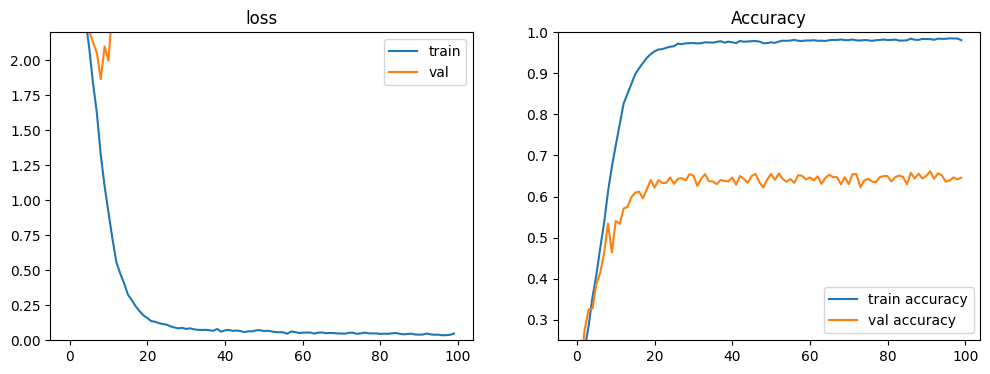

In [34]:
plot_history(fivevgghistory)
plt.show()

In [35]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 66.0% compared to a chance level of 1.5625%


### 6 VGG Blocks

In [32]:
# define cnn model
def define_baseline_model():
     model = Sequential()
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
     model.add(MaxPooling2D((2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
     model.add(Dense(30, activation='softmax'))
     # compile model
     opt = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

model = define_baseline_model()

# Train the model with EarlyStopping
sixvgghistory = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.0435 - loss: 3.4733 - val_accuracy: 0.1021 - val_loss: 3.2740
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.0928 - loss: 3.2442 - val_accuracy: 0.1440 - val_loss: 3.0422
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.1789 - loss: 2.9455 - val_accuracy: 0.2219 - val_loss: 2.7753
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.2424 - loss: 2.7294 - val_accuracy: 0.2487 - val_loss: 2.6864
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.2911 - loss: 2.5170 - val_accuracy: 0.3037 - val_loss: 2.4101
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.3549 - loss: 2.2721 - val_accuracy: 0.3547 - val_loss: 2.3142
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.4017 - loss: 2.0873 - val_accuracy: 0.3442 - val_loss: 2.2659
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.4857 - loss: 1

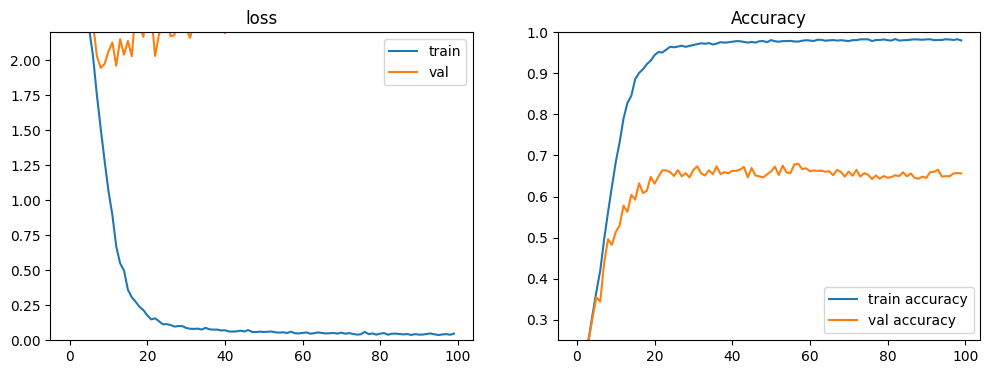

In [36]:
plot_history(sixvgghistory)
plt.show()

In [37]:
res = model.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 65.6% compared to a chance level of 1.5625%
